In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 100)
pd.set_option('max_columns', 100)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

In [ ]:
startDate = '20201116'
endDate = '20201127'


readPath = r'\\192.168.10.34\random_backup\Kevin_zhenyu\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
rawOrderLog = []
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_csv(thisPath)
    data = data.rename(columns={'mdClockAtArrival': 'caamd'})
    rawOrderLog += [data]
rawOrderLog = pd.concat(rawOrderLog, sort=False)

for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
            'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
    rawOrderLog[col] = rawOrderLog[col].fillna(0).astype('int64')   
rawOrderLog = rawOrderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

rawOrderLog = rawOrderLog[rawOrderLog["secid"] >= 1000000]

rawOrderLog['clock'] = rawOrderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
rawOrderLog['broker'] = rawOrderLog['accCode'] // 100
rawOrderLog["broker"] = np.where(rawOrderLog["accCode"].astype(str).apply(lambda x: len(x) == 6), rawOrderLog['accCode'] // 10000, rawOrderLog["broker"])
rawOrderLog['colo_broker'] = rawOrderLog['colo'].str[:2] + '_' + rawOrderLog['broker'].astype('str')
rawOrderLog['order'] = rawOrderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['group'] = rawOrderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['startClock'] = rawOrderLog.groupby(['order'])['clockAtArrival'].transform('first')
rawOrderLog['duration'] = rawOrderLog['clockAtArrival'] - rawOrderLog['startClock']
rawOrderLog['orderPrice'] = rawOrderLog['orderPrice'].apply(lambda x: round(x, 2))
rawOrderLog['tradePrice'] = rawOrderLog['tradePrice'].apply(lambda x: round(x, 2))
rawOrderLog['orderDirection1'] = np.where(rawOrderLog["orderDirection"] == -2, -1, np.where(
    rawOrderLog["orderDirection"] == 2, 1, rawOrderLog["orderDirection"]))
orderLog = rawOrderLog.copy()

### Assertion 1:  make sure same direction in same date, secid, vai
print('=======================================================================================')
print('1. same date, secid, vai: same direction')
orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].transform('nunique')
if len(orderLog[orderLog['directNum'] != 1]) > 0:
    print('opposite direction for same date, same secid, same vai')
    display(orderLog[(orderLog['directNum'] != 1) & (orderLog['updateType'] == 0)][['date', 'accCode', 'secid', 'vai', 'orderDirection', 'order']])
    orderLog = orderLog[orderLog['directNum'] == 1]

assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].nunique() == 1).all() == True)

## Assertion 2:  make sure each account, secid, vai only has one insertion
print('=======================================================================================')
print('2. same date, secid, vai, accCode: one insertion')
a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
if len(a[a > 1]) > 0:
    print('more than one insertion at same time')
    a = a[a>1].reset_index()
    display(a)
    orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
                             np.where(orderLog['mse'] == 100, 1, 0), np.nan)
orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()

placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]
print('%.2f%% SZE orders triggered by msg data'%(placeSZE[placeSZE['isMsg'] == 1].shape[0]/placeSZE.shape[0]*100))


### Assertion 3:  check IPO stocks selling status
print('=======================================================================================')
print('3. IPO stocks selling (ars = 301, 302)')
if orderLog[orderLog['ars'].isin([301, 302])].shape[0] != 0:
    kk = orderLog[orderLog['ars'].isin([301, 302])]
    print(kk)
    try:
        assert(kk[kk['orderDirection1'] == 1].shape[0] == 0)
        print('we only sell, never buy')
    except:
        print('There are IPO buy side orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk[kk['orderDirection1'] == 1])
    kk1 = kk[kk['updateType'] == 0]
    kk1 = kk1.sort_values(by=['accCode', 'secid','clockAtArrival'])
    kk1['diff'] = kk1.groupby(['accCode', 'secid'])['clockAtArrival'].apply(lambda x: x-x.shift(1))
    kk1['diff'] = kk1['diff'].fillna(0)
    try:
        assert(kk1[kk1['diff'] < 10e6].shape[0] == 0)
        print('for each stock in the same account, there is no insertion within 10 seconds of the previous insertion')
    except:
        print('There are insertion within 10 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk1[kk1['diff'] < 10e6])
    kk2 = kk[(kk['updateType'] == 1)]
    try:
        assert(kk2[kk2['duration'] < 3e6].shape[0] == 0)
        print('for each stock in the same account, the cancellation of an order happens more than 3 seconds after the insertion')
    except:
        print('There are cancellation within 3 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk2[kk2['duration'] < 3e6])


### Assertion 4: check updateType == 7 orders, make sure updateType == 7 orders < 20 per account, < 100 in total
print('=======================================================================================')
print('4. updateType 7 orders')
if orderLog[orderLog['updateType'] == 7].shape[0] != 0:
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['order'].nunique().max() < 20)
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['order'].nunique().sum() < 100)

### Assertion 5: check updateType == 6 orders, make sure updateType == 6 orders < 5% per account
print('=======================================================================================')
print('5. updateType 6 orders')
k1 = orderLog[orderLog['updateType'] == 6].groupby('accCode')['order'].nunique().reset_index()
k2 = orderLog.groupby('accCode')['order'].nunique().reset_index()
k = pd.merge(k1, k2, on='accCode', how='left')
k['prob'] = k['order_x']/k['order_y']
try:
    assert(sum(k['prob'] >= 0.05) == 0)
except:
    print('There are accounts with more than 5% updateType 6 orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    print(k[k['prob'] >= 0.05])

### Assertion 6: check CYB orders, make sure CYB stocks total absOrderSize < 30w
print('=======================================================================================')
print('6. CYB stocks total order size < 30w')
try:
    assert(orderLog[(orderLog['secid'] >= 2300000) & (orderLog['updateType'] == 0)]['absOrderSize'].max() <= 300000)
except:
    print('CYB stocks total absOrderSize >= 30w!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    
     
### Assertion 7:  make sure there is no unexpected updateType 
print('=======================================================================================')
print('7. unexpected updateType')
def getTuple(x):
    return tuple(i for i in x)

checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 1, 4), (0, 4, 1, 4), (0, 2, 2, 4), (0, 4, 2, 4), (0, 2, 2, 1, 4), (0, 2, 2, 4, 1, 4)]),0,
                     np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3), (0, 1, 4, 3),
                                                               (0, 2, 2, 4, 1, 3), (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 1, 4, 3), (0, 4, 2, 4, 1, 3),
                                                               (0, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 1)]), 1,
                     np.where(checkLog['updateType'].isin([(0, 2, 1, 3), (0, 2, 2, 1, 3), (0, 2, 3), (0, 3), (0, 1, 3), (0, ), (0, 2), (0, 2, 1), (0, 2, 2)]), 2, 3)))

orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

### Assertion 8:  make sure status==0 got all traded
print('=======================================================================================')
print('8. status == 0: all traded')
a = orderLog[orderLog['status'] == 0]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in total trade, any fill != total cases')
display(a[a['filled'] != a['total']])
if a[a['filled'] != a['total']].shape[0] > 0:
    removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### Assertion 9:  make sure status==1 got partial traded
print('=======================================================================================')
print('9. status == 1: partial traded')
a = orderLog[orderLog['status'] == 1]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in partial trade, any fill >= total or fill is 0 cases for updateType 4')
display(a[(a['filled'] >= a['total']) | (a['filled'] == 0)])
if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
    removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### Assertion 10: make sure no cancellation within 1 sec
print('=======================================================================================')
print('10. no cancellation within 1 sec')
a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
print('any cancellation within 1 sec')
display(a)
if a.shape[0] > 0:
    removeOrderLs = a['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]


### Assertion 11: make sure no order has shares > 80w or notional > 800w
print('=======================================================================================')
print('11. Orders with size > 80w or notional > 800w')
orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']
if orderLog[orderLog['absOrderSize'] > 800000].shape[0] > 0:
    print('some order quantity are > 80w')
    print(orderLog[orderLog['absOrderSize'] > 800000].groupby(['colo', 'accCode'])['order'].nunique())
    display(orderLog[orderLog['absOrderSize'] > 800000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                         'orderNtl', 'orderDirection', 'clock', 'order']])
            
if orderLog[orderLog['orderNtl'] > 8000000].shape[0] > 0:
    print('some order ntl are > 800w')
    print(orderLog[orderLog['orderNtl'] > 8000000].groupby(['colo', 'accCode'])['order'].nunique())
    display(orderLog[orderLog['orderNtl'] > 8000000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                      'orderNtl', 'orderDirection', 'clock', 'order', "updateType", 
                                                      "tradePrice", "absOrderSizeCumFilled", "absFilledThisUpdate"]])

removeOrderLs = list(set(orderLog[orderLog['absOrderSize'] > 800000]['order'].unique()) | set(orderLog[orderLog['orderNtl'] > 8000000]['order'].unique()))
orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]


orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
orderLog['orderNtl'] = orderLog['orderPrice'] * orderLog['absOrderSize']
orderLog['tradeNtl'] = np.where(orderLog['updateType'] == 4, orderLog['tradePrice']*orderLog['absFilledThisUpdate'], 0)
orderLog["mrstaat"] = orderLog.groupby(['order'])['mrstaat'].transform('first')
orderLog["ars"] = orderLog.groupby(['order'])['ars'].transform('first')
orderLog["mrstauc"] = orderLog.groupby(['order'])['mrstauc'].transform('first')

In [12]:
orderLog = orderLog[~orderLog['ars'].isnull()]
orderLog = orderLog[orderLog['ars']//1%10 == 1]
orderLog.loc[(orderLog['date'].isin([20201009, 20201012, 20201013])) & (orderLog['ars'].isin([121, 131])), 'mrstauc'] = 1000
orderLog.loc[(orderLog['date'].isin([20201009, 20201012, 20201013])) & (orderLog['ars'].isin([221, 231])), 'mrstauc'] = 2000
orderLog.loc[(orderLog['date'].isin([20201009, 20201012, 20201013])) & (orderLog['ars'].isin([321, 331])), 'mrstauc'] = 3000
orderLog.loc[(orderLog['date'].isin([20201009, 20201012, 20201013])) & (~orderLog['ars'].isin([121, 221, 321, 131, 231, 331])), 'mrstauc'] = 0
orderLog.loc[(orderLog['date'].isin([20201009, 20201012, 20201013])) & (orderLog['mrstauc'].isin([1000, 2000, 3000])), 'mrstaat'] = 3000
orderLog.loc[(orderLog['date'].isin([20201009, 20201012, 20201013])) & (orderLog['mrstauc'] == 0), 'mrstaat'] = 1000

orderLog = orderLog[~orderLog["mrstaat"].isnull()]
orderLog = orderLog[(orderLog['mrstaat'] != 0) & (orderLog['mrstaat'] != 2000)]
orderLog['sta'] = np.where(orderLog['mrstaat'] == 1000, 'staone', np.where(
orderLog['mrstaat'] == 3000, 'statwo', 'sta300'))

In [15]:
orderLog[(orderLog['updateType'] == 0) & (orderLog['sta'] == 'sta300') & (orderLog['accCode'].isin([6282, 6237]))].groupby(['date', 'colo', 'accCode'])['secid'].size()

date      colo      accCode
20201021  zs_96_08  6282       1858
20201022  zs_96_08  6282       1425
Name: secid, dtype: int64

In [4]:
rawOrderLog[(rawOrderLog['updateType'] == 0) & (rawOrderLog['accCode'].isin([6282, 6237]))].groupby(['date', 'colo', 'accCode', 'ars', 'mrstaat'])['mrstauc'].unique()

date      colo      accCode  ars  mrstaat
20201020  zs_94_04  6237     1.0  1000.0                                                 [0.0]
          zs_96_08  6282     1.0  1000.0                                                 [0.0]
                                  3000.0                              [1000.0, 3000.0, 2000.0]
20201021  zs_94_04  6237     1.0  1000.0                                                 [0.0]
          zs_96_08  6282     1.0  1000.0                                                 [0.0]
                                  3000.0                                              [1000.0]
                                  11000.0                          [10000.0, 30000.0, 20000.0]
                                  13000.0    [11000.0, 12000.0, 22000.0, 33000.0, 13000.0, ...
20201022  zs_94_04  6237     1.0  1000.0                                                 [0.0]
          zs_96_08  6282     1.0  11000.0                                   [10000.0, 30000.0]
        

In [19]:
orderLog[(orderLog['date'] == 20201023) & (orderLog['updateType'] == 0) & (orderLog['accCode'].isin([6282, 6237]))]

,Unnamed: 0,date,clockAtArrival,caamd,colo,accCode,secid,vai,sdd,orderDirection,absOrderSize,updateType,tradePrice,absFilledThisUpdate,absOrderSizeCumFilled,tradeId,orderSysId,aaa,internalId,ars,mse,mta,mrstaat,session,cfe,mrss90,mrstauc,mra100,orderId,underlyingIndex,mt,mrsb90,mrm,mrsb300,orderPrice,l4tr,hee,mrb100,cancellationPending,mrss300,mfe,threadId,ms,finalState,sequenceNo,ApplSeqNum,clock,mrstaum,mrrlma,broker,colo_broker,order,group,startClock,duration,orderDirection1,directNum,isMsg,status,orderNtl,exchange,tradeNtl,sta


In [46]:
orderLog[(orderLog['date'] == 20201019) & (orderLog['updateType'] == 0) & (orderLog['orderDirection'] >= 1) &\
         (orderLog['mrstaat'] == 11000) & (abs(orderLog['aaa'] - orderLog['mrsb90']) < 1e-4)][['date', 'secid', 'vai', 'orderDirection', 'updateType', 'aaa', 'mrstaat', 'mrstauc', 'mrsb90', 'mrss90', 'mrsb300', 'mrss300']].head(30)

,date,secid,vai,orderDirection,updateType,aaa,mrstaat,mrstauc,mrsb90,mrss90,mrsb300,mrss300
5118392,20201019,1600093,4154525,1,0,0.001557,11000.0,10000.0,0.001557,-0.002492,0.000905,-0.001843
5124328,20201019,1600133,8865896,1,0,0.001975,11000.0,10000.0,0.001975,-0.003636,0.001757,-0.003420
5137882,20201019,1600295,6692001,1,0,0.001981,11000.0,20000.0,0.001981,-0.002880,0.001817,-0.002846
5172294,20201019,1600626,2567800,1,0,0.002258,11000.0,10000.0,0.002258,-0.004539,0.002964,-0.005196
5213331,20201019,1601163,3675109,1,0,0.001903,11000.0,10000.0,0.001903,-0.002415,0.001211,-0.001851
5215361,20201019,1601222,17679059,1,0,0.001065,11000.0,10000.0,0.001065,-0.002337,0.002363,-0.003639
5215446,20201019,1601222,32985175,1,0,0.001835,11000.0,10000.0,0.001835,-0.003139,0.000878,-0.002175
5221883,20201019,1601567,8579189,1,0,0.001556,11000.0,10000.0,0.001556,-0.003006,0.002677,-0.004119
5221887,20201019,1601567,9696189,1,0,0.001390,11000.0,10000.0,0.001390,-0.002841,0.002025,-0.003475
5226034,20201019,1601615,25719332,1,0,0.001766,11000.0,10000.0,0.001704,-0.002706,0.001506,-0.002550


In [41]:
orderLog[(orderLog['date'] == 20201019) & (orderLog['updateType'] == 0) & (orderLog['mrstaat'] == 11000)][['date', 'secid', 'vai', 'orderDirection', 'updateType', 'aaa', 'mrstaat', 'mrstauc', 'mrsb90', 'mrss90', 'mrsb300', 'mrss300']].head(30)

,date,secid,vai,orderDirection,updateType,aaa,mrstaat,mrstauc,mrsb90,mrss90,mrsb300,mrss300
5109846,20201019,1600026,7535008,-1,0,0.000780,11000.0,20000.0,-0.002002,0.000674,-0.002073,0.000745
5109866,20201019,1600026,14336797,-1,0,0.000928,11000.0,10000.0,-0.001512,0.000163,-0.00287,0.001525
5113385,20201019,1600060,10746044,-1,0,0.002823,11000.0,10000.0,-0.002936,0.001443,-0.005166,0.003689
5116193,20201019,1600079,6762278,1,0,0.001575,11000.0,10000.0,0.000874,-0.001175,0.001989,-0.002303
5116246,20201019,1600079,6766278,1,0,0.001292,11000.0,10000.0,0.000800,-0.001114,0.001548,-0.001864
5116305,20201019,1600079,6810778,1,0,0.001507,11000.0,10000.0,0.001338,-0.001663,0.001402,-0.001718
5116623,20201019,1600079,7334778,1,0,0.001678,11000.0,10000.0,0.000790,-0.001093,0.00226,-0.002572
5118392,20201019,1600093,4154525,1,0,0.001557,11000.0,10000.0,0.001557,-0.002492,0.000905,-0.001843
5122793,20201019,1600132,469610,1,0,0.002170,11000.0,10000.0,0.002306,-0.003051,0.001639,-0.002396
5123071,20201019,1600132,924998,1,0,0.001539,11000.0,10000.0,0.001356,-0.002117,0.001441,-0.002206


In [36]:
orderLog[(orderLog['date'] >= 20201019) & (orderLog['server_account'] == 'zt5205_537403') & (orderLog['updateType'] == 0)].groupby(['date','mrstaat'])['secid'].size()

date      mrstaat
20201019  3000.0        2
          11000.0      45
          13000.0     490
20201020  11000.0      30
          13000.0     572
20201021  3000.0        2
          11000.0      28
          13000.0     665
20201022  11000.0      36
          13000.0     659
20201023  11000.0      30
          13000.0    1029
Name: secid, dtype: int64

In [26]:
orderLog[(orderLog['sta'].isin(['stathree13', 'stathree23'])) & (orderLog['updateType'] == 0)].groupby(['date', 'server_account'])['secid'].nunique()

date      server_account
20201014  zs9405_9451       240
20201015  zs9405_9451       290
20201016  zs9405_9451       317
20201019  zs9405_9451       295
          zt5205_537403     107
          zt9609_965801     195
          zt9609_968501     201
20201020  zs9405_9451       305
          zt5205_537403     108
          zt7001_7079        81
          zt9609_965801     166
          zt9609_968501     158
20201021  zs9405_9451       336
          zs9608_6282       232
          zs9608_9754       277
          zt5205_537403     105
          zt7001_7079        78
          zt9609_965801     190
          zt9609_968501     189
20201022  zs9405_9451       302
          zs9608_6282       225
          zs9608_9754       267
          zt5205_537403     117
          zt7001_7079        90
          zt9609_965801     189
          zt9609_968501     153
20201023  zs9405_9451       345
          zs9608_9754       268
          zt5205_537403     130
          zt7001_7079        86
          zt960

In [7]:
orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['colo_broker'] == 'zs_52') & (orderLog['updateType'] == 0) & 
        (orderLog['sta'] == 'staone')].groupby(['colo', 'orderDirection'])['ars'].size()

colo      orderDirection
zs_52_02  -1                  994
           1                  496
zs_52_06  -1                21987
           1                 8099
zs_52_08  -1                 5296
           1                 2289
Name: ars, dtype: int64

In [23]:
orderLog["sta"] = np.where(orderLog["ars"].isin([131, 231, 331]), "statwo", "staone")
orderLog[(orderLog['accCode'] == 968501) & (orderLog['sta'] == 'statwo') & (orderLog['updateType'] == 4)]['tradeNtl'].sum() / \
orderLog[(orderLog['accCode'] == 968501) & (orderLog['sta'] == 'statwo') & (orderLog['updateType'] == 0)]['orderNtl'].sum()

0.7379259239710745

In [43]:
re = orderLog[(orderLog['accCode'] == 968501) & (orderLog['sta'] == 'statwo') & (orderLog['updateType'] == 0)].groupby('ars')['orderNtl'].sum().reset_index()
re1 = orderLog[(orderLog['accCode'] == 968501) & (orderLog['sta'] == 'statwo') & (orderLog['updateType'] == 4)].groupby('ars')['tradeNtl'].sum().reset_index()
re = pd.merge(re, re1, on='ars')
re['fillrate'] = re['tradeNtl']/re['orderNtl']
re['orderNtl'] = re['orderNtl'].astype('int64')
re['tradeNtl'] = re['tradeNtl'].astype('int64')
re['fillrate'] = re['fillrate'].apply(lambda x: '%.1f%%'%(100*x))
from IPython.display import display, HTML
HTML(re[re['ars'].isin([131, 231, 331])].groupby(["ars"])["orderNtl","tradeNtl", 'fillrate'].first().to_html())

,orderNtl,tradeNtl,fillrate
ars,,,
131.0,66289623,53811280,81.2%
231.0,4387465,3303115,75.3%
331.0,1579785,1526349,96.6%


In [41]:
re[re['ars'].isin([131, 231, 331])]

,ars,orderNtl,tradeNtl,fillrate
1,131.0,66289623,53811280,81.2%
3,231.0,4387465,3303115,75.3%
5,331.0,1579785,1526349,96.6%


In [39]:
orderLog[(orderLog['accCode'] == 968501) & (orderLog['ars'] == 321)]

,Unnamed: 0,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,internalId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,l4tr,clock,broker,colo_broker,order,group,startClock,duration,orderDirection1,orderNtl,directNum,isMsg,status,exchange,tradeNtl,sta
157489,99168,1597114379634975,1597114379634782,1600966,0,9788462,321.0,0,1,2700,0,12.79,-1.00,20200811,968501,100,zt_96_09,NaN,648.0,NaN,105259000.0,0.000584,2212523.0,0.004385,0.004385,0.000584,-0.002368,9788462.0,1277.0,1279.0,0.0,2020-08-11 10:52:59.634975,96,zt_96,61599,24724,1597114379634975,0,1,34533.0,1,1.0,0,SSE,0.0,statwo
157490,99169,1597114379890105,1597114379634782,1600966,2,9788462,321.0,0,1,2700,0,12.79,12.79,20200811,968501,0,zt_96_09,7.221450852395927e+17,648.0,NaN,-1.0,-1.000000,0.0,0.004385,-1.000000,0.000584,-0.002368,9788462.0,1277.0,1279.0,0.0,2020-08-11 10:52:59.890105,96,zt_96,61599,24724,1597114379634975,255130,1,34533.0,1,1.0,0,SSE,0.0,statwo
157491,99170,1597114379989622,1597114379634782,1600966,4,9788462,321.0,2700,1,2700,2700,12.79,12.79,20200811,968501,0,zt_96_09,NaN,648.0,77765.0,-1.0,-1.000000,0.0,0.004385,-1.000000,0.000584,-0.002368,9788462.0,1277.0,1279.0,0.0,2020-08-11 10:52:59.989622,96,zt_96,61599,24724,1597114379634975,354647,1,34533.0,1,1.0,0,SSE,34533.0,statwo
319396,16340,1597215212488680,1597215212488407,1603612,0,10392388,321.0,0,-1,1600,0,14.93,-1.00,20200812,968501,9,zt_96_09,NaN,1402.0,NaN,145330000.0,0.000685,0.0,-0.001439,-0.001439,-0.001385,0.000685,10392388.0,1493.0,1494.0,0.0,2020-08-12 14:53:32.488680,96,zt_96,88614,51053,1597215212488680,0,-1,23888.0,1,0.0,0,SSE,0.0,statwo
319397,16341,1597215212720083,1597215212488407,1603612,2,10392388,321.0,0,-1,1600,0,14.93,14.93,20200812,968501,0,zt_96_09,7.221450852395936e+17,1402.0,NaN,-1.0,-1.000000,0.0,-0.001439,-1.000000,-0.001385,0.000685,10392388.0,1493.0,1494.0,0.0,2020-08-12 14:53:32.720083,96,zt_96,88614,51053,1597215212488680,231403,-1,23888.0,1,0.0,0,SSE,0.0,statwo
319398,16342,1597215212867455,1597215212488407,1603612,4,10392388,321.0,1600,-1,1600,1600,14.93,14.93,20200812,968501,0,zt_96_09,NaN,1402.0,161593.0,-1.0,-1.000000,0.0,-0.001439,-1.000000,-0.001385,0.000685,10392388.0,1493.0,1494.0,0.0,2020-08-12 14:53:32.867455,96,zt_96,88614,51053,1597215212488680,378775,-1,23888.0,1,0.0,0,SSE,23888.0,statwo
560801,146533,1597374214492785,1597374214492459,1603583,0,1039139,321.0,0,-1,100,0,67.11,-1.00,20200814,968501,9,zt_96_09,NaN,822.0,NaN,110333000.0,0.000747,0.0,-0.001531,-0.001531,-0.001451,0.000747,1039139.0,6711.0,6716.0,0.0,2020-08-14 11:03:34.492785,96,zt_96,151906,92007,1597374214492785,0,-1,6711.0,1,0.0,0,SSE,0.0,statwo
560802,146534,1597374214683268,1597374214492459,1603583,2,1039139,321.0,0,-1,100,0,67.11,67.11,20200814,968501,0,zt_96_09,7.221450852395928e+17,822.0,NaN,-1.0,-1.000000,0.0,-0.001531,-1.000000,-0.001451,0.000747,1039139.0,6711.0,6716.0,0.0,2020-08-14 11:03:34.683268,96,zt_96,151906,92007,1597374214492785,190483,-1,6711.0,1,0.0,0,SSE,0.0,statwo
560803,146535,1597374214785475,1597374214492459,1603583,4,1039139,321.0,100,-1,100,100,67.11,67.11,20200814,968501,0,zt_96_09,NaN,822.0,97418,-1.0,-1.000000,0.0,-0.001531,-1.000000,-0.001451,0.000747,1039139.0,6711.0,6716.0,0.0,2020-08-14 11:03:34.785475,96,zt_96,151906,92007,1597374214492785,292690,-1,6711.0,1,0.0,0,SSE,6711.0,statwo


In [26]:
orderLog[(orderLog['updateType'] == 0) & (orderLog['accCode'].isin([527701, 537401]))].groupby(['exchange', 'colo', 'accCode', 'sta'])['ars'].size()

exchange  colo      accCode  sta   
SSE       zt_52_07  527701   staone     12
                             statwo    623
                    537401   staone    166
Name: ars, dtype: int64

In [3]:
pd.set_option('max_rows', 300)
orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 0)].groupby(['colo_broker'])['ars'].size()

colo_broker
zs_52    23457
zs_53        2
zs_54    11001
zs_62     3473
zs_64     1148
zs_66      920
zs_88     7218
zs_92     4661
zs_94    20124
zs_97    12697
zt_88     3057
zt_89     2375
zt_96     1240
Name: ars, dtype: int64

In [5]:
test = orderLog[(orderLog["updateType"] == 0) & (orderLog["exchange"] == 'SZE')]
test = test[((test.clock.dt.time >= datetime.time(9, 33)) & (test.clock.dt.time <= datetime.time(11, 30))) |\
                        ((test.clock.dt.time >= datetime.time(13, 3)) & (test.clock.dt.time <= datetime.time(14, 55)))]
test["sta"] = np.where(test["ars"].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
display(test[test["sta"] == "staone"].groupby("date")["group"].nunique())
display(test[test["sta"] == "statwo"].groupby("date")["group"].nunique())

date
20200622    3310
20200623    2767
20200624    2424
20200629    2098
20200630    2500
20200701    2041
20200702    2004
20200703    2087
Name: group, dtype: int64

date
20200622    3205
20200623    2284
20200624    3656
20200629    3166
20200630    3254
20200701    3335
20200702    3973
20200703    3550
Name: group, dtype: int64

In [8]:
kk = pd.merge(rawOrderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
kk['exchange'] = np.where(kk['secid'] >= 2000000, 'SZE', 'SSE')
kk["time"] = kk["clock"].apply(lambda x: x.strftime("%H%M%S%f"))
kk["time"] = kk["time"].astype(np.int64)
display(kk[kk["status"] == 5]["time"].describe().astype(np.int64))
display(kk[kk["status"] == 5]["accCode"].unique())
display(kk[kk["status"] == 5]["exchange"].unique())
display(kk[kk["status"] == 5]["updateType"].unique())

count              86
mean     119405622561
std       21505312745
min       93009537628
25%       95469625647
50%      130433372174
75%      140808481427
max      145456033833
Name: time, dtype: int64

array([5470, 9243, 9471, 5273, 5474, 5456, 9208, 5275, 5277, 9448],
      dtype=int64)

array(['SZE'], dtype=object)

array([7, 1], dtype=int64)

In [6]:
placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]
placeSZE1 = placeSZE[placeSZE['isMsg'] == 1]
k = placeSZE.groupby("date")["secid"].size().reset_index()
k1 = placeSZE1.groupby("date")["secid"].size().reset_index()
k = pd.merge(k, k1, on="date")
k["prob"] = k["secid_y"] / k["secid_x"] * 100
display(k)

,date,secid_x,secid_y,prob
0,20201009,42250,42060,99.550296
1,20201012,40034,39914,99.700255
2,20201013,34967,34645,99.079132
3,20201014,36382,36166,99.406300
4,20201015,45804,45613,99.583006
5,20201016,40343,40224,99.705029
6,20201019,34866,34741,99.641485
7,20201020,42265,42191,99.824914
8,20201021,47794,47636,99.669415
9,20201022,50051,49932,99.762243


In [4]:
# the order percentage and tradeNtl percentage of SZE orders triggered by snapshot
l = []
l1 = []
for i in orderLog["date"].unique():
    l.append(len(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["updateType"] == 0)
                & (orderLog["date"] == i)]) / len(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["updateType"] == 0)
                & (orderLog["date"] == i)]))
    l1.append(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == i)]["tradeNtl"].sum()/
orderLog[(orderLog["exchange"] == "SZE") & (orderLog["date"] == i)]["tradeNtl"].sum())
df = pd.DataFrame()
df["date"] = orderLog["date"].unique()
df["perc"] = l
df["tradeNtl_perc"] = l1
df['perc'] = df['perc'].apply(lambda x: '%.1f%%'%(100*x))
df['tradeNtl_perc'] = df['tradeNtl_perc'].apply(lambda x: '%.1f%%'%(100*x))    
df

,date,perc,tradeNtl_perc
0,20200914,0.2%,0.1%
1,20200915,0.5%,0.2%
2,20200916,0.3%,0.1%
3,20200917,0.4%,0.2%
4,20200918,0.3%,0.2%
5,20200921,0.2%,0.1%
6,20200922,0.3%,0.2%
7,20200923,0.4%,0.4%
8,20200924,0.3%,0.1%
9,20200925,0.5%,0.2%


In [5]:
# SZE orders triggered by snapshot on classify by server, broker and account
p1 = orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == 20200923) & 
        (orderLog["updateType"] == 0)].groupby(["colo", "broker", "accCode"])["isMsg"].count().reset_index()
p1["perc"] = p1["isMsg"] / p1["isMsg"].sum()
p1 = p1.rename(columns={"isMsg":"count"})
p1['perc'] = p1['perc'].apply(lambda x: '%.1f%%'%(100*x))
from IPython.display import display, HTML
HTML(p1.groupby(["colo", "broker", "accCode"])["count","perc"].first().to_html())

In [6]:
for i in orderLog['date'].unique():
    print(orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 0) & (orderLog['date'] == i)].groupby(['date', 'colo', 'accCode'])['isMsg'].unique())

date      colo      accCode
20200914  zs_52_06  5222       [1.0, 0.0]
                    5269       [1.0, 0.0]
                    5273       [1.0, 0.0]
                    5275       [1.0, 0.0]
                    5287       [1.0, 0.0]
          zs_52_08  5276            [1.0]
                    5281       [1.0, 0.0]
                    5284            [1.0]
                    5286            [1.0]
                    5377            [1.0]
          zs_52_09  5225       [1.0, 0.0]
                    5226       [1.0, 0.0]
                    5289            [1.0]
                    5290       [1.0, 0.0]
                    5291       [1.0, 0.0]
          zs_54_01  5456            [1.0]
                    5470       [1.0, 0.0]
                    5474       [1.0, 0.0]
          zs_64_01  6480            [1.0]
          zs_66_01  6623       [1.0, 0.0]
                    6627       [1.0, 0.0]
                    6678            [1.0]
                    6683       [1.0, 0.0]
      

date      colo      accCode
20200921  zs_52_06  5222       [1.0, 0.0]
                    5269            [1.0]
                    5273       [1.0, 0.0]
                    5275       [1.0, 0.0]
                    5287            [1.0]
          zs_52_08  5276       [1.0, 0.0]
                    5281            [1.0]
                    5284            [1.0]
                    5286       [1.0, 0.0]
                    5377       [1.0, 0.0]
          zs_52_09  5225       [1.0, 0.0]
                    5226       [1.0, 0.0]
                    5289            [1.0]
                    5290       [1.0, 0.0]
                    5291            [1.0]
          zs_54_01  5456       [1.0, 0.0]
                    5470       [1.0, 0.0]
                    5474       [1.0, 0.0]
          zs_64_01  6480       [1.0, 0.0]
          zs_66_01  6623            [1.0]
                    6627            [1.0]
                    6678       [1.0, 0.0]
                    6683       [1.0, 0.0]
      

date      colo      accCode
20200925  zs_52_06  5222       [1.0, 0.0]
                    5269       [1.0, 0.0]
                    5273       [1.0, 0.0]
                    5275       [0.0, 1.0]
                    5287       [1.0, 0.0]
          zs_52_08  5229            [1.0]
                    5276            [1.0]
                    5281            [1.0]
                    5284            [1.0]
                    5286       [1.0, 0.0]
                    5377            [1.0]
          zs_52_09  5225       [1.0, 0.0]
                    5226       [1.0, 0.0]
                    5230            [1.0]
                    5289            [1.0]
                    5290       [1.0, 0.0]
                    5291            [1.0]
          zs_54_01  5456       [1.0, 0.0]
                    5470       [1.0, 0.0]
                    5474       [1.0, 0.0]
          zs_64_01  6480       [1.0, 0.0]
          zs_66_01  6623       [1.0, 0.0]
                    6627       [1.0, 0.0]
      

count      1343
mean     122650
std       21781
min       92951
25%       95422
50%      135200
75%      143252
max      145639
Name: clock, dtype: int32

count      1552
mean     113887
std       22453
min       92950
25%       93752
50%       95612
75%      140046
max      145638
Name: clock, dtype: int32

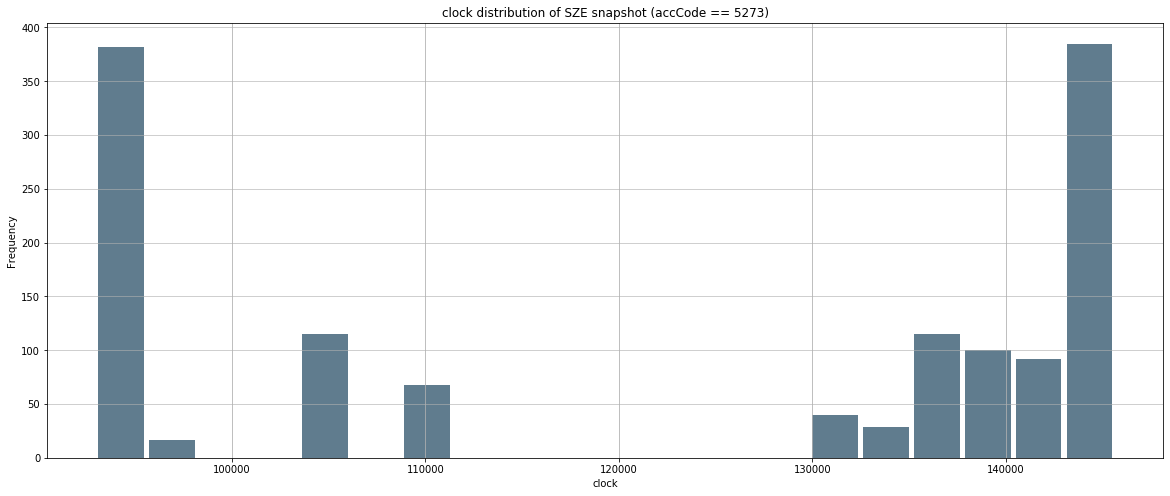

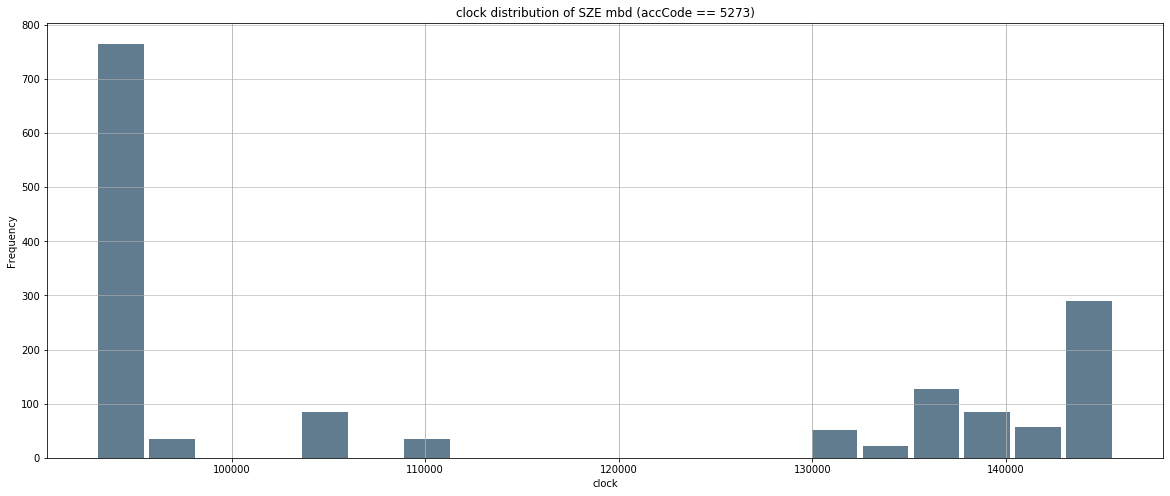

In [8]:
# check when did those account stop mbd
display(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == 20200831) & (orderLog["accCode"] == 5273) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).describe().astype(int))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 8))
orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 0) & (orderLog["date"] == 20200831) & (orderLog["accCode"] == 5273) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('clock distribution of SZE snapshot (accCode == 5273)')
plt.xlabel('clock')
plt.grid(axis='y', alpha=0.75)
display(orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 1) & (orderLog["date"] == 20200831) & (orderLog["accCode"] == 5273) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).describe().astype(int))
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 8))
orderLog[(orderLog["exchange"] == "SZE") & (orderLog["isMsg"] == 1) & (orderLog["date"] == 20200831) & (orderLog["accCode"] == 5273) 
         & (orderLog["updateType"] == 0)]["clock"].apply(lambda x: int(x.strftime('%H%M%S'))).plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('clock distribution of SZE mbd (accCode == 5273)')
plt.xlabel('clock')
plt.grid(axis='y', alpha=0.75)

In [84]:
t1 = orderLog[(orderLog["colo_broker"] == "zs_97") & (orderLog["exchange"] == "SSE") & (orderLog["updateType"] == 0)].groupby("accCode")["orderNtl"].sum().reset_index()
t2 = orderLog[(orderLog["colo_broker"] == "zs_97") & (orderLog["exchange"] == "SSE") & (orderLog["updateType"] == 4)].groupby("accCode")["tradeNtl"].sum().reset_index()
t3 = orderLog[(orderLog["colo_broker"] == "zs_97") & (orderLog["exchange"] == "SSE") & (orderLog["updateType"] == 4)].groupby(["date","accCode"])["tradeNtl"].sum().reset_index()
t3 = t3.groupby("accCode").mean().reset_index()
tt = pd.merge(t1, t2, on="accCode")
tt = pd.merge(tt, t3, on="accCode")
tt["prob"] = tt["tradeNtl_x"] / tt["orderNtl"]
tt

,accCode,orderNtl,tradeNtl_x,date,tradeNtl_y,prob
0,9741,2.330487e+08,1.908932e+08,20200516.5,1.908932e+07,0.819113
1,9754,1.238807e+07,6.326555e+06,20200520.5,1.581639e+06,0.510697


In [14]:
display(orderLog[orderLog["updateType"] == 0].shape[0])
display(len(orderLog["order"].unique()))
orderLog["num"] = orderLog.groupby("group")["order"].transform('nunique')
testLog = orderLog[orderLog["num"] >=2]
testLog1 = orderLog[orderLog["num"] == 1]
display(testLog.groupby("group")["order"].nunique().sum())
display(testLog[testLog['exchange'] == 'SSE'].groupby("group")["order"].nunique().sum() / 
        orderLog[(orderLog["updateType"] == 0) & (orderLog["exchange"] == "SSE")].shape[0])

display(testLog[(testLog['exchange'] == 'SSE') & (testLog["updateType"] == 0)]["orderNtl"].sum()/ 
        orderLog[(orderLog['exchange'] == 'SSE') & (orderLog["updateType"] == 0)]["orderNtl"].sum())

display(testLog[testLog['exchange'] == 'SZE'].groupby("group")["order"].nunique().sum() / 
        orderLog[(orderLog["updateType"] == 0) & (orderLog["exchange"] == "SZE")].shape[0])
display(testLog[testLog["updateType"] == 0]["orderNtl"].sum() / orderLog[orderLog["updateType"] == 0]["orderNtl"].sum())
display(len(testLog["group"].unique()))
display(testLog.groupby("group")["order"].nunique().describe([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]))
a = testLog[(testLog['exchange'] == 'SSE') & (testLog['updateType'] == 0)]['orderNtl'].sum()
b = testLog[(testLog['exchange'] == 'SSE') & (testLog['updateType'] == 4)]['tradeNtl'].sum()
print('SSE %.0f%%'%(b/a*100))
a = testLog[(testLog['exchange'] == 'SZE') & (testLog['updateType'] == 0)]['orderNtl'].sum()
b = testLog[(testLog['exchange'] == 'SZE') & (testLog['updateType'] == 4)]['tradeNtl'].sum()
print('SZE %.0f%%'%(b/a*100))
a = testLog1[(testLog1['exchange'] == 'SSE') & (testLog1['updateType'] == 0)]['orderNtl'].sum()
b = testLog1[(testLog1['exchange'] == 'SSE') & (testLog1['updateType'] == 4)]['tradeNtl'].sum()
print('SSE %.0f%%'%(b/a*100))
a = testLog1[(testLog1['exchange'] == 'SZE') & (testLog1['updateType'] == 0) & (testLog1["ars"] != 21)]['orderNtl'].sum()
b = testLog1[(testLog1['exchange'] == 'SZE') & (testLog1['updateType'] == 4) & (testLog1["ars"] != 21)]['tradeNtl'].sum()
print('SZE %.0f%%'%(b/a*100))
a = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 0)]['orderNtl'].sum()
b = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 4)]['tradeNtl'].sum()
print('SSE %.0f%%'%(b/a*100))

a = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 0)]['orderNtl'].sum()
b = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 4)]['tradeNtl'].sum()
print('SZE %.0f%%'%(b/a*100))

192715

192715

93650

0.494236100977674

0.5265551234331323

0.4806276207684178

0.5012560062688011

36462

count    36462.000000
mean         2.568427
std          0.938216
min          2.000000
1%           2.000000
10%          2.000000
20%          2.000000
30%          2.000000
40%          2.000000
50%          2.000000
60%          2.000000
70%          3.000000
80%          3.000000
90%          4.000000
99%          6.000000
max         12.000000
Name: order, dtype: float64

SSE 76%
SZE 75%
SSE 97%
SZE 95%
SSE 86%
SZE 85%


In [7]:
print('SZE')
totalAccount = orderLog[orderLog['secid'] >= 2000000]['accCode'].unique()
for date, dateLog in orderLog[orderLog['secid'] >= 2000000].groupby(['date']):
    dailyAccount = dateLog['accCode'].unique()
    print(date, sorted(list(set(totalAccount) - set(dailyAccount))))
print(totalAccount)
print('SSE')
totalAccount = orderLog[orderLog['secid'] < 2000000]['accCode'].unique()
for date, dateLog in orderLog[orderLog['secid'] < 2000000].groupby(['date']):
    dailyAccount = dateLog['accCode'].unique()
    print(date, sorted(list(set(totalAccount) - set(dailyAccount))))
print(totalAccount)

SZE
20201009 [6634, 8833, 523201]
20201012 [6634, 8833]
20201013 [6237, 6282, 6634]
20201014 [6634, 8924]
20201015 [6634, 8924]
20201016 [8924]
20201019 [8924]
20201020 []
20201021 []
20201022 []
20201023 [6237, 6282]
[  8967   8970   5281   5284   9765   9655   6480   5275   6623   6627
   9471   6683   5287   8865   8854   5225   5273   6631   5230   5290
   9756   5222   5226   9454   9741   5276   5289   5377   6282   6237
   9754   5386 896702   9758   9685   5470   5474   5269   9243   9451
   5291   8924 966301   9208   8971   5456   5229   6678   9448   9461
 523201   8833   6634]
SSE
20201009 [8833, 8924, 9756, 523201, 527101, 896702, 966701, 968501, 974101]
20201012 [8833, 8924, 9756, 527101, 896702, 974101]
20201013 [6237, 6282, 8924, 9561, 527101, 896702, 974101, 975602]
20201014 [8924, 9561, 522401, 522501, 523101, 527101, 527103, 527501, 527701, 528101, 528901, 529001, 529101, 896702, 974101, 975602]
20201015 [8924, 9561, 9741, 527101, 896702, 975602]
20201016 [8924, 9741

In [9]:
orderLog[(orderLog["updateType"] == 0)].groupby(["exchange", "colo", "accCode"])["isMsg"].size()

exchange  colo      accCode
SSE       zs_88_04  8967        1636
          zs_94_04  6237        3920
          zs_96_06  9765        2631
                    975602     14095
          zs_96_08  6282        3688
                    9741        9830
                    9754        8550
          zt_52_01  524201      1173
          zt_52_04  522201      2997
                    522601      5943
                    526901     10158
                    527301      6049
                    528401      7694
          zt_52_05  522901       499
                    527501      4360
                    527601     18297
                    528701      6657
                    537403      4779
          zt_52_07  523001       178
                    527103      1989
                    527701     10317
                    528101      6339
                    537401       857
          zt_52_10  522401      5843
                    522501      9331
                    528901      6018
          

In [19]:
orderLog[(orderLog['colo_broker'] == 'zs_64') & (orderLog['exchange']=='SSE')]

,Unnamed: 0,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,tradeId,sdd,aaa,ApplSeqNum,clock,broker,colo_broker,order,group,startClock,duration,orderDirection1,orderNtl,directNum,isMsg,status,exchange,tradeNtl,num
642105,66483,1594794185026777,0,1600103,0,-1,-1.0,0,-1,200,0,2.0,-1.00,20200715,6479,0,zs_64_01,NaN,NaN,-1.0,-1.0,0.0,2020-07-15 14:23:05.026777,64,zs_64,140123,95621,1594794185026777,0,-1,400.0,1,0.0,0,SSE,0.0,1
642106,66484,1594794185243243,0,1600103,2,-1,-1.0,0,-1,200,0,2.0,-1.00,20200715,6479,0,zs_64_01,00B2370438,NaN,-1.0,-1.0,0.0,2020-07-15 14:23:05.243243,64,zs_64,140123,95621,1594794185026777,216466,-1,400.0,1,0.0,0,SSE,0.0,1
642107,66485,1594794185444204,0,1600103,4,-1,-1.0,200,-1,200,200,2.0,2.05,20200715,6479,0,zs_64_01,NaN,2.8479e+07,-1.0,-1.0,0.0,2020-07-15 14:23:05.444204,64,zs_64,140123,95621,1594794185026777,417427,-1,400.0,1,0.0,0,SSE,410.0,1


In [21]:
a[(a['exchange'] == 'SSE') & (a['colo_broker'] == 'zs_64')]

,date,exchange,colo_broker,tradeNtl
149,20200715,SSE,zs_64,410.0


In [8]:
a = orderLog.groupby(['date', 'exchange', 'colo_broker'])['tradeNtl'].sum().reset_index()
l = len(orderLog["date"].unique())
exchangeTurnover = a.groupby(['date', 'exchange'])['tradeNtl'].sum().reset_index()
exchangeTurnover = exchangeTurnover.groupby(['exchange'])['tradeNtl'].mean().reset_index()
exchangeTurnover['tradeNtl'] = (exchangeTurnover['tradeNtl']/10000).astype('int64')
exchangeTurnover.columns = ['exchange', 'exchange turnover']
exchangeTurnover = pd.merge(a, exchangeTurnover, how='left', on=['exchange'], validate='many_to_one')
pp = exchangeTurnover.groupby(['exchange', 'exchange turnover', 'colo_broker'])["tradeNtl"].count().reset_index()
exchangeTurnover = (exchangeTurnover.groupby(['exchange', 'exchange turnover', 'colo_broker'])['tradeNtl'].mean()/10000).astype('int64').reset_index()
exchangeTurnover.columns = ['exchange', 'exchange turnover', 'colo_broker', 'turnover']
exchangeTurnover = pd.merge(exchangeTurnover, pp, on=['exchange', 'exchange turnover', 'colo_broker'])
exchangeTurnover['turnover %'] = (exchangeTurnover['turnover'] *  exchangeTurnover['tradeNtl'])/ (exchangeTurnover['exchange turnover']*l)
exchangeTurnover = exchangeTurnover.rename(columns={'colo_broker': 'broker'})
exchangeTurnover = exchangeTurnover.groupby(['exchange', 'exchange turnover', 'broker'])[['turnover', 'turnover %']].first()
exchangeTurnover['turnover %'] = exchangeTurnover['turnover %'].apply(lambda x: '%.1f%%'%(100*x))

from IPython.display import display, HTML
display(HTML(exchangeTurnover.to_html()))

In [32]:
exchangeTurnover[(exchangeTurnover['colo_broker'] == 'zs_64') & (exchangeTurnover['exchange'] == 'SSE')]['tradeNtl'].mean()/10000

0.040999999999999995

In [9]:
a = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 0)]['orderNtl'].sum()
b = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 4)]['tradeNtl'].sum()
print('SSE %.0f%%'%(b/a*100))

a = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 0)]['orderNtl'].sum()
b = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 4)]['tradeNtl'].sum()
print('SZE %.0f%%'%(b/a*100))

SSE 70%
SZE 74%


In [10]:
a = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 0) & (orderLog['colo_broker'] == 'zt_52')]['orderNtl'].sum()
b = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 4) & (orderLog['colo_broker'] == 'zt_52')]['tradeNtl'].sum()
print('SSE %.0f%%'%(b/a*100))

a = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 0) & (orderLog['colo_broker'] == 'zs_52')]['orderNtl'].sum()
b = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 4) & (orderLog['colo_broker'] == 'zs_52')]['tradeNtl'].sum()
print('SZE %.0f%%'%(b/a*100))

SSE 71%
SZE 78%


In [124]:
d1 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 0)].groupby(['date', 'exchange', 'colo_broker'])['orderNtl'].sum().reset_index()
d2 = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['updateType'] == 4)].groupby(['date', 'exchange', 'colo_broker'])['tradeNtl'].sum().reset_index()
d = pd.merge(d1, d2, on=['date', 'exchange', 'colo_broker'])
d['fill rate'] = d['tradeNtl'] / d['orderNtl']
# d = pd.pivot_table(d[['date', 'exchange', 'colo_broker', 'fill rate']], columns='date', index=['exchange', 'colo_broker'])
# for x in d.columns:
#     d[x] = d[x].apply(lambda x: '%.1f%%'%(100*x))
# d

In [125]:
d1 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 0)].groupby(['date', 'exchange', 'colo_broker'])['orderNtl'].sum().reset_index()
d2 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 4)].groupby(['date', 'exchange', 'colo_broker'])['tradeNtl'].sum().reset_index()
dd = pd.merge(d1, d2, on=['date', 'exchange', 'colo_broker'])
dd['fill rate'] = dd['tradeNtl'] / dd['orderNtl']
# d = pd.pivot_table(d[['date', 'exchange', 'colo_broker', 'fill rate']], columns='date', index=['exchange', 'colo_broker'])
# for x in d.columns:
#     d[x] = d[x].apply(lambda x: '%.1f%%'%(100*x))
# d

In [107]:
d

,date,exchange,colo_broker,orderNtl,tradeNtl,fill rate
0,20200803,SSE,zs_62,1.059447e+07,6.585920e+06,0.621637
1,20200803,SSE,zs_97,4.004557e+07,2.432643e+07,0.607469
2,20200803,SSE,zt_52,4.402287e+08,3.948212e+08,0.896855
3,20200803,SSE,zt_53,3.421670e+07,2.911163e+07,0.850802
4,20200803,SSE,zt_88,4.481571e+06,2.552983e+06,0.569663
...,...,...,...,...,...,...
363,20200917,SSE,zt_89,2.407750e+08,1.637757e+08,0.680202
364,20200917,SSE,zt_92,2.556906e+06,1.870693e+06,0.731624
365,20200917,SSE,zt_94,9.225730e+06,6.112821e+06,0.662584
366,20200917,SSE,zt_95,7.355877e+07,5.076533e+07,0.690133


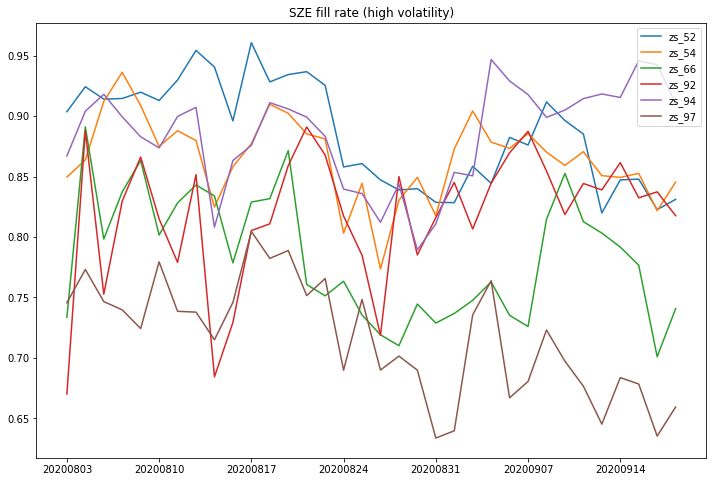

In [129]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
list1 = dd['colo_broker'].unique()
list1 = list(list1)
list1.remove('zs_52')
list1.remove('zs_54')
list1.remove('zs_66')
list1.remove('zs_92')
list1.remove('zs_94')
list1.remove('zs_97')

list1.remove('zs_96')
list1.remove('zt_88')
list1.remove('zt_96')
list1.remove('zs_64')
for i in ['zs_52', 'zs_54', 'zs_66', 'zs_92', 'zs_94', 'zs_97'] :
    ax.plot(dd[dd['colo_broker'] == i]['fill rate'].values, label=i)

ax.set_title('SZE fill rate (high volatility)')
indexLs = [i for i in range(dd[dd['colo_broker'] == 'zs_52'].shape[0])]
dateLs = [int(i) for i in dd[dd['colo_broker'] == 'zs_52']['date'].values]
ax.set_xticks(indexLs[::5])
ax.set_xticklabels(dateLs[::5])
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)


plt.show()

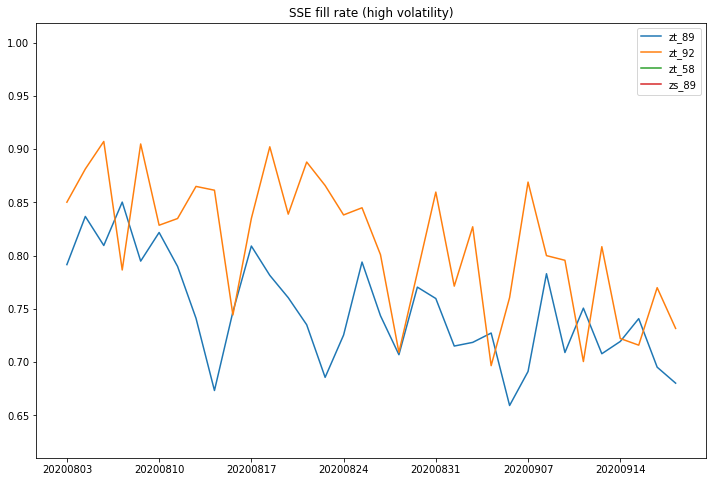

In [128]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
list1 = d['colo_broker'].unique()
list1 = list(list1)
list1.remove('zt_89')
list1.remove('zt_92')
list1.remove('zt_58')
list1.remove('zs_89')

list1.remove('zt_88')
list1.remove('zt_94')
list1.remove('zt_70')
for i in ['zt_89', 'zt_92', 'zt_58', 'zs_89']:
    ax.plot(d[d['colo_broker'] == i]['fill rate'].values, label=i)

ax.set_title('SSE fill rate (high volatility)')
indexLs = [i for i in range(d[d['colo_broker'] == 'zt_52'].shape[0])]
dateLs = [int(i) for i in d[d['colo_broker'] == 'zt_52']['date'].values]
ax.set_xticks(indexLs[::5])
ax.set_xticklabels(dateLs[::5])
fig.legend(loc=1, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)


plt.show()

In [86]:
list(list1).remove('zs_52')

['zs_53',
 'zs_54',
 'zs_62',
 'zs_64',
 'zs_66',
 'zs_88',
 'zs_89',
 'zs_92',
 'zs_94',
 'zs_96',
 'zs_97',
 'zt_88',
 'zt_89',
 'zt_96']

In [84]:
list 

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(211)
ax.plot(d[d['colo_broker'] == 'zs_52']['fill rate'].values)
ax.set_title('zs_52' + ' fill rate')
indexLs = [i for i in range(d[d['colo_broker'] == 'zs_52'].shape[0])]
dateLs = [int(i) for i in d[d['colo_broker'] == 'zs_52']['date'].values]
ax.set_xticks(indexLs[::5])
ax.set_xticklabels(dateLs[::5])
ax.set_ylim(0.65, 0.90)

ax = fig.add_subplot(212)
ax.plot(totalFillRate[totalFillRate['exchange'] == 'SZE']['fillRate'].values)
ax.set_title('SZE fill rate')
indexLs = [i for i in range(totalFillRate[totalFillRate['exchange'] == 'SZE'].shape[0])]
dateLs = [int(i) for i in totalFillRate[totalFillRate['exchange'] == 'SZE']['date'].values]
ax.set_xticks(indexLs[::5])
ax.set_xticklabels(dateLs[::5])
ax.set_ylim(0.65, 0.90);

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(211)
ax.plot(totalFillRate[totalFillRate['exchange'] == 'SSE']['fillRate'].values)
ax.set_title('SSE fill rate')
indexLs = [i for i in range(totalFillRate[totalFillRate['exchange'] == 'SSE'].shape[0])]
dateLs = [int(i) for i in totalFillRate[totalFillRate['exchange'] == 'SSE']['date'].values]
ax.set_xticks(indexLs[::5])
ax.set_xticklabels(dateLs[::5])
ax.set_ylim(0.65, 0.90)

ax = fig.add_subplot(212)
ax.plot(totalFillRate[totalFillRate['exchange'] == 'SZE']['fillRate'].values)
ax.set_title('SZE fill rate')
indexLs = [i for i in range(totalFillRate[totalFillRate['exchange'] == 'SZE'].shape[0])]
dateLs = [int(i) for i in totalFillRate[totalFillRate['exchange'] == 'SZE']['date'].values]
ax.set_xticks(indexLs[::5])
ax.set_xticklabels(dateLs[::5])
ax.set_ylim(0.65, 0.90);

In [42]:
d[['date', 'exchange', 'colo_broker', 'fill rate']]

,date,exchange,colo_broker,fill rate
0,20200817,SSE,zs_62,67.9%
1,20200817,SSE,zs_97,75.1%
2,20200817,SSE,zt_52,91.9%
3,20200817,SSE,zt_53,75.8%
4,20200817,SSE,zt_70,73.6%
...,...,...,...,...
215,20200911,SSE,zt_89,70.8%
216,20200911,SSE,zt_92,80.8%
217,20200911,SSE,zt_94,68.9%
218,20200911,SSE,zt_95,72.1%


In [16]:
a = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['sta'] == 'staone') & (orderLog['updateType'] == 0)]['orderNtl'].sum()
b = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['sta'] == 'staone') & (orderLog['updateType'] == 4)]['tradeNtl'].sum()
print('staone fill rate %.0f%%'%(b/a*100))

a = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['sta'] == 'statwo') & (orderLog['updateType'] == 0)]['orderNtl'].sum()
b = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['sta'] == 'statwo') & (orderLog['updateType'] == 4)]['tradeNtl'].sum()
print('statwo fill rate %.0f%%'%(b/a*100))

a = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['sta'] == 'staone') & (orderLog['updateType'] == 0)].shape[0]
b = orderLog[(orderLog['exchange'] == 'SSE') & (orderLog['sta'] == 'statwo') & (orderLog['updateType'] == 0)].shape[0]
print('statwo perc %.0f%%'%(b/(a+b)*100))

staone fill rate 68%
statwo fill rate 70%
statwo perc 75%


In [86]:
orderLog['cumFillSize'] = orderLog.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
orderLog['status'] = np.where(orderLog['cumFillSize'] == 0, '3. no filled', 
                                np.where(orderLog['cumFillSize'] < orderLog['absOrderSize'], '2. partial filled', '1. full filled'))
orderLog['sta'] = np.where(orderLog['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')

In [61]:
pd.Series(['zs_88', 'staone', 2, 0])

0     zs_88
1    staone
2         2
3         0
dtype: object

In [71]:
pd.DataFrame({'colo_broker':['zs_88'], 'sta':['staone'], 'status':[2], 'tradeNtl':[0]})

,colo_broker,sta,status,tradeNtl
0,zs_88,staone,2,0


In [73]:
pd.concat([da2, pd.DataFrame({'colo_broker':['zs_88'], 'sta':['staone'], 'status':[2], 'tradeNtl':[0]})], axis=0)

,colo_broker,sta,status,tradeNtl
0,zs_88,staone,0,1.147533e+06
1,zs_88,staone,1,3.951500e+04
2,zs_88,statwo,0,1.700496e+08
3,zs_88,statwo,1,1.675094e+07
4,zs_89,staone,0,8.614110e+07
5,zs_89,staone,1,6.935183e+06
6,zs_89,statwo,0,2.029666e+08
7,zs_89,statwo,1,2.955461e+07
0,zs_88,staone,2,0.000000e+00


In [87]:
d1 = orderLog[(orderLog['colo_broker'].isin(['zs_88', 'zs_89']))]
da1 = d1[d1['updateType'] == 0].groupby(['colo_broker', 'sta', 'status'])['orderNtl'].sum().reset_index()
da2 = d1[d1['updateType'] == 4].groupby(['colo_broker', 'sta', 'status'])['tradeNtl'].sum().reset_index()
da3 = d1[d1['updateType'] == 0].groupby(['colo_broker', 'sta', 'status'])['isMsg'].size().reset_index()
da3 = da3.rename(columns={'isMsg':"size"})
da3['size_sum'] = da3.groupby(['colo_broker', 'sta'])['size'].transform('sum')
da3['size_perc'] = da3['size'] / da3['size_sum']
da3['size_perc'] = da3['size_perc'].apply(lambda x: '%.1f%%'%(100*x))
da2 = pd.concat([da2, pd.DataFrame({'colo_broker':['zs_88'], 'sta':['staone'], 'status':['3. no filled'], 'tradeNtl':[0]}),
                pd.DataFrame({'colo_broker':['zs_88'], 'sta':['statwo'], 'status':['3. no filled'], 'tradeNtl':[0]}),
                pd.DataFrame({'colo_broker':['zs_89'], 'sta':['staone'], 'status':['3. no filled'], 'tradeNtl':[0]}),
                pd.DataFrame({'colo_broker':['zs_89'], 'sta':['statwo'], 'status':['3. no filled'], 'tradeNtl':[0]})], axis=0)
da = pd.merge(da1, da2, on=['colo_broker', 'sta', 'status'])
da = pd.merge(da, da3, on=['colo_broker', 'sta', 'status'])
da['perc'] = da['tradeNtl'] / da['orderNtl']
da['perc'] = da['perc'].apply(lambda x: '%.1f%%'%(100*x))
HTML(da.groupby(['colo_broker', 'sta', 'size_sum', 'status']).first().to_html())

In [81]:
orderLog[(orderLog['colo_broker'] == 'zs_88') & (orderLog['updateType'] == 0) & (orderLog['status'] == 2)].shape[0]

1307

In [39]:
orderLog[(orderLog['colo_broker'] == 'zs_88') & (orderLog['updateType'] == 0)].groupby(['colo', 'accCode', 'sta'])['isMsg'].size()

colo      accCode  sta   
zs_88_04  8865     staone      57
                   statwo    5728
Name: isMsg, dtype: int64

In [40]:
orderLog[(orderLog['colo_broker'] == 'zs_89') & (orderLog['updateType'] == 0)].groupby(['colo', 'accCode', 'sta'])['isMsg'].size()

colo      accCode  sta   
zs_88_04  8967     staone      29
                   statwo    2202
          896702   staone    1659
                   statwo     436
Name: isMsg, dtype: int64

In [31]:
orderLog[(orderLog['colo_broker'] == 'zs_88') & (orderLog['updateType'] == 0)].groupby(['colo', 'accCode', 'ars', 'status'])['isMsg'].size()

colo      accCode  ars    status
zs_88_04  8865     11.0   0           38
                          1            2
                          2           17
                   131.0  0         3921
                          1          353
                          2         1247
                   231.0  0          133
                          1           14
                          2           40
                   331.0  0           16
                          1            1
                          2            3
Name: isMsg, dtype: int64

In [32]:
orderLog[(orderLog['colo_broker'] == 'zs_89') & (orderLog['updateType'] == 0)].groupby(['colo', 'accCode', 'ars', 'status'])['isMsg'].size()

colo      accCode  ars    status
zs_88_04  8967     11.0   0           17
                          1            4
                          2            8
                   131.0  0         1627
                          1          144
                          2          381
                   231.0  0           26
                          1            2
                          2           10
                   331.0  0            9
                          1            1
                          2            2
          896702   11.0   0         1191
                          1          103
                          2          365
                   131.0  0          249
                          1           27
                          2          121
                   231.0  0           18
                          1            2
                          2            5
                   331.0  0           10
                          1            1
                        

In [37]:
orderLog[(orderLog['colo_broker'] == 'zs_53') & (orderLog['updateType'] == 0)]['orderDirection'].unique()

array([-1,  1], dtype=int64)

In [47]:
orderLog['sta'] = np.where(orderLog['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')

In [38]:
re1 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['colo_broker'] == 'zs_88') & (orderLog['updateType'] == 0)].groupby(['date', 'sta', 'isMsg', 'colo', 'accCode'])['orderNtl'].sum().reset_index()
re2 = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['colo_broker'] == 'zs_88') & (orderLog['updateType'] == 4)].groupby(['date', 'sta', 'isMsg', 'colo', 'accCode'])['tradeNtl'].sum().reset_index()
re = pd.merge(re1, re2, on=['date', 'sta', 'isMsg', 'colo', 'accCode'])
re['fill_rate'] = re['tradeNtl'] / re['orderNtl']
from IPython.display import display, HTML
HTML(re[(re['sta'] == 'staone') & (re['isMsg'] == 1)].groupby(['sta', 'isMsg', 'date', 'colo', 'accCode']).first().to_html())

In [14]:
ol = orderLog[(orderLog['updateType'] == 0) & (orderLog['sta'] == 'staone') 
              & (orderLog['exchange'] == 'SSE')]['order'].unique()
a = orderLog[(orderLog['updateType'] == 0) & (orderLog['order'].isin(ol))]['orderNtl'].sum()
b = orderLog[(orderLog['updateType'] == 4) & (orderLog['order'].isin(ol))]['tradeNtl'].sum()
print('SSE staone fill rate %.0f%%'%(b/a*100))

ol = orderLog[(orderLog['updateType'] == 0) & (orderLog['sta'] == 'staone') 
              & (orderLog['isMsg'] == 1) & (orderLog['exchange'] == 'SZE')]['order'].unique()
a = orderLog[(orderLog['updateType'] == 0) & (orderLog['order'].isin(ol))]['orderNtl'].sum()
b = orderLog[(orderLog['updateType'] == 4) & (orderLog['order'].isin(ol))]['tradeNtl'].sum()
print('SZE from mbd staone fill rate %.0f%%'%(b/a*100))

ol = orderLog[(orderLog['updateType'] == 0) & (orderLog['sta'] == 'statwo')]['order'].unique()
a = orderLog[(orderLog['updateType'] == 0) & (orderLog['order'].isin(ol))]['orderNtl'].sum()
b = orderLog[(orderLog['updateType'] == 4) & (orderLog['order'].isin(ol))]['tradeNtl'].sum()
print('statwo fill rate %.0f%%'%(b/a*100))

SSE staone fill rate 69%
SZE from mbd staone fill rate 70%
statwo fill rate 73%


### Compare with brokers -- by account

In [54]:
orderLog["server"] = orderLog["colo"].apply(lambda x: x.split("_")[0] + x.split("_")[1] + x.split("_")[2])
orderLog["server_account"] = orderLog["server"] + '_' + orderLog['accCode'].astype('str')
orderLog["colo_account"] = orderLog["colo"].str[:2] + '_' + orderLog['accCode'].astype('str')
orderLog["time"] = orderLog["clock"].apply(lambda x: x.strftime("%H%M%S")).astype(int)
orderLog['sta'] = np.where(orderLog['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')

In [185]:
l = orderLog[(orderLog["updateType"] == 0) & (orderLog["ars"].isin([121, 221, 321, 131, 231, 331])) & (orderLog["exchange"] == "SZE")]["accCode"].unique()
l

array([9754, 9765, 9756, 9471, 9454, 6272], dtype=int64)

In [196]:
l

array([9754, 9765, 9756, 9471, 9454, 6272], dtype=int64)

In [272]:
orderLog["time"].min()

92753

In [30]:
orderLog[(orderLog["updateType"] == 0) & (~orderLog["ars"].isin([121, 221, 321, 131, 231, 331])) & (orderLog["server_account"].isin(orderLog[(orderLog["updateType"] == 0) & (orderLog["ars"].isin([121, 221, 321, 131, 231, 331]))]["server_account"].unique()))].groupby(["exchange", "server_account"])["time"].describe()

count          mean          std      min       25%  \
exchange server_account                                                         
SSE      zs9608_6272      152.0  93310.092105  3390.654309  93000.0  93006.00   
         zs9608_9754      161.0  93030.919255    26.470969  93000.0  93011.00   
         zt5204_526901    894.0  93050.098434    33.546901  93008.0  93024.00   
         zt5204_527301    234.0  93054.346154    37.897250  93009.0  93023.25   
         zt5205_527501    882.0  93033.807256    27.180759  93003.0  93013.00   
         zt5205_527601   2151.0  93457.688052  4433.823852  93003.0  93013.00   
         zt8803_8970       93.0  93061.311828    36.992355  93018.0  93031.00   
         zt8803_8971      634.0  93067.908517   676.264859  93009.0  93021.00   
SZE      zs9405_9454     2317.0  93024.485542    21.232580  93002.0  93008.00   
         zs9405_9471     4766.0  93035.555392   615.814137  93002.0  93009.00   
         zs9606_9756     2257.0  93023.112096    69.836126  93000.0  93005.00   
         zs9606_9765     1663.0  93019.713770    17.113969  93000.0  93004.00   
         zs9608_6272      853.0  93021.759672    18.845609  93000.0  93005.00   
         zs9608_9754     1449.0  93021.501035    18.292895  92959.0  93006.00   
         zt8803_8970       31.0  93069.258065    39.994139  93017.0  93029.50   

                             50%       75%       max  
exchange server_account                               
SSE      zs9608_6272     93026.0  93054.25  134836.0  
         zs9608_9754     93025.0  93040.00   93101.0  
         zt5204_526901   93041.0  93057.00   93118.0  
         zt5204_527301   93040.0  93106.00   93117.0  
         zt5205_527501   93027.0  93045.00   93106.0  
         zt5205_527601   93026.0  93044.00  145649.0  
         zt8803_8970     93047.0  93107.00   93118.0  
         zt8803_8971     93032.0  93046.00  110035.0  
SZE      zs9405_9454     93018.0  93037.00   93103.0  
         zs9405_9471     93021.0  93040.00  135513.0  
         zs9606_9756     93015.0  93037.00   95954.0  
         zs9606_9765     93015.0  93032.00   93059.0  
         zs9608_6272     93016.0  93037.00   93059.0  
         zs9608_9754     93016.0  93035.00   93101.0  
         zt8803_8970     93057.0  93109.00   93117.0

In [59]:
orderLog["server"] = orderLog["colo"].apply(lambda x: x.split("_")[0] + x.split("_")[1] + x.split("_")[2])
orderLog["server_account"] = orderLog["server"] + '_' + orderLog['accCode'].astype('str')
checkLog = orderLog[orderLog['updateType'].isin([0, 3, 4])].reset_index(drop=True)
checkLog = checkLog[checkLog['duration'] <= 1e6]
# checkLog = checkLog[(checkLog["colo_broker"]!="zt_52")|((checkLog["colo_broker"] == "zt_52") & (checkLog["date"] >= 20200331))]
# checkLog = checkLog[(checkLog["accCode"]!=5242)|((checkLog["accCode"] == 5242) & (checkLog["date"] >= 20200409))]
# checkLog = checkLog[((checkLog["accCode"]!=5275) & (checkLog["exchange"] == "SSE"))|
#                     ((checkLog["accCode"] == 5275) & (checkLog["date"] >= 20200414) & (checkLog["exchange"] == "SSE"))|(checkLog["exchange"] == "SZE")]
# checkLog = checkLog[(checkLog["colo_broker"]!="zs_54")|((checkLog["colo_broker"] == "zs_54") & (checkLog["date"] >= 20200420))]
# checkLog = checkLog[(checkLog["accCode"]!=8856)|((checkLog["accCode"] == 8856) & (checkLog["date"] >= 20200423))]


# ol = checkLog[(checkLog["updateType"] == 0) & (~checkLog["ars"].isin([121, 221, 321, 131, 231, 331]))]["order"].unique()
# checkLog = checkLog[checkLog["order"].isin(ol)]
# checkLog = pd.concat([checkLog[~checkLog["colo_account"].isin(l)], checkLog[(checkLog["colo_account"].isin(l)) 
#                                                                               & (checkLog["time"] >= 93000) & (checkLog["time"] < 93300)]])

# checkLog = checkLog[(checkLog['sta'] == 'statwo')]
# checkLog = checkLog[(checkLog['sta'] == 'staone') & (checkLog['isMsg'] == 1)]
checkLog = checkLog[(checkLog['sta'] == 'statwo')]

checkLog['accountNum'] = checkLog.groupby(['date', 'secid', 'vai'])['server_account'].transform('nunique')
checkLog = checkLog[checkLog['accountNum'] >= 2]
checkLog['cumFillSize'] = checkLog.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
checkLog['status'] = np.where(checkLog['cumFillSize'] == 0, 2, 
                                np.where(checkLog['cumFillSize'] < checkLog['absOrderSize'], 1, 0))
checkLog = checkLog.groupby(['group', 'order'])[['date', 'server_account', 'secid', 'vai', 'status', 'server']].first().reset_index()

for exchg in ['SZE']:
    
    print(exchg)
    
    if exchg == 'SSE':
        exchangeLog = checkLog[checkLog['secid'] < 2000000]
    else:
        exchangeLog = checkLog[checkLog['secid'] >= 2000000]
    
    result = {}
    for col in ['date', 'broker1', 'broker2', 'isFast']:
        result[col] = []

    for group, groupData in exchangeLog.groupby(['group']):
        date = groupData['date'].values[0]
        brokerLs = groupData['server_account'].values
        if len(brokerLs) == 0:
            continue
        statusLs = groupData['status'].values
        ixLs = [i for i in range(len(brokerLs))]
        for k, broker1, status1 in zip(ixLs[:-1], brokerLs[:-1], statusLs[:-1]):
            for broker2, status2 in zip(brokerLs[k+1:], statusLs[k+1:]):
                if broker1 != broker2:
                    result['date'] += [date, date]
                    result['broker1'] += [broker1, broker2]
                    result['broker2'] += [broker2, broker1]

                    if status1 < status2:
                        result['isFast'] += [1, 0]
                    elif status1 > status2:
                        result['isFast'] += [0, 1]
                    else:
                        result['isFast'] += [-1, -1]                

    result = pd.DataFrame(result)
    result = result[result['isFast'] != -1]
    result['count'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('count')
    result['fasterSum'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
    result['faster'] = result['fasterSum']/result['count']

    
    summary = pd.DataFrame()
    summaryCols = []
    countCols = []
    fasterCols = []
    for date in result['date'].unique():
        a = result[result['date'] == date].reset_index(drop=True)
        a['count'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('count')
        a['fasterSum'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
        a['faster'] = a['fasterSum']/a['count']
        a = a.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
        a.columns = ['broker1', 'broker2', '%s count'%date, '%s faster'%date]
        summaryCols += ['%s count'%date, '%s faster'%date]
        countCols += ['%s count'%date]
        fasterCols += ['%s faster'%date]
        
        if summary.empty:
            summary = a.copy()
        else:
            summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
    
    a = result.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
    a.columns = ['broker1', 'broker2', 'total count', 'total faster']
    summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
    summaryCols = ['total count', 'total faster'] + summaryCols
    
    savePath = r'L:\orderLog\result\relativeSpeed'
    a = summary.groupby(['broker1', 'broker2'])[['total count', 'total faster']].first().reset_index()
    server_info = orderLog[["server_account", "server"]].drop_duplicates()
    a = pd.merge(a, server_info, how="left", left_on="broker1", right_on="server_account")
    a = a.rename(columns={"server":"server1"})
    a = pd.merge(a, server_info, how="left", left_on="broker2", right_on="server_account")
    a = a.rename(columns={"server":"server2"})
    a = a[["broker1", "broker2", "total count", "total faster", "server1", "server2"]]
    a.to_csv(os.path.join(savePath, 'relativeSpeedAccount_%s_%s_%s.csv'%(startDate, endDate, exchg)), index=False)
    
    summary['b1'] = summary['broker1'].str[7:11].astype(int) // 100
    summary['b2'] = summary['broker2'].str[7:11].astype(int) // 100
    countCols += ['total count']
    fasterCols += ['total faster']
    for col in countCols:
        summary[col] = summary[col].fillna(0)
        summary[col] = summary[col].astype('int64')
        
    for col in fasterCols:
        summary[col] = summary[col].fillna(-1)
        summary[col] = summary[col].apply(lambda x: '%.0f%%'%(x*100))
        summary[col] = np.where(summary[col] == '-100%', ' ', summary[col])
    
    summary["tt"]=summary[["broker1", "broker2"]].min(axis=1).astype(str) + ' - ' + summary[["broker1", "broker2"]].max(axis=1).astype(str)
    summary = summary.sort_values(by=["tt", "broker1"])
    s1 = summary.groupby("tt").first().reset_index(drop=True)
    display(s1[((s1['b1'] == 52)) | ((s1["b2"] == 52))][["broker1", "broker2", "total count", "total faster", 'b2', "b1"]].
            sort_values(by=['total count'], ascending=False).sort_values(by=["b1", "b2"]))
#     display(s1[((s1['b1'] == 92) & (s1['b2'] == 97))][["broker1", "broker2", "total count", "total faster", 'b2']].
#             sort_values(by=['total count'], ascending=False))
#     display(s1[(s1['broker1'] == 9248) | (s1['broker2'] == 9248)][["broker1", "broker2", "total count", "total faster", 'b2']].
#             sort_values(by=['total count'], ascending=False))
#     display(s1[(s1['broker1'] == 9741) | (s1['broker2'] == 9741)][["broker1", "broker2", "total count", "total faster", 'b2']].
#             sort_values(by=['total count'], ascending=False))

SZE


,broker1,broker2,total count,total faster,b2,b1
27,zs5206_5275,zs5206_5287,1421,55%,52,52
22,zs5206_5273,zs5209_5290,1312,19%,52,52
19,zs5206_5273,zs5206_5290,1233,61%,52,52
10,zs5206_5269,zs5206_5273,1000,39%,52,52
1,zs5206_5222,zs5206_5273,927,46%,52,52
...,...,...,...,...,...,...
110,zs5209_5225,zs9606_9756,92,97%,97,52
115,zs5209_5226,zs9606_9756,78,92%,97,52
96,zs5208_5291,zs9608_9754,19,100%,97,52
98,zs5208_5377,zs5209_5289,1780,0%,52,53


In [62]:
    display(s1[((s1['b1'] == 66) & (s1['b2'].isin([52, 96, 97]))) | ((s1["b2"] == 66)& (s1['b1'].isin([52, 96, 97])))][["broker1", "broker2", "total count", "total faster", 'b2', "b1"]].
            sort_values(by=['total count'], ascending=False).sort_values(by=["b1", "b2"]))

,broker1,broker2,total count,total faster,b2,b1
48,zs5206_5287,zs6601_6683,1815,40%,66,52
30,zs5206_5275,zs6601_6683,403,55%,66,52
28,zs5206_5275,zs6601_6623,224,4%,66,52
46,zs5206_5287,zs6601_6623,124,10%,66,52
63,zs5208_5276,zs6601_6678,101,55%,66,52
128,zs5209_5291,zs6601_6678,90,34%,66,52
118,zs5209_5289,zs6601_6678,33,64%,66,52
41,zs5206_5286,zs6601_6678,28,89%,66,52
87,zs5208_5289,zs6601_6678,28,100%,66,52
93,zs5208_5291,zs6601_6678,9,100%,66,52


In [16]:
display(s1[((s1['broker1'] == 'zt5201_524201')) | ((s1["broker2"] == 'zt5201_524201'))][["broker1", "broker2", "total count", "total faster", 'b2', "b1"]].
            sort_values(by=['total count'], ascending=False).sort_values(by=["b1", "b2"]))

,broker1,broker2,total count,total faster,b2,b1
44,zt5201_524201,zt5204_527301,28,36%,52,52
43,zt5201_524201,zt5201_527101,15,40%,52,52
45,zt5201_524201,zt5205_537403,16,94%,53,52
46,zt5201_524201,zt7001_7079,14,100%,70,52
47,zt5201_524201,zt8803_897002,21,86%,89,52
48,zt5201_524201,zt8803_8971,3,100%,89,52
49,zt5201_524201,zt9401_9441,17,53%,94,52
51,zt5201_524201,zt9609_966501,25,32%,96,52
50,zt5201_524201,zt9601_966501,16,12%,96,52
2,zs9404_6237,zt5201_524201,27,4%,52,62


In [39]:
orderLog['sta'] = np.where(orderLog['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
orderLog["server"] = orderLog["colo"].apply(lambda x: x.split("_")[0] + x.split("_")[1] + x.split("_")[2])
orderLog["server_account"] = orderLog["server"] + '_' + orderLog['accCode'].astype('str')
checkLog = orderLog[orderLog['updateType'].isin([0, 3, 4])].reset_index(drop=True)
checkLog = checkLog[checkLog['duration'] <= 1e6]

checkLog["time"] = checkLog["clock"].apply(lambda x: x.strftime("%H%M%S")).astype(int)
# ol = checkLog[(checkLog["updateType"] == 0) & (~checkLog["ars"].isin([121, 221, 321, 131, 231, 331])) & (checkLog["time"]>= 93000)
#              & (checkLog["time"] < 93300)]["order"].unique()
checkLog = checkLog[(checkLog['sta'] == 'statwo')]


# checkLog = checkLog[(checkLog["accCode"]!=5242)|((checkLog["accCode"] == 5242) & (checkLog["date"] >= 20200409))]
# checkLog = checkLog[((checkLog["accCode"]!=5275) & (checkLog["exchange"] == "SSE"))|
#                     ((checkLog["accCode"] == 5275) & (checkLog["date"] >= 20200414) & (checkLog["exchange"] == "SSE"))|(checkLog["exchange"] == "SZE")]
# checkLog = checkLog[(checkLog["colo_broker"]!="zs_54")|((checkLog["colo_broker"] == "zs_54") & (checkLog["date"] >= 20200420))]
# checkLog = checkLog[(checkLog["accCode"]!=8856)|((checkLog["accCode"] == 8856) & (checkLog["date"] >= 20200423))]


checkLog['accountNum'] = checkLog.groupby(['date', 'secid', 'vai'])['server_account'].transform('nunique')
checkLog = checkLog[checkLog['accountNum'] >= 2]
checkLog['cumFillSize'] = checkLog.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
checkLog['status'] = np.where(checkLog['cumFillSize'] == 0, 2, 
                                np.where(checkLog['cumFillSize'] < checkLog['absOrderSize'], 1, 0))
checkLog = checkLog.groupby(['group', 'order'])[['date', 'server_account', 'secid', 'vai', 'status']].first().reset_index()


for exchg in ['SZE']:
    
    print(exchg)
    
    if exchg == 'SSE':
        exchangeLog = checkLog[checkLog['secid'] < 2000000]
    else:
        exchangeLog = checkLog[checkLog['secid'] >= 2000000]
    
    result = {}
    for col in ['date', 'broker1', 'broker2', 'isFast']:
        result[col] = []

    for group, groupData in exchangeLog.groupby(['group']):
        date = groupData['date'].values[0]
        brokerLs = groupData['server_account'].values
        if len(brokerLs) == 0:
            continue
        statusLs = groupData['status'].values
        ixLs = [i for i in range(len(brokerLs))]
        for k, broker1, status1 in zip(ixLs[:-1], brokerLs[:-1], statusLs[:-1]):
            for broker2, status2 in zip(brokerLs[k+1:], statusLs[k+1:]):
                if broker1 != broker2:
                    result['date'] += [date, date]
                    result['broker1'] += [broker1, broker2]
                    result['broker2'] += [broker2, broker1]

                    if status1 < status2:
                        result['isFast'] += [1, 0]
                    elif status1 > status2:
                        result['isFast'] += [0, 1]
                    else:
                        result['isFast'] += [-1, -1]                

    result = pd.DataFrame(result)
    result = result[result['isFast'] != -1]
    result['count'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('count')
    result['fasterSum'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
    result['faster'] = result['fasterSum']/result['count']

    
    summary = pd.DataFrame()
    summaryCols = []
    countCols = []
    fasterCols = []
    for date in result['date'].unique():
        a = result[result['date'] == date].reset_index(drop=True)
        a['count'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('count')
        a['fasterSum'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
        a['faster'] = a['fasterSum']/a['count']
        a = a.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
        a.columns = ['broker1', 'broker2', '%s count'%date, '%s faster'%date]
        summaryCols += ['%s count'%date, '%s faster'%date]
        countCols += ['%s count'%date]
        fasterCols += ['%s faster'%date]
        
        if summary.empty:
            summary = a.copy()
        else:
            summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
    
    a = result.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
    a.columns = ['broker1', 'broker2', 'total count', 'total faster']
    summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
    summaryCols = ['total count', 'total faster'] + summaryCols
    
    
    savePath = r'L:\orderLog\result\relativeSpeed'
    a = summary.groupby(['broker1', 'broker2'])[['total count', 'total faster']].first().reset_index()
    a.to_csv(os.path.join(savePath, 'relativeSpeedAccount_%s_%s_%s.csv'%(startDate, endDate, exchg)), index=False)



    
    countCols += ['total count']
    fasterCols += ['total faster']
    summary['b1'] = summary['broker1'].str[7:11].astype(int) // 100
    summary['b2'] = summary['broker2'].str[7:11].astype(int) // 100
#     summary = summary.groupby(['broker1', 'broker2'])[summaryCols].first()
    for col in countCols:
        summary[col] = summary[col].fillna(0)
        summary[col] = summary[col].astype('int64')
        
    for col in fasterCols:
        summary[col] = summary[col].fillna(-1)
        summary[col] = summary[col].apply(lambda x: '%.0f%%'%(x*100))
        summary[col] = np.where(summary[col] == '-100%', ' ', summary[col])
    
#     summary = summary.rename(columns={"broker1":"account1", "broker2":"account2"})
#     summary = summary.groupby(['account1', 'account2'])[summaryCols].first()
#     from IPython.display import display, HTML
#     display(HTML(summary.iloc[:, :2].to_html()))
#     summary["tt"]=summary[["broker1", "broker2"]].min(axis=1).astype(str) + ' - ' + summary[["broker1", "broker2"]].max(axis=1).astype(str)
#     summary = summary.sort_values(by=["tt", "broker1"])
#     s1 = summary.groupby("tt").first().reset_index(drop=True)
    s1 = summary
    display(s1[(s1["broker1"] == 'zs5209_5289') & (s1['b2'] == 52)])

SZE


,broker1,broker2,20200914 count,20200914 faster,20200915 count,20200915 faster,20200916 count,20200916 faster,20200917 count,20200917 faster,20200918 count,20200918 faster,20200921 count,20200921 faster,20200922 count,20200922 faster,20200923 count,20200923 faster,20200924 count,20200924 faster,20200925 count,20200925 faster,20200928 count,20200928 faster,20200929 count,20200929 faster,20200930 count,20200930 faster,total count,total faster,b1,b2
99,zs5209_5289,zs5208_5276,130,92%,123,94%,126,90%,171,84%,107,83%,66,80%,145,88%,119,92%,115,85%,174,93%,44,86%,117,85%,179,90%,1616,88%,52,52
100,zs5209_5289,zs5208_5286,79,96%,64,92%,87,92%,136,94%,71,87%,94,78%,140,86%,63,97%,88,93%,134,96%,0,,0,,0,,956,91%,52,52
102,zs5209_5289,zs5209_5291,43,60%,26,77%,44,75%,46,61%,22,59%,62,52%,48,65%,12,58%,47,62%,41,68%,39,28%,27,67%,48,79%,505,62%,52,52
367,zs5209_5289,zs5208_5229,0,,0,,0,,0,,0,,0,,0,,0,,0,,56,79%,91,70%,78,72%,139,73%,364,73%,52,52


In [68]:
server_list = list(set(orderLog[orderLog['sta'] == 'staone']['server_broker'].unique()) - 
                   set(orderLog[orderLog['sta'] == 'statwo']['server_broker'].unique()))
server_list

['zt8802_88',
 'zt5201_52',
 'zs9602_96',
 'zt9402_95',
 'zs9403_94',
 'zs9201_92',
 'zt9601_96',
 'zs9404_62',
 'zt9402_94',
 'zt9201_92',
 'zs9202_92',
 'zs6401_64',
 'zs5401_54']

In [66]:
orderLog[orderLog['sta'] == 'statwo']['server_broker'].unique()

array(['zt9609_96', 'zt5210_52', 'zt5204_52', 'zt7001_70', 'zt8803_89',
       'zs9608_97', 'zt5205_53', 'zt5205_52', 'zt5207_52', 'zs9606_97',
       'zt5207_53', 'zs9608_62', 'zs5208_52', 'zs8804_89', 'zs5206_52',
       'zs9405_94', 'zs5209_52', 'zs5208_53', 'zs8804_88', 'zs6601_66',
       'zs9608_96'], dtype=object)

In [77]:
# compare speed by server (staone only server, statwo server)
orderLog['sta'] = np.where(orderLog['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
orderLog["server"] = orderLog["colo"].apply(lambda x: x.split("_")[0] + x.split("_")[1] + x.split("_")[2])
orderLog["server_account"] = orderLog["server"] + '_' + orderLog['accCode'].astype('str')
orderLog["server_broker"] = orderLog["server"] + '_' + orderLog['accCode'].astype('str').str[:2]
checkLog = orderLog[orderLog['updateType'].isin([0, 3, 4])].reset_index(drop=True)
checkLog = checkLog[checkLog['duration'] <= 1e6]

checkLog["time"] = checkLog["clock"].apply(lambda x: x.strftime("%H%M%S")).astype(int)
# ol = checkLog[(checkLog["updateType"] == 0) & (~checkLog["ars"].isin([121, 221, 321, 131, 231, 331])) & (checkLog["time"]>= 93000)
#              & (checkLog["time"] < 93300)]["order"].unique()
staone_list = list(set(orderLog[orderLog['sta'] == 'staone']['server_broker'].unique()) - 
                   set(orderLog[orderLog['sta'] == 'statwo']['server_broker'].unique()))
checkLog = checkLog[(checkLog['sta'] == 'statwo')]


# checkLog = checkLog[(checkLog["accCode"]!=5242)|((checkLog["accCode"] == 5242) & (checkLog["date"] >= 20200409))]
# checkLog = checkLog[((checkLog["accCode"]!=5275) & (checkLog["exchange"] == "SSE"))|
#                     ((checkLog["accCode"] == 5275) & (checkLog["date"] >= 20200414) & (checkLog["exchange"] == "SSE"))|(checkLog["exchange"] == "SZE")]
# checkLog = checkLog[(checkLog["colo_broker"]!="zs_54")|((checkLog["colo_broker"] == "zs_54") & (checkLog["date"] >= 20200420))]
# checkLog = checkLog[(checkLog["accCode"]!=8856)|((checkLog["accCode"] == 8856) & (checkLog["date"] >= 20200423))]


checkLog['accountNum'] = checkLog.groupby(['date', 'secid', 'vai'])['server_broker'].transform('nunique')
checkLog = checkLog[checkLog['accountNum'] >= 2]
checkLog['cumFillSize'] = checkLog.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
checkLog['status'] = np.where(checkLog['cumFillSize'] == 0, 2, 
                                np.where(checkLog['cumFillSize'] < checkLog['absOrderSize'], 1, 0))
checkLog = checkLog.groupby(['group', 'order'])[['date', 'server_broker', 'secid', 'vai', 'status']].first().reset_index()


for exchg in ['SZE']:
    
    print(exchg)
    
    if exchg == 'SSE':
        exchangeLog = checkLog[checkLog['secid'] < 2000000]
    else:
        exchangeLog = checkLog[checkLog['secid'] >= 2000000]
    
    result = {}
    for col in ['date', 'broker1', 'broker2', 'isFast']:
        result[col] = []

    for group, groupData in exchangeLog.groupby(['group']):
        date = groupData['date'].values[0]
        brokerLs = groupData['server_broker'].values
        if len(brokerLs) == 0:
            continue
        statusLs = groupData['status'].values
        ixLs = [i for i in range(len(brokerLs))]
        for k, broker1, status1 in zip(ixLs[:-1], brokerLs[:-1], statusLs[:-1]):
            for broker2, status2 in zip(brokerLs[k+1:], statusLs[k+1:]):
                if broker1 != broker2:
                    result['date'] += [date, date]
                    result['broker1'] += [broker1, broker2]
                    result['broker2'] += [broker2, broker1]

                    if status1 < status2:
                        result['isFast'] += [1, 0]
                    elif status1 > status2:
                        result['isFast'] += [0, 1]
                    else:
                        result['isFast'] += [-1, -1]                

    result = pd.DataFrame(result)
    result = result[result['isFast'] != -1]
    result['count'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('count')
    result['fasterSum'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
    result['faster'] = result['fasterSum']/result['count']

    
    summary = pd.DataFrame()
    summaryCols = []
    countCols = []
    fasterCols = []
    for date in result['date'].unique():
        a = result[result['date'] == date].reset_index(drop=True)
        a['count'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('count')
        a['fasterSum'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
        a['faster'] = a['fasterSum']/a['count']
        a = a.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
        a.columns = ['broker1', 'broker2', '%s count'%date, '%s faster'%date]
        summaryCols += ['%s count'%date, '%s faster'%date]
        countCols += ['%s count'%date]
        fasterCols += ['%s faster'%date]
        
        if summary.empty:
            summary = a.copy()
        else:
            summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
    
    a = result.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
    a.columns = ['broker1', 'broker2', 'total count', 'total faster']
    summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
    summaryCols = ['total count', 'total faster'] + summaryCols
    
    
    savePath = r'L:\orderLog\result\relativeSpeed'
    a = summary.groupby(['broker1', 'broker2'])[['total count', 'total faster']].first().reset_index()
    a.to_csv(os.path.join(savePath, 'relativeSpeedAccount_%s_%s_%s.csv'%(startDate, endDate, exchg)), index=False)



    
    countCols += ['total count']
    fasterCols += ['total faster']
    summary['b1'] = summary['broker1'].str[-2:].astype(int)
    summary['b2'] = summary['broker2'].str[7:11].astype(int)
#     summary = summary.groupby(['broker1', 'broker2'])[summaryCols].first()
    for col in countCols:
        summary[col] = summary[col].fillna(0)
        summary[col] = summary[col].astype('int64')
        
    for col in fasterCols:
        summary[col] = summary[col].fillna(-1)
        summary[col] = summary[col].apply(lambda x: '%.0f%%'%(x*100))
        summary[col] = np.where(summary[col] == '-100%', ' ', summary[col])
    
#     summary = summary.rename(columns={"broker1":"account1", "broker2":"account2"})
#     summary = summary.groupby(['account1', 'account2'])[summaryCols].first()
#     from IPython.display import display, HTML
#     display(HTML(summary.iloc[:, :2].to_html()))
#     summary["tt"]=summary[["broker1", "broker2"]].min(axis=1).astype(str) + ' - ' + summary[["broker1", "broker2"]].max(axis=1).astype(str)
#     summary = summary.sort_values(by=["tt", "broker1"])
#     s1 = summary.groupby("tt").first().reset_index(drop=True)
    s1 = summary

SZE


In [79]:
s1[(s1['b1'] == 52) & (s1['b2'] == 52)]

,broker1,broker2,20200914 count,20200914 faster,20200915 count,20200915 faster,20200916 count,20200916 faster,20200917 count,20200917 faster,20200918 count,20200918 faster,20200921 count,20200921 faster,20200922 count,20200922 faster,20200923 count,20200923 faster,20200924 count,20200924 faster,20200925 count,20200925 faster,20200928 count,20200928 faster,20200929 count,20200929 faster,20200930 count,20200930 faster,total count,total faster,b1,b2
0,zs5206_52,zs5209_52,1469,6%,1309,8%,1690,5%,1697,8%,1525,10%,1472,9%,1769,7%,1508,5%,2125,8%,2371,10%,1993,11%,1929,11%,2601,9%,23458,8%,52,52
8,zs5208_52,zs5209_52,284,8%,242,8%,316,11%,437,16%,220,17%,266,20%,386,13%,219,7%,300,11%,455,13%,225,22%,247,21%,397,20%,3994,14%,52,52
24,zs5209_52,zs5206_52,1469,94%,1309,92%,1690,95%,1697,92%,1525,90%,1472,91%,1769,93%,1508,95%,2125,92%,2371,90%,1993,89%,1929,89%,2601,91%,23458,92%,52,52
25,zs5209_52,zs5208_52,284,92%,242,92%,316,89%,437,84%,220,83%,266,80%,386,87%,219,93%,300,89%,455,87%,225,78%,247,79%,397,80%,3994,86%,52,52


In [40]:
display(s1[(s1["broker1"] == 'zs5209_5226') & (s1['b2'] == 52)])

,broker1,broker2,20200914 count,20200914 faster,20200915 count,20200915 faster,20200916 count,20200916 faster,20200917 count,20200917 faster,20200918 count,20200918 faster,20200921 count,20200921 faster,20200922 count,20200922 faster,20200923 count,20200923 faster,20200924 count,20200924 faster,20200925 count,20200925 faster,20200928 count,20200928 faster,20200929 count,20200929 faster,20200930 count,20200930 faster,total count,total faster,b1,b2
90,zs5209_5226,zs5206_5222,283,98%,230,96%,329,97%,292,98%,301,92%,321,94%,324,97%,317,99%,336,98%,408,97%,323,96%,358,97%,375,96%,4197,96%,52,52
91,zs5209_5226,zs5206_5269,37,97%,44,91%,75,96%,50,94%,78,97%,63,95%,55,93%,28,100%,49,98%,58,90%,98,84%,41,85%,44,80%,720,92%,52,52
92,zs5209_5226,zs5206_5273,191,96%,111,97%,188,98%,180,97%,152,97%,158,97%,172,97%,160,98%,183,97%,229,95%,170,95%,155,92%,205,91%,2254,96%,52,52
93,zs5209_5226,zs5209_5225,133,48%,67,22%,124,50%,95,46%,116,48%,103,53%,116,44%,112,46%,113,49%,162,46%,116,48%,98,49%,165,45%,1520,46%,52,52
94,zs5209_5226,zs5209_5290,113,48%,69,54%,137,53%,156,63%,81,49%,156,53%,149,52%,97,55%,111,50%,139,60%,109,61%,103,62%,163,49%,1583,55%,52,52
356,zs5209_5226,zs5209_5230,0,,0,,0,,0,,0,,0,,0,,0,,0,,58,43%,106,43%,122,38%,205,21%,491,33%,52,52


In [41]:
checkLog = orderLog[orderLog['updateType'].isin([0, 3, 4])].reset_index(drop=True)
checkLog = checkLog[checkLog['duration'] <= 3e6]
ol = checkLog[(checkLog["updateType"] == 0) & (~checkLog["ars"].isin([121, 221, 321, 131, 231, 331]))]["order"].unique()
checkLog = checkLog[checkLog["order"].isin(ol)]

a = checkLog.groupby(['date', 'exchange', 'server_account'])['tradeNtl'].sum().reset_index()
l = len(orderLog["date"].unique())
exchangeTurnover = a.groupby(['date', 'exchange'])['tradeNtl'].sum().reset_index()
exchangeTurnover = exchangeTurnover.groupby(['exchange'])['tradeNtl'].mean().reset_index()
exchangeTurnover['tradeNtl'] = (exchangeTurnover['tradeNtl']/10000).astype('int64')
exchangeTurnover.columns = ['exchange', 'exchange turnover']
exchangeTurnover = pd.merge(a, exchangeTurnover, how='left', on=['exchange'], validate='many_to_one')
pp = exchangeTurnover.groupby(['exchange', 'exchange turnover', 'server_account'])["tradeNtl"].count().reset_index()
exchangeTurnover = (exchangeTurnover.groupby(['exchange', 'exchange turnover', 'server_account'])['tradeNtl'].mean()/10000).astype('int64').reset_index()
exchangeTurnover.columns = ['exchange', 'exchange turnover', 'server_account', 'turnover']
exchangeTurnover = pd.merge(exchangeTurnover, pp, on=['exchange', 'exchange turnover', 'server_account'])
exchangeTurnover['turnover %'] = (exchangeTurnover['turnover'] *  exchangeTurnover['tradeNtl'])/ (exchangeTurnover['exchange turnover']*l)
exchangeTurnover['turnover %'] = exchangeTurnover['turnover %'].apply(lambda x: '%.1f%%'%(100*x))

summary["tt"]=summary[["broker1", "broker2"]].min(axis=1).astype(str) + ' - ' + summary[["broker1", "broker2"]].max(axis=1).astype(str)
summary = summary.sort_values(by=["tt", "total faster"])
s1 = summary.groupby("tt").last().reset_index(drop=True)
s1 = s1[s1["b1"] == s1["b2"]]
s1["exchange"] = exchg
s1 = s1[["exchange", "broker1", "broker2", "total count", "total faster", 'b1']]
s1 = s1.rename(columns={"b1": "broker", "broker1":"account1", "broker2":"account2"})
s1 = pd.merge(s1, exchangeTurnover[["exchange", "server_account", 'turnover %']], left_on=["exchange", "account1"], right_on=["exchange", "server_account"])
s1 = s1.rename(columns={"turnover %": "perc1"})
s1 = pd.merge(s1, exchangeTurnover[["exchange", "server_account", 'turnover %']], left_on=["exchange", "account2"], right_on=["exchange", "server_account"])
s1 = s1.rename(columns={"turnover %": "perc2"})
s1["account1"] = s1["account1"] + ' (' + s1["perc1"] + ')'
s1["account2"] = s1["account2"] + ' (' + s1["perc2"] + ')'
from IPython.display import display, HTML
HTML(s1.groupby(["broker", 'account1', 'account2'])[["total count", "total faster"]].first().to_html())
# display(summary[(summary["b1"] == 88) & (summary["b2"] == 88)][["broker1", "broker2", "total count", "total faster"]].sort_values(by="total count", ascending=False))
# display(summary[(summary["b1"] == 96) & (summary["b2"] == 96)][["broker1", "broker2", "total count", "total faster"]].sort_values(by="total count", ascending=False))

In [138]:
display(s1[(s1["broker1"] == 'zs5209_5291') & (s1['broker2'] == 'zs5208_5286')])

,broker1,broker2,20200831 count,20200831 faster,20200901 count,20200901 faster,20200902 count,20200902 faster,20200903 count,20200903 faster,20200904 count,20200904 faster,20200907 count,20200907 faster,20200908 count,20200908 faster,20200909 count,20200909 faster,20200910 count,20200910 faster,20200911 count,20200911 faster,total count,total faster,b1,b2
298,zs5209_5291,zs5208_5286,0,,0,,0,,0,,0,,0,,0,,0,,20,60%,29,90%,49,78%,52,52


In [94]:
s1[((s1["b1"] == 52) & (s1["broker1"].str[:4].isin(['zs52'])) & (s1["broker2"].str[:4].isin(['zs52'])) & (s1['b2'].isin([52])))].sort_values(by=['b2', 'total faster'])[['broker1', 'broker2', 'total count', 'total faster']]

,broker1,broker2,total count,total faster
14,zs5206_5269,zs5209_5225,4,0%
15,zs5206_5269,zs5209_5226,1,0%
48,zs5206_5286,zs5208_5291,1,0%
50,zs5206_5286,zs5209_5289,16,0%
51,zs5206_5286,zs5209_5291,2,0%
16,zs5206_5269,zs5209_5290,35,11%
26,zs5206_5273,zs5209_5226,33,15%
27,zs5206_5273,zs5209_5290,203,17%
3,zs5206_5222,zs5209_5226,44,18%
2,zs5206_5222,zs5209_5225,21,19%


In [26]:
orderLog[(orderLog['accCode'].isin([527301, 527101, 537403, 524201])) & (orderLog['exchange'] == 'SSE') & 
         (orderLog['updateType'] == 0)].groupby('accCode')['ars'].unique()

accCode
524201                                [11.0]
527101                                [11.0]
527301    [131.0, 231.0, 11.0, 331.0, 121.0]
537403                                [11.0]
Name: ars, dtype: object

In [32]:
thisStartDate = '20200720'
thisEndDate = '20200814'

prevStartDate = '20200706'
prevEndDate = '20200717'

readPath = r'L:\orderLog\result\relativeSpeed'
thisResult = []
for exchg in ['SSE', 'SZE']:
    data = pd.read_csv(os.path.join(readPath, 'relativeSpeedAccount_%s_%s_%s.csv'%(thisStartDate, thisEndDate, exchg)))
    data['exchange'] = exchg
    thisResult += [data]
thisResult = pd.concat(thisResult).reset_index(drop=True)
# thisResult['broker1_broker2'] = thisResult[['broker1', 'broker2']].min(axis=1).astype(str) + ' - ' + thisResult[['broker1', 'broker2']].max(axis=1).astype(str)
# thisResult = thisResult.drop_duplicates(subset=['exchange', 'broker1_broker2'], keep='first')
thisResult = thisResult.rename(columns = {'total count': 'thisCount', 'total faster': 'curFaster'})
thisResult = thisResult[['exchange', 'broker1', 'broker2', 'thisCount', 'curFaster']]

prevResult = []
for exchg in ['SSE', 'SZE']:
    data = pd.read_csv(os.path.join(readPath, 'relativeSpeedAccount_%s_%s_%s.csv'%(prevStartDate, prevEndDate, exchg)))
    data['exchange'] = exchg
    prevResult += [data]
prevResult = pd.concat(prevResult).reset_index(drop=True)
# prevResult['broker1_broker2'] = prevResult[['broker1', 'broker2']].min(axis=1).astype(str) + ' - ' + prevResult[['broker1', 'broker2']].max(axis=1).astype(str)
# prevResult = prevResult.drop_duplicates(subset=['exchange', 'broker1_broker2'], keep='first')
prevResult = prevResult.rename(columns = {'total count': 'prevCount', 'total faster': 'prevFaster'})
prevResult = prevResult[['exchange', 'broker1', 'broker2', 'prevCount', 'prevFaster']]

checkResult = pd.merge(thisResult, prevResult, how='outer', on=['exchange', 'broker1', 'broker2'], validate='one_to_one')
checkResult['speedDif'] = checkResult['curFaster'] - checkResult['prevFaster']
kk = checkResult[(checkResult['broker1'] == 'zs9606_9765') | (checkResult['broker2'] == 'zs9606_9765')].groupby(['exchange', 'broker1', 'broker2'])[['prevCount', 'prevFaster', 'thisCount', 'curFaster','speedDif']].first()
for col in ['curFaster', 'prevFaster', 'speedDif']:
    kk[col] = kk[col].apply(lambda x: '%.0f%%'%(x*100))
display(HTML(kk.to_html()))
kk = checkResult[(checkResult['broker1'] == 'zs9606_9756') | (checkResult['broker2'] == 'zs9606_9756')].groupby(['exchange', 'broker1', 'broker2'])[['prevCount', 'prevFaster', 'thisCount', 'curFaster','speedDif']].first()
for col in ['curFaster', 'prevFaster', 'speedDif']:
    kk[col] = kk[col].apply(lambda x: '%.0f%%'%(x*100))
display(HTML(kk.to_html()))
kk = checkResult[(checkResult['broker1'] == 'zs9606_9758') | (checkResult['broker2'] == 'zs9606_9758')].groupby(['exchange', 'broker1', 'broker2'])[['prevCount', 'prevFaster', 'thisCount', 'curFaster','speedDif']].first()
for col in ['curFaster', 'prevFaster', 'speedDif']:
    kk[col] = kk[col].apply(lambda x: '%.0f%%'%(x*100))
display(HTML(kk.to_html()))
kk = checkResult[(checkResult['broker1'] == 'zs9602_9741') | (checkResult['broker2'] == 'zs9602_9741')].groupby(['exchange', 'broker1', 'broker2'])[['prevCount', 'prevFaster', 'thisCount', 'curFaster','speedDif']].first()
for col in ['curFaster', 'prevFaster', 'speedDif']:
    kk[col] = kk[col].apply(lambda x: '%.0f%%'%(x*100))
display(HTML(kk.to_html()))
kk = checkResult[(checkResult['broker1'] == 'zs9608_9754') | (checkResult['broker2'] == 'zs9608_9754')].groupby(['exchange', 'broker1', 'broker2'])[['prevCount', 'prevFaster', 'thisCount', 'curFaster','speedDif']].first()
for col in ['curFaster', 'prevFaster', 'speedDif']:
    kk[col] = kk[col].apply(lambda x: '%.0f%%'%(x*100))
display(HTML(kk.to_html()))
# checkResult = checkResult[(abs(checkResult['speedDif']) > 0.15) & (checkResult['thisCount'] > 100)
#                          & (checkResult['prevCount'] > 100)].groupby(['exchange', 'broker1', 'broker2'])[['prevCount', 'prevFaster', 'thisCount', 'curFaster','speedDif']].first()
# for col in ['curFaster', 'prevFaster', 'speedDif']:
#     checkResult[col] = checkResult[col].apply(lambda x: '%.0f%%'%(x*100))
# display(HTML(checkResult.to_html()))

In [22]:
orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['colo'] == 'zs_96_08')]['accCode'].unique()

array([9754, 6282], dtype=int64)

In [19]:
orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['colo_broker'] == 'zs_97')]['colo'].unique()

array(['zs_96_06', 'zs_96_02', 'zs_96_08'], dtype=object)

In [17]:
orderLog.head(1)

,Unnamed: 0,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,l4tr,internalId,clock,broker,colo_broker,order,group,startClock,duration,orderDirection1,orderNtl,directNum,isMsg,status,exchange,tradeNtl
0,78049,1595209143963219,1595209143963076,1600004,0,3407963,131.0,0,-1,1400,0,14.8,-1.0,20200720,527501,22,zt_52_05,NaN,NaN,93902000.0,0.000798,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-20 09:39:03.963219,52,zt_52,20857,0,1595209143963219,0,-1,20720.0,1,0.0,0,SSE,0.0


In [85]:
checkResult[(checkResult['exchange'] == 'SSE') & (checkResult['broker1'].str[:4] == 'zt52') & (checkResult['broker2'].str[:4] == 'zt88')]

,exchange,broker1,broker2,thisCount,curFaster,prevCount,prevFaster,speedDif
32,SSE,zt5201_524201,zt8803_897002,41.0,0.634146,10.0,0.500000,0.134146
33,SSE,zt5201_524201,zt8803_8971,4.0,0.500000,2.0,0.500000,0.000000
39,SSE,zt5201_527101,zt8803_897002,116.0,0.767241,52.0,0.769231,-0.001989
40,SSE,zt5201_527101,zt8803_8971,19.0,0.789474,10.0,0.700000,0.089474
45,SSE,zt5204_526901,zt8802_8854,81.0,0.814815,64.0,0.656250,0.158565
46,SSE,zt5204_526901,zt8803_8943,65.0,0.784615,38.0,0.710526,0.074089
50,SSE,zt5204_527301,zt8803_897002,71.0,0.732394,22.0,0.727273,0.005122
51,SSE,zt5204_527301,zt8803_8971,28.0,0.821429,5.0,0.800000,0.021429
56,SSE,zt5205_527501,zt8803_8970,62.0,0.806452,56.0,0.732143,0.074309
57,SSE,zt5205_527501,zt8803_8971,62.0,0.806452,48.0,0.687500,0.118952


In [20]:
orderLog[(orderLog["exchange"] == 'SZE') & (orderLog['updateType'] == 0) & (~orderLog["ars"].isin([121, 221, 321, 131, 231, 331]))].groupby('accCode')['colo'].unique()

accCode
5273      [zs_52_02, zs_52_06]
5275      [zs_52_02, zs_52_06]
5276                [zs_52_02]
5277                [zs_52_02]
5456                [zs_54_01]
5470                [zs_54_01]
5474                [zs_54_01]
6237                [zs_94_04]
6272                [zs_96_08]
6479                [zs_64_01]
6678                [zs_66_01]
8854                [zt_88_02]
8856                [zs_88_01]
8865                [zs_88_01]
8867                [zs_88_01]
8970      [zt_88_02, zt_88_03]
8971                [zt_88_03]
9208                [zs_92_01]
9243                [zs_92_02]
9448                [zs_94_03]
9451                [zs_94_03]
9454                [zs_94_05]
9461                [zs_94_03]
9471                [zs_94_05]
9754                [zs_96_08]
9756                [zs_96_06]
9758                [zs_96_06]
9765                [zs_96_06]
885602              [zs_88_01]
966301              [zt_96_01]
Name: colo, dtype: object

In [19]:
orderLog[(orderLog["exchange"] == 'SZE') & (orderLog['updateType'] == 0) & (~orderLog["ars"].isin([121, 221, 321, 131, 231, 331]))].groupby(['colo', 'accCode'])['vai'].size()

colo      accCode
zs_52_02  5273       1361
          5275       1128
          5276       1674
          5277       1843
zs_52_06  5273       2239
          5275       1993
zs_54_01  5456       1919
          5470        955
          5474       3877
zs_64_01  6479        679
zs_66_01  6678        542
zs_88_01  8856        237
          8865       2259
          8867       2189
          885602      447
zs_92_01  9208       1509
zs_92_02  9243       1357
zs_94_03  9448       1102
          9451       2333
          9461        553
zs_94_04  6237        700
zs_94_05  9454        391
          9471        917
zs_96_06  9756        727
          9758        235
          9765        363
zs_96_08  6272        106
          9754        519
zt_88_02  8854       1722
          8970        115
zt_88_03  8970         35
          8971         34
zt_96_01  966301      716
Name: vai, dtype: int64

In [26]:
orderLog["server"] = orderLog["colo"].apply(lambda x: x.split("_")[0] + x.split("_")[1] + x.split("_")[2])
orderLog["server_account"] = orderLog["server"] + '_' + orderLog['accCode'].astype('str')
checkLog = orderLog[orderLog['updateType'].isin([0, 3, 4])].reset_index(drop=True)
checkLog = checkLog[checkLog['duration'] <= 1e6]
checkLog["time"] = checkLog["clock"].apply(lambda x: x.strftime("%H%M%S")).astype(int)

ol = checkLog[(checkLog["updateType"] == 0) & (~checkLog["ars"].isin([121, 221, 321, 131, 231, 331])) & (checkLog["time"]>= 93000)
             & (checkLog["time"] < 93300)]["order"].unique()
display(len(ol))
checkLog = checkLog[checkLog["order"].isin(ol)]
checkLog = checkLog[checkLog["server_account"].isin(["zt5203_527701", "zt5205_527601"])]

167489

In [27]:
checkLog["tradeNtl1"] = checkLog.groupby("order")["tradeNtl"].transform('sum')
checkLog["orderNtl1"] = checkLog.groupby('order')["orderNtl"].transform('first')
checkLog = checkLog.groupby('order').first()
re = checkLog.groupby('server_account')[["tradeNtl1", 'orderNtl1']].sum()
re['perc'] = re["tradeNtl1"]/re["orderNtl1"]
re

,tradeNtl1,orderNtl1,perc
server_account,,,
zt5203_527701,2.559803e+08,3.223209e+08,0.794178
zt5205_527601,6.640606e+07,1.161698e+08,0.571629


In [ ]:
a = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 0)]['orderNtl'].sum()
b = orderLog[(orderLog['exchange'] == 'SZE') & (orderLog['updateType'] == 4)]['tradeNtl'].sum()
print('SZE %.0f%%'%(b/a*100))

In [104]:
orderLog["server"] = orderLog["colo"].apply(lambda x: x.split("_")[0] + x.split("_")[1] + x.split("_")[2])
orderLog["server_account"] = orderLog["server"] + '_' + orderLog['accCode'].astype('str')
checkLog = orderLog[orderLog['updateType'].isin([0, 3, 4])].reset_index(drop=True)
checkLog = checkLog[checkLog['duration'] <= 1e6]


ol = checkLog[(checkLog["updateType"] == 0) & (~checkLog["ars"].isin([121, 221, 321, 131, 231, 331]))]["order"].unique()
display(len(ol))
checkLog = checkLog[checkLog["order"].isin(ol)]

checkLog['accountNum'] = checkLog.groupby(['date', 'secid', 'vai'])['server_account'].transform('nunique')
checkLog = checkLog[checkLog['accountNum'] >= 2]
checkLog['cumFillSize'] = checkLog.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
checkLog['status'] = np.where(checkLog['cumFillSize'] == 0, 2, 
                                np.where(checkLog['cumFillSize'] < checkLog['absOrderSize'], 1, 0))
checkLog1 = checkLog.groupby(['group', 'order'])[['date', 'server_account', 'secid', 'vai', 'status']].first().reset_index()
display(checkLog1)

orderLog["server"] = orderLog["colo"].apply(lambda x: x.split("_")[0] + x.split("_")[1] + x.split("_")[2])
orderLog["server_account"] = orderLog["server"] + '_' + orderLog['accCode'].astype('str')
checkLog11 = orderLog[orderLog['updateType'].isin([0, 3, 4])].reset_index(drop=True)
checkLog11 = checkLog11[checkLog11['duration'] <= 3e6]


ol = checkLog11[(checkLog11["updateType"] == 0) & (~checkLog11["ars"].isin([121, 221, 321, 131, 231, 331]))]["order"].unique()
display(len(ol))
checkLog11 = checkLog11[checkLog11["order"].isin(ol)]


checkLog11['accountNum'] = checkLog11.groupby(['date', 'secid', 'vai'])['server_account'].transform('nunique')
checkLog11 = checkLog11[checkLog11['accountNum'] >= 2]
checkLog11['cumFillSize'] = checkLog11.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
checkLog11['status'] = np.where(checkLog11['cumFillSize'] == 0, 2, 
                                np.where(checkLog11['cumFillSize'] < checkLog11['absOrderSize'], 1, 0))
checkLog11 = checkLog11.groupby(['group', 'order'])[['date', 'server_account', 'secid', 'vai', 'status']].first().reset_index()
display(checkLog11)

167489

,group,order,date,server_account,secid,vai,status
0,5,8719,20200525,zt8802_8970,1600004,15204966,2
1,5,14498,20200525,zt9402_9561,1600004,15204966,2
2,5,18319,20200525,zt5201_527401,1600004,15204966,0
3,5,18503,20200525,zt5203_527501,1600004,15204966,1
4,5,21567,20200525,zt9604_966701,1600004,15204966,2
...,...,...,...,...,...,...,...
91947,146491,202389,20200605,zs8801_8865,2300788,317200,2
91948,146494,198197,20200605,zs5401_5456,2300788,319200,0
91949,146494,202390,20200605,zs8801_8865,2300788,319200,2
91950,146495,198198,20200605,zs5401_5456,2300788,320800,2


167489

,group,order,date,server_account,secid,vai,status
0,5,8719,20200525,zt8802_8970,1600004,15204966,2
1,5,14498,20200525,zt9402_9561,1600004,15204966,2
2,5,18319,20200525,zt5201_527401,1600004,15204966,0
3,5,18503,20200525,zt5203_527501,1600004,15204966,1
4,5,21567,20200525,zt9604_966701,1600004,15204966,2
...,...,...,...,...,...,...,...
91947,146491,202389,20200605,zs8801_8865,2300788,317200,2
91948,146494,198197,20200605,zs5401_5456,2300788,319200,0
91949,146494,202390,20200605,zs8801_8865,2300788,319200,2
91950,146495,198198,20200605,zs5401_5456,2300788,320800,0


In [97]:
checkLog1[(checkLog1["date"] == 20200526) & (checkLog1["group"] == 19449)]

,group,order,date,server_account,secid,vai,status
14769,19449,40614,20200526,zt5205_527601,1603991,226900,0
14770,19449,41198,20200526,zt5203_527701,1603991,226900,0


In [98]:
checkLog11[(checkLog11["date"] == 20200526) & (checkLog11["group"] == 19449)]

,group,order,date,server_account,secid,vai,status
14769,19449,40614,20200526,zt5205_527601,1603991,226900,0
14770,19449,41198,20200526,zt5203_527701,1603991,226900,0


In [121]:
result = {}
for col in ['date', 'broker1', 'broker2', 'isFast']:
    result[col] = []
for group, groupData in checkLog1[checkLog1["server_account"].isin(["zt5207_527701","zt5205_527601"])].groupby(['group']):
    brokerLs = groupData['server_account'].values
    if len(brokerLs) != 0:
        date = groupData['date'].values[0]
        statusLs = groupData['status'].values
        ixLs = [i for i in range(len(brokerLs))]
        for k, broker1, status1 in zip(ixLs[:-1], brokerLs[:-1], statusLs[:-1]):
            for broker2, status2 in zip(brokerLs[k+1:], statusLs[k+1:]):
                if broker1 != broker2:
                    result['date'] += [date, date]
                    result['broker1'] += [broker1, broker2]
                    result['broker2'] += [broker2, broker1]

                    if status1 < status2:
                        result['isFast'] += [1, 0]
                    elif status1 > status2:
                        result['isFast'] += [0, 1]
                    else:
                        result['isFast'] += [-1, -1]                

result = pd.DataFrame(result)
result['count'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('count')
result['fasterSum'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
result['faster'] = result['fasterSum']/result['count']

summary = pd.DataFrame()
summaryCols = []
countCols = []
fasterCols = []
for date in result['date'].unique():
    a = result[result['date'] == date].reset_index(drop=True)
    a['count'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('count')
    a['fasterSum'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
    a['faster'] = a['fasterSum']/a['count']
    a = a.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
    a.columns = ['broker1', 'broker2', '%s count'%date, '%s faster'%date]
    summaryCols += ['%s count'%date, '%s faster'%date]
    countCols += ['%s count'%date]
    fasterCols += ['%s faster'%date]
        
    if summary.empty:
        summary = a.copy()
    else:
        summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
    
a = result.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
a.columns = ['broker1', 'broker2', 'total count', 'total faster']
summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
summaryCols = ['total count', 'total faster'] + summaryCols
   



    
countCols += ['total count']
fasterCols += ['total faster']
summary['b1'] = summary['broker1'].str[7:11].astype(int) // 100
summary['b2'] = summary['broker2'].str[7:11].astype(int) // 100
#     summary = summary.groupby(['broker1', 'broker2'])[summaryCols].first()
for col in countCols:
    summary[col] = summary[col].fillna(0)
    summary[col] = summary[col].astype('int64')
        
for col in fasterCols:
    summary[col] = summary[col].fillna(-1)
    summary[col] = summary[col].apply(lambda x: '%.0f%%'%(x*100))
    summary[col] = np.where(summary[col] == '-100%', ' ', summary[col])
    
summary

NameError: name 'checkLog1' is not defined

In [88]:
groupData = checkLog11[checkLog11["date"] == 20200526]
result = {}
for col in ['date', 'broker1', 'broker2', 'isFast']:
    result[col] = []
brokerLs = groupData['server_account'].values
if len(brokerLs) != 0:
    statusLs = groupData['status'].values
    ixLs = [i for i in range(len(brokerLs))]
    for k, broker1, status1 in zip(ixLs[:-1], brokerLs[:-1], statusLs[:-1]):
        for broker2, status2 in zip(brokerLs[k+1:], statusLs[k+1:]):
            if broker1 != broker2:
                result['date'] += [date, date]
                result['broker1'] += [broker1, broker2]
                result['broker2'] += [broker2, broker1]

                if status1 < status2:
                    result['isFast'] += [1, 0]
                elif status1 > status2:
                    result['isFast'] += [0, 1]
                else:
                    result['isFast'] += [-1, -1]                

result = pd.DataFrame(result)
result

,date,broker1,broker2,isFast
0,20200605,zt5205_527601,zt5203_527701,0
1,20200605,zt5203_527701,zt5205_527601,1
2,20200605,zt5205_527601,zt5203_527701,0
3,20200605,zt5203_527701,zt5205_527601,1
4,20200605,zt5205_527601,zt5203_527701,0
...,...,...,...,...
149947,20200605,zt5203_527701,zt5205_527601,-1
149948,20200605,zt5203_527701,zt5205_527601,-1
149949,20200605,zt5205_527601,zt5203_527701,-1
149950,20200605,zt5205_527601,zt5203_527701,-1


In [83]:
checkLog1 = checkLog1[checkLog1["server_account"].isin(["zt5203_527701", "zt5205_527601"])]
display(checkLog1.shape[0])
checkLog11 = checkLog11[checkLog11["server_account"].isin(["zt5203_527701", "zt5205_527601"])]
display(checkLog11.shape[0])

5144

5144

In [71]:
re = pd.merge(checkLog1, checkLog11, on="order")

In [76]:
re

,group_x,order,date_x,server_account_x,secid_x,vai_x,status_x,group_y,date_y,server_account_y,secid_y,vai_y,status_y
0,150,19826,20200525,zt5203_527701,1600070,84000,2,150,20200525,zt5203_527701,1600070,84000,2
1,152,19827,20200525,zt5203_527701,1600070,8757536,0,152,20200525,zt5203_527701,1600070,8757536,0
2,193,19828,20200525,zt5203_527701,1600080,107100,0,193,20200525,zt5203_527701,1600080,107100,0
3,197,19830,20200525,zt5203_527701,1600088,1338440,2,197,20200525,zt5203_527701,1600088,1338440,2
4,207,19831,20200525,zt5203_527701,1600088,1823840,0,207,20200525,zt5203_527701,1600088,1823840,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5139,136149,215854,20200605,zt5205_527601,1603991,26000,1,136149,20200605,zt5205_527601,1603991,26000,0
5140,136149,216577,20200605,zt5203_527701,1603991,26000,0,136149,20200605,zt5203_527701,1603991,26000,0
5141,136152,215856,20200605,zt5205_527601,1603991,31600,0,136152,20200605,zt5205_527601,1603991,31600,0
5142,136152,216579,20200605,zt5203_527701,1603991,31600,0,136152,20200605,zt5203_527701,1603991,31600,0


In [56]:
re = pd.merge(checkLog1, checkLog11, on=["order"], how="outer")
re[re["status_x"] == re["status_y"]]

,group_x,order,date_x,server_account_x,secid_x,vai_x,status_x,group_y,date_y,server_account_y,secid_y,vai_y,status_y
0,5,8719,20200525,zt8802_8970,1600004,15204966,2,5,20200525,zt8802_8970,1600004,15204966,2
1,5,14498,20200525,zt9402_9561,1600004,15204966,2,5,20200525,zt9402_9561,1600004,15204966,2
2,5,18319,20200525,zt5201_527401,1600004,15204966,0,5,20200525,zt5201_527401,1600004,15204966,0
3,5,18503,20200525,zt5203_527501,1600004,15204966,1,5,20200525,zt5203_527501,1600004,15204966,1
4,5,21567,20200525,zt9604_966701,1600004,15204966,2,5,20200525,zt9604_966701,1600004,15204966,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91946,146491,198194,20200605,zs5401_5456,2300788,317200,0,146491,20200605,zs5401_5456,2300788,317200,0
91947,146491,202389,20200605,zs8801_8865,2300788,317200,2,146491,20200605,zs8801_8865,2300788,317200,2
91948,146494,198197,20200605,zs5401_5456,2300788,319200,0,146494,20200605,zs5401_5456,2300788,319200,0
91949,146494,202390,20200605,zs8801_8865,2300788,319200,2,146494,20200605,zs8801_8865,2300788,319200,2


In [52]:
checkLog11[checkLog11["order"] == 21569]

,Unnamed: 0,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,tradeId,sdd,aaa,ApplSeqNum,clock,broker,colo_broker,order,group,startClock,duration,orderDirection1,orderNtl,directNum,isMsg,status,exchange,tradeNtl,server,server_account,accountNum,cumFillSize
46,84179,1590370229299767,1590370229299738,1600009,0,76300,11,0,-1,600,0,65.33,-1.00,20200525,966701,9,zt_96_04,NaN,NaN,93027000,0.000677,0,2020-05-25 09:30:29.299767,96,zt_96,21569,9,1590370229299767,0,-1,39198.0,1,0.0,1,SSE,0.0,zt9604,zt9604_966701,2,300
47,84184,1590370230503321,1590370230284611,1600009,4,76300,11,300,-1,600,300,65.33,65.33,20200525,966701,0,zt_96_04,7.214280662193285e+17,5241,-1,-1.000000,0,2020-05-25 09:30:30.503321,96,zt_96,21569,9,1590370229299767,1203554,-1,39198.0,1,0.0,1,SSE,19599.0,zt9604,zt9604_966701,2,300


In [51]:
checkLog[checkLog["order"] == 21569]

,Unnamed: 0,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,tradeId,sdd,aaa,ApplSeqNum,clock,broker,colo_broker,order,group,startClock,duration,orderDirection1,orderNtl,directNum,isMsg,status,exchange,tradeNtl,server,server_account,accountNum,cumFillSize
46,84179,1590370229299767,1590370229299738,1600009,0,76300,11,0,-1,600,0,65.33,-1.0,20200525,966701,9,zt_96_04,NaN,NaN,93027000,0.000677,0,2020-05-25 09:30:29.299767,96,zt_96,21569,9,1590370229299767,0,-1,39198.0,1,0.0,2,SSE,0.0,zt9604,zt9604_966701,2,0


In [51]:
orderLog[(orderLog["server_account"] == "zs9405_9454") & (orderLog["exchange"] == "SZE") & (orderLog["updateType"] == 0)].groupby(["date", "ars"])["vai"].count()

date      ars
20200525  11     281
          131    580
          231      9
20200526  11     225
          131    464
          231      4
20200527  11     135
          131    577
          231      2
20200528  11     381
          131    789
          231      5
20200529  11     300
          131    747
          231      6
20200601  11     136
          131    647
          231      5
20200602  11     298
          131    633
          231      9
20200603  11     296
          131    462
          231      8
20200604  11     150
          131    523
          231      2
20200605  11     113
          131    423
          231      4
Name: vai, dtype: int64

In [30]:
orderLog[orderLog["ars"].isin([121, 221, 321, 131, 231, 331])].groupby(["exchange", "colo", "accCode"])["isMsg"].size()

exchange  colo      accCode
SSE       zs_96_08  6272        9157
                    9754        3845
          zt_52_04  526901     30599
                    527301     21825
          zt_52_05  527501     17807
                    527601     22392
          zt_88_03  8970        4156
                    8971        8345
SZE       zs_94_05  9454       19935
                    9471       36098
          zs_96_06  9756       20716
                    9765       12026
          zs_96_08  6272       14151
                    9754       26980
          zt_88_03  8970         622
Name: isMsg, dtype: int64

### Compare with brokers - by broker

In [91]:
orderLog[(orderLog["server_account"] == "zs9405_9471") & (orderLog["exchange"] == "SZE") & (orderLog["updateType"] == 0)].groupby(["date", "ars"])["clock"].describe()

count unique                        top freq  \
date     ars                                                
20200522 11    463    463 2020-05-22 09:30:59.784575    1   
         131   377    377 2020-05-22 13:58:23.079650    1   
         231     3      3 2020-05-22 09:39:32.235056    1   
20200525 11    523    523 2020-05-25 09:30:16.662579    1   
         131   435    435 2020-05-25 09:38:21.356181    1   
         231     4      4 2020-05-25 09:39:34.981058    1   
         331     1      1 2020-05-25 09:39:12.623033    1   
20200526 11    460    460 2020-05-26 09:30:05.005835    1   
         131   521    521 2020-05-26 09:38:07.612984    1   
         231     6      6 2020-05-26 09:39:23.947037    1   
20200527 11    453    453 2020-05-27 09:30:55.519065    1   
         131   395    395 2020-05-27 09:39:06.181766    1   
         231     3      3 2020-05-27 09:38:56.901301    1   
         331     1      1 2020-05-27 14:55:35.519605    1   
20200528 11    356    356 2020-05-28 09:30:16.685485    1   
         131   457    457 2020-05-28 13:50:25.545885    1   
         231     3      3 2020-05-28 09:38:14.142633    1   
20200529 11    477    477 2020-05-29 09:30:09.394207    1   
         121     1      1 2020-05-29 11:03:10.842261    1   
         131   562    562 2020-05-29 13:50:14.585920    1   
         231     8      8 2020-05-29 14:55:37.788715    1   
         331     1      1 2020-05-29 14:54:06.297695    1   
20200601 11    509    509 2020-06-01 09:30:25.976883    1   
         131   385    385 2020-06-01 13:57:26.397462    1   
         231     7      7 2020-06-01 11:02:04.013341    1   
20200602 11    555    555 2020-06-02 09:30:05.841750    1   
         131   314    314 2020-06-02 10:57:09.071642    1   
         231     7      7 2020-06-02 14:05:09.659224    1   
20200603 11    504    504 2020-06-03 09:30:51.932240    1   
         131   424    424 2020-06-03 14:04:38.078921    1   
         231     6      6 2020-06-03 14:50:39.007434    1   
20200604 11    489    489 2020-06-04 09:30:06.000076    1   
         121     1      1 2020-06-04 14:00:53.961859    1   
         131   399    399 2020-06-04 14:00:23.777385    1   
         231     2      2 2020-06-04 14:56:22.184901    1   
20200605 11    613    613 2020-06-05 09:31:00.033557    1   
         131   598    598 2020-06-05 14:09:53.592934    1   
         231     8      8 2020-06-05 09:39:14.479612    1   

                                  first                       last  
date     ars                                                        
20200522 11  2020-05-22 09:29:59.832724 2020-05-22 14:56:36.115323  
         131 2020-05-22 09:37:59.908627 2020-05-22 14:56:34.883663  
         231 2020-05-22 09:38:16.086509 2020-05-22 13:04:24.756930  
20200525 11  2020-05-25 09:30:00.244838 2020-05-25 09:31:00.134182  
         131 2020-05-25 09:38:01.335578 2020-05-25 14:56:26.414260  
         231 2020-05-25 09:38:05.281309 2020-05-25 10:56:42.985130  
         331 2020-05-25 09:39:12.623033 2020-05-25 09:39:12.623033  
20200526 11  2020-05-26 09:30:00.398905 2020-05-26 14:50:08.532916  
         131 2020-05-26 09:38:00.707798 2020-05-26 14:56:13.777052  
         231 2020-05-26 09:39:01.616371 2020-05-26 14:05:19.217141  
20200527 11  2020-05-27 09:30:00.521362 2020-05-27 14:55:58.216458  
         131 2020-05-27 09:38:01.580146 2020-05-27 14:56:22.128850  
         231 2020-05-27 09:38:52.950658 2020-05-27 14:02:19.614159  
         331 2020-05-27 14:55:35.519605 2020-05-27 14:55:35.519605  
20200528 11  2020-05-28 09:30:00.671473 2020-05-28 14:05:53.944085  
         131 2020-05-28 09:38:00.799954 2020-05-28 14:56:50.225163  
         231 2020-05-28 09:38:14.142633 2020-05-28 10:55:45.855940  
20200529 11  2020-05-29 09:30:00.806127 2020-05-29 10:51:35.380992  
         121 2020-05-29 11:03:10.842261 2020-05-29 11:03:10.842261  
         131 2020-05-29 09:38:01.275414 2020-05-29 14:56:49.833837  
         231 2020-05-29 09:38:02.994969 2020-05-29 14:

In [86]:
orderLog["server"] = orderLog["colo"].apply(lambda x: x.split("_")[0] + x.split("_")[1] + x.split("_")[2])
orderLog["server_account"] = orderLog["server"] + '_' + orderLog['accCode'].astype('str')

In [82]:
orderLog[(orderLog["server_account"] == "zs9405_9454") & (orderLog["updateType"] == 0) & (orderLog["exchange"] == "SZE")]["time"].describe()

count       883.000000
mean     120612.573046
std       21194.855821
min       90030.000000
25%       95938.500000
50%      131657.000000
75%      141402.000000
max      145954.000000
Name: time, dtype: float64

In [22]:
orderLog[(orderLog['mrstauc'].isin([2, 10000, 20000, 30000])) & (orderLog['updateType'] == 0)].groupby(['date', 'mrstaat'])['mrstauc'].unique()

date      mrstaat
20201014  1000.0                           [2.0]
          11000.0                      [10000.0]
20201015  11000.0                      [10000.0]
20201016  11000.0                      [10000.0]
20201019  11000.0             [20000.0, 10000.0]
20201020  11000.0    [20000.0, 10000.0, 30000.0]
20201021  11000.0    [10000.0, 30000.0, 20000.0]
20201022  11000.0    [30000.0, 10000.0, 20000.0]
20201023  11000.0    [30000.0, 10000.0, 20000.0]
Name: mrstauc, dtype: object

In [28]:
orderLog['sta_uc'] = orderLog['sta'] + '_' + orderLog['mrstauc'].astype(int).astype(str)
checkLog = orderLog[orderLog['updateType'].isin([0, 3, 4])].reset_index(drop=True)
checkLog = checkLog[checkLog['duration'] <= 1e6]
checkLog1 = checkLog[checkLog['sta'] == 'staone']
checkLog2 = checkLog[checkLog['sta'] == 'statwo']
# change here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# checkLog = checkLog[(checkLog["accCode"]!=5242)|((checkLog["accCode"] == 5242) & (checkLog["date"] >= 20200409))]
# checkLog = checkLog[((checkLog["accCode"]!=5275) & (checkLog["exchange"] == "SSE"))|
#                     ((checkLog["accCode"] == 5275) & (checkLog["date"] >= 20200414) & (checkLog["exchange"] == "SSE"))|(checkLog["exchange"] == "SZE")]
# checkLog = checkLog[(checkLog["colo_broker"]!="zs_54")|((checkLog["colo_broker"] == "zs_54") & (checkLog["date"] >= 20200420))]
# checkLog = checkLog[(checkLog["accCode"]!=8856)|((checkLog["accCode"] == 8856) & (checkLog["date"] >= 20200423))]


# statwo orders:
# ol = checkLog[(checkLog["updateType"] == 0) & (~checkLog["ars"].isin([121, 221, 321, 131, 231, 331]))]["order"].unique()
# checkLog = checkLog[(checkLog["order"].isin(ol)) & (checkLog["time"] < 93200)]


sta_list = orderLog['sta_uc'].unique()

result = {}
for col in ['date', 'broker1', 'broker2', 'isFast']:
    result[col] = []

for i in sta_list:
    checkLog1 = checkLog[checkLog['sta_uc'] == i]
    checkLog1['brokerNum'] = checkLog1.groupby(['date', 'secid', 'vai'])['colo_broker'].transform('nunique')
    checkLog1 = checkLog1[checkLog1['brokerNum'] >= 2]
    checkLog1['cumFillSize'] = checkLog1.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
    checkLog1['status'] = np.where(checkLog1['cumFillSize'] == 0, 2, 
                                    np.where(checkLog1['cumFillSize'] < checkLog1['absOrderSize'], 1, 0))
    checkLog1 = checkLog1.groupby(['group', 'order'])[['date', 'accCode', 'secid', 'vai', 'colo_broker', 'status']].first().reset_index()

    for exchg in ['SH', 'SZ']:

        print(exchg)

        if exchg == 'SH':
            exchangeLog1 = checkLog1[checkLog1['secid'] < 2000000]
        else:
            exchangeLog1 = checkLog1[checkLog1['secid'] >= 2000000]

        for group, groupData in exchangeLog1.groupby(['group']):
            date = groupData['date'].values[0]
            brokerLs = groupData['colo_broker'].values
            if len(brokerLs) == 0:
                continue
            statusLs = groupData['status'].values
            ixLs = [i for i in range(len(brokerLs))]
            for k, broker1, status1 in zip(ixLs[:-1], brokerLs[:-1], statusLs[:-1]):
                for broker2, status2 in zip(brokerLs[k+1:], statusLs[k+1:]):
                    if broker1 != broker2:
                        result['date'] += [date, date]
                        result['broker1'] += [broker1, broker2]
                        result['broker2'] += [broker2, broker1]

                        if status1 < status2:
                            result['isFast'] += [1, 0]
                        elif status1 > status2:
                            result['isFast'] += [0, 1]
                        else:
                            result['isFast'] += [-1, -1]   

    result = pd.DataFrame(result)
    result = result[result['isFast'] != -1]
    result['count'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('count')
    result['fasterSum'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
    result['faster'] = result['fasterSum']/result['count']
    
    summary = pd.DataFrame()
    summaryCols = []
    countCols = []
    fasterCols = []
    for date in result['date'].unique():
        a = result[result['date'] == date].reset_index(drop=True)
        a['count'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('count')
        a['fasterSum'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
        a['faster'] = a['fasterSum']/a['count']
        a = a.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
        a.columns = ['broker1', 'broker2', '%s count'%date, '%s faster'%date]
        summaryCols += ['%s count'%date, '%s faster'%date]
        countCols += ['%s count'%date]
        fasterCols += ['%s faster'%date]
        
        if summary.empty:
            summary = a.copy()
        else:
            summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
            
    a = result.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
    a.columns = ['broker1', 'broker2', 'total count', 'total faster']
    summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
    summaryCols = ['total count', 'total faster'] + summaryCols
    
    savePath = r'L:\orderLog\result\relativeSpeed'
    a = summary.groupby(['broker1', 'broker2'])[['total count', 'total faster']].first().reset_index()
    a.to_csv(os.path.join(savePath, 'relativeSpeedBroker_%s_%s_%s.csv'%(startDate, endDate, exchg)), index=False)
    
    countCols += ['total count']
    fasterCols += ['total faster']
    summary = summary.groupby(['broker1', 'broker2'])[summaryCols].first().sort_values(by=['broker1', 'broker2'])
    for col in countCols:
        summary[col] = summary[col].fillna(0)
        summary[col] = summary[col].astype('int64')
        
    for col in fasterCols:
        summary[col] = summary[col].fillna(-1)
        summary[col] = summary[col].apply(lambda x: '%.0f%%'%(x*100))
        summary[col] = np.where(summary[col] == '-100%', ' ', summary[col])
    from IPython.display import display, HTML
    display(HTML(summary.iloc[:, :2].to_html()))

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SH


SZ


In [53]:
orderLog['sta'] = np.where(orderLog['ars'].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
checkLog = orderLog[orderLog['updateType'].isin([0, 3, 4])].reset_index(drop=True)
checkLog = checkLog[checkLog['duration'] <= 1e6]
checkLog1 = checkLog[checkLog['sta'] == 'staone']
checkLog2 = checkLog[checkLog['sta'] == 'statwo']
# change here!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# checkLog = checkLog[(checkLog["accCode"]!=5242)|((checkLog["accCode"] == 5242) & (checkLog["date"] >= 20200409))]
# checkLog = checkLog[((checkLog["accCode"]!=5275) & (checkLog["exchange"] == "SSE"))|
#                     ((checkLog["accCode"] == 5275) & (checkLog["date"] >= 20200414) & (checkLog["exchange"] == "SSE"))|(checkLog["exchange"] == "SZE")]
# checkLog = checkLog[(checkLog["colo_broker"]!="zs_54")|((checkLog["colo_broker"] == "zs_54") & (checkLog["date"] >= 20200420))]
# checkLog = checkLog[(checkLog["accCode"]!=8856)|((checkLog["accCode"] == 8856) & (checkLog["date"] >= 20200423))]


# statwo orders:
# ol = checkLog[(checkLog["updateType"] == 0) & (~checkLog["ars"].isin([121, 221, 321, 131, 231, 331]))]["order"].unique()
# checkLog = checkLog[(checkLog["order"].isin(ol)) & (checkLog["time"] < 93200)]




checkLog1['brokerNum'] = checkLog1.groupby(['date', 'secid', 'vai'])['colo_broker'].transform('nunique')
checkLog1 = checkLog1[checkLog1['brokerNum'] >= 2]
checkLog1['cumFillSize'] = checkLog1.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
checkLog1['status'] = np.where(checkLog1['cumFillSize'] == 0, 2, 
                                np.where(checkLog1['cumFillSize'] < checkLog1['absOrderSize'], 1, 0))
checkLog1 = checkLog1.groupby(['group', 'order'])[['date', 'accCode', 'secid', 'vai', 'colo_broker', 'status']].first().reset_index()

checkLog2['brokerNum'] = checkLog2.groupby(['date', 'secid', 'vai'])['colo_broker'].transform('nunique')
checkLog2 = checkLog2[checkLog2['brokerNum'] >= 2]
checkLog2['cumFillSize'] = checkLog2.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
checkLog2['status'] = np.where(checkLog2['cumFillSize'] == 0, 2, 
                                np.where(checkLog2['cumFillSize'] < checkLog2['absOrderSize'], 1, 0))
checkLog2 = checkLog2.groupby(['group', 'order'])[['date', 'accCode', 'secid', 'vai', 'colo_broker', 'status']].first().reset_index()


for exchg in ['SH', 'SZ']:
    
    print(exchg)
    
    if exchg == 'SH':
        exchangeLog1 = checkLog1[checkLog1['secid'] < 2000000]
        exchangeLog2 = checkLog2[checkLog2['secid'] < 2000000]
    else:
        exchangeLog1 = checkLog1[checkLog1['secid'] >= 2000000]
        exchangeLog2 = checkLog2[checkLog2['secid'] >= 2000000]
    
    result = {}
    for col in ['date', 'broker1', 'broker2', 'isFast']:
        result[col] = []

    for group, groupData in exchangeLog1.groupby(['group']):
        date = groupData['date'].values[0]
        brokerLs = groupData['colo_broker'].values
        if len(brokerLs) == 0:
            continue
        statusLs = groupData['status'].values
        ixLs = [i for i in range(len(brokerLs))]
        for k, broker1, status1 in zip(ixLs[:-1], brokerLs[:-1], statusLs[:-1]):
            for broker2, status2 in zip(brokerLs[k+1:], statusLs[k+1:]):
                if broker1 != broker2:
                    result['date'] += [date, date]
                    result['broker1'] += [broker1, broker2]
                    result['broker2'] += [broker2, broker1]

                    if status1 < status2:
                        result['isFast'] += [1, 0]
                    elif status1 > status2:
                        result['isFast'] += [0, 1]
                    else:
                        result['isFast'] += [-1, -1] 
    for group, groupData in exchangeLog2.groupby(['group']):
        date = groupData['date'].values[0]
        brokerLs = groupData['colo_broker'].values
        if len(brokerLs) == 0:
            continue
        statusLs = groupData['status'].values
        ixLs = [i for i in range(len(brokerLs))]
        for k, broker1, status1 in zip(ixLs[:-1], brokerLs[:-1], statusLs[:-1]):
            for broker2, status2 in zip(brokerLs[k+1:], statusLs[k+1:]):
                if broker1 != broker2:
                    result['date'] += [date, date]
                    result['broker1'] += [broker1, broker2]
                    result['broker2'] += [broker2, broker1]

                    if status1 < status2:
                        result['isFast'] += [1, 0]
                    elif status1 > status2:
                        result['isFast'] += [0, 1]
                    else:
                        result['isFast'] += [-1, -1]     

    result = pd.DataFrame(result)
    result = result[result['isFast'] != -1]
    result['count'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('count')
    result['fasterSum'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
    result['faster'] = result['fasterSum']/result['count']
    
    summary = pd.DataFrame()
    summaryCols = []
    countCols = []
    fasterCols = []
    for date in result['date'].unique():
        a = result[result['date'] == date].reset_index(drop=True)
        a['count'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('count')
        a['fasterSum'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
        a['faster'] = a['fasterSum']/a['count']
        a = a.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
        a.columns = ['broker1', 'broker2', '%s count'%date, '%s faster'%date]
        summaryCols += ['%s count'%date, '%s faster'%date]
        countCols += ['%s count'%date]
        fasterCols += ['%s faster'%date]
        
        if summary.empty:
            summary = a.copy()
        else:
            summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
            
    a = result.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
    a.columns = ['broker1', 'broker2', 'total count', 'total faster']
    summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
    summaryCols = ['total count', 'total faster'] + summaryCols
    
    savePath = r'L:\orderLog\result\relativeSpeed'
    a = summary.groupby(['broker1', 'broker2'])[['total count', 'total faster']].first().reset_index()
    a.to_csv(os.path.join(savePath, 'relativeSpeedBroker_%s_%s_%s.csv'%(startDate, endDate, exchg)), index=False)
    
    for i in summary['broker1'].unique():
        l1 = pd.DataFrame(columns={'broker1', 'broker2', 'total faster'})
        l1['broker1'] = pd.Series(i)
        l1['broker2'] = pd.Series(i)
        l1['total faster'] = pd.Series(0.5)
        summary = pd.concat([summary, l1])
    summary = summary.groupby(['broker1', 'broker2'])['total count', 'total faster'].first().sort_values(by=['broker1', 'total faster'])
    for i in range(summary.reset_index().groupby('broker1')['broker2'].unique().reset_index().shape[0]):
        print(summary.reset_index().groupby('broker1')['broker2'].unique().reset_index()['broker1'].iloc[i])
        print(summary.reset_index().groupby('broker1')['broker2'].unique().reset_index()['broker2'].iloc[i])

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SH


C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



zs_62
['zt_94' 'zt_52' 'zt_89' 'zt_53' 'zt_96' 'zs_97' 'zs_62']
zs_97
['zt_94' 'zt_52' 'zt_89' 'zt_92' 'zt_96' 'zs_97' 'zs_62' 'zt_53']
zt_52
['zt_52' 'zt_96' 'zt_94' 'zt_92' 'zt_95' 'zt_89' 'zt_88' 'zt_58' 'zt_53'
 'zs_97' 'zs_62']
zt_53
['zs_97' 'zt_95' 'zt_52' 'zt_96' 'zt_94' 'zt_89' 'zt_53' 'zs_62']
zt_58
['zt_52' 'zt_96' 'zt_88' 'zt_89' 'zt_95' 'zt_58']
zt_88
['zt_52' 'zt_96' 'zt_88' 'zt_95' 'zt_58' 'zt_89']
zt_89
['zt_52' 'zt_88' 'zt_94' 'zt_96' 'zt_95' 'zt_89' 'zt_53' 'zt_58' 'zs_97'
 'zs_62']
zt_92
['zt_52' 'zt_92' 'zs_97']
zt_94
['zt_52' 'zt_96' 'zt_94' 'zt_89' 'zt_53' 'zs_62' 'zs_97']
zt_95
['zt_52' 'zt_96' 'zt_88' 'zt_95' 'zt_89' 'zt_58' 'zt_53']
zt_96
['zt_52' 'zt_96' 'zt_94' 'zt_95' 'zt_89' 'zt_88' 'zt_58' 'zs_97' 'zt_53'
 'zs_62']
SZ
zs_52
['zs_52' 'zs_94' 'zs_54' 'zs_96' 'zs_97' 'zs_92' 'zs_88' 'zt_96' 'zs_66'
 'zs_64' 'zt_88' 'zs_53' 'zs_62' 'zs_89' 'zt_89']
zs_53
['zs_52' 'zs_97' 'zs_94' 'zs_64' 'zs_53' 'zs_66' 'zt_96' 'zs_62' 'zt_89']
zs_54
['zs_52' 'zs_54' 'zs_94' 'z

### Compare with previous result

In [33]:
thisStartDate = '20200914'
thisEndDate = '20200930'

prevStartDate = '20200831'
prevEndDate = '20200911'

readPath = r'L:\orderLog\result\relativeSpeed'
thisResult = []
for exchg in ['SH']:
    data = pd.read_csv(os.path.join(readPath, 'relativeSpeedBroker_%s_%s_%s.csv'%(thisStartDate, thisEndDate, exchg)))
    data['exchange'] = exchg
    thisResult += [data]
thisResult = pd.concat(thisResult).reset_index(drop=True)
# thisResult['broker1_broker2'] = thisResult[['broker1', 'broker2']].min(axis=1).astype(str) + ' - ' + thisResult[['broker1', 'broker2']].max(axis=1).astype(str)
# thisResult = thisResult.drop_duplicates(subset=['exchange', 'broker1_broker2'], keep='first')
thisResult = thisResult.rename(columns = {'total count': 'thisCount', 'total faster': 'curFaster'})
thisResult = thisResult[['exchange', 'broker1', 'broker2', 'thisCount', 'curFaster']]

prevResult = []
for exchg in ['SH']:
    data = pd.read_csv(os.path.join(readPath, 'relativeSpeedBroker_%s_%s_%s.csv'%(prevStartDate, prevEndDate, exchg)))
    data['exchange'] = exchg
    prevResult += [data]
prevResult = pd.concat(prevResult).reset_index(drop=True)
# prevResult['broker1_broker2'] = prevResult[['broker1', 'broker2']].min(axis=1).astype(str) + ' - ' + prevResult[['broker1', 'broker2']].max(axis=1).astype(str)
# prevResult = prevResult.drop_duplicates(subset=['exchange', 'broker1_broker2'], keep='first')
prevResult = prevResult.rename(columns = {'total count': 'prevCount', 'total faster': 'prevFaster'})
prevResult = prevResult[['exchange', 'broker1', 'broker2', 'prevCount', 'prevFaster']]

checkResult = pd.merge(thisResult, prevResult, how='outer', on=['exchange', 'broker1', 'broker2'], validate='one_to_one')
checkResult['speedDif'] = checkResult['curFaster'] - checkResult['prevFaster']


pp = checkResult[(((checkResult['broker1'] == 'zs_52')) & (checkResult['exchange'] == 'SZ'))]
pp = pp.groupby(['exchange', 'broker1', 'broker2'])[['prevCount', 'prevFaster', 'thisCount', 'curFaster','speedDif']].first()
for col in ['curFaster', 'prevFaster', 'speedDif']:
    pp[col] = pp[col].apply(lambda x: '%.0f%%'%(x*100) if ~np.isnan(x) else x)
from IPython.display import display, HTML
display(HTML(pp.to_html()))

pp = checkResult[(((checkResult['broker1'] == 'zs_54')) & (checkResult['exchange'] == 'SZ'))]
pp = pp.groupby(['exchange', 'broker1', 'broker2'])[['prevCount', 'prevFaster', 'thisCount', 'curFaster','speedDif']].first()
for col in ['curFaster', 'prevFaster', 'speedDif']:
    pp[col] = pp[col].apply(lambda x: '%.0f%%'%(x*100) if ~np.isnan(x) else x)
from IPython.display import display, HTML
display(HTML(pp.to_html()))

pp = checkResult[(((checkResult['broker1'] == 'zs_53')) & (checkResult['exchange'] == 'SZ'))]
pp = pp.groupby(['exchange', 'broker1', 'broker2'])[['prevCount', 'prevFaster', 'thisCount', 'curFaster','speedDif']].first()
for col in ['curFaster', 'prevFaster', 'speedDif']:
    pp[col] = pp[col].apply(lambda x: '%.0f%%'%(x*100) if ~np.isnan(x) else x)
from IPython.display import display, HTML
display(HTML(pp.to_html()))

pp = checkResult[(((checkResult['broker1'] == 'zs_88')) & (checkResult['exchange'] == 'SZ'))]
pp = pp.groupby(['exchange', 'broker1', 'broker2'])[['prevCount', 'prevFaster', 'thisCount', 'curFaster','speedDif']].first()
for col in ['curFaster', 'prevFaster', 'speedDif']:
    pp[col] = pp[col].apply(lambda x: '%.0f%%'%(x*100) if ~np.isnan(x) else x)
from IPython.display import display, HTML
display(HTML(pp.to_html()))

pp = checkResult[(((checkResult['broker1'] == 'zs_66')) & (checkResult['exchange'] == 'SZ'))]
pp = pp.groupby(['exchange', 'broker1', 'broker2'])[['prevCount', 'prevFaster', 'thisCount', 'curFaster','speedDif']].first()
for col in ['curFaster', 'prevFaster', 'speedDif']:
    pp[col] = pp[col].apply(lambda x: '%.0f%%'%(x*100) if ~np.isnan(x) else x)
from IPython.display import display, HTML
display(HTML(pp.to_html()))

# check1 = checkResult[(checkResult["broker1"].isin(["zt_52", "zt_88"])) & (checkResult["exchange"] == "SH")].groupby(['exchange', 'broker1', 'broker2'])[['prevFaster','curFaster','speedDif',"prevCount", "thisCount"]].first()
# for col in ['curFaster', 'prevFaster', 'speedDif']:
#     check1[col] = check1[col].apply(lambda x: '%.0f%%'%(x*100))
# for col in ["prevCount"]:
#     check1[col] = check1[col].fillna(0)
#     check1[col] = check1[col].astype(int)
# display(HTML(check1.to_html()))

# checkResult = checkResult[checkResult["broker1"] == "zs_52"].groupby(['exchange', 'broker1', 'broker2'])[['prevFaster','curFaster','speedDif']].first()
# checkResult = checkResult[(abs(checkResult['speedDif']) > 0.15) & (checkResult["broker1"] == "zs_52")].groupby(['exchange', 'broker1', 'broker2'])[['prevFaster','curFaster','speedDif']].first()
# checkResult = checkResult[(checkResult["broker1"] == "zs_54") | (checkResult["broker1"] == "zs_52") | (checkResult["broker1"] == "zs_97")
#                          | (checkResult["broker1"] == "zs_92")].groupby(['exchange', 'broker1', 'broker2'])[['prevFaster','curFaster','speedDif']].first()


checkResult = checkResult[(abs(checkResult['speedDif']) > 0.15) & (checkResult["thisCount"] > 100)].groupby(['exchange', 'broker1', 'broker2'])[['prevFaster','curFaster','speedDif']].first()
for col in ['curFaster', 'prevFaster', 'speedDif']:
    checkResult[col] = checkResult[col].apply(lambda x: '%.0f%%'%(x*100))

display(HTML(checkResult.to_html()))

,,,prevCount,prevFaster,thisCount,curFaster,speedDif
exchange,broker1,broker2,,,,,


,,,prevCount,prevFaster,thisCount,curFaster,speedDif
exchange,broker1,broker2,,,,,


,,,prevCount,prevFaster,thisCount,curFaster,speedDif
exchange,broker1,broker2,,,,,


,,,prevCount,prevFaster,thisCount,curFaster,speedDif
exchange,broker1,broker2,,,,,


,,,prevCount,prevFaster,thisCount,curFaster,speedDif
exchange,broker1,broker2,,,,,


In [47]:
checkResult1 = checkResult[(checkResult["thisCount"] > 100) & (checkResult['broker1'] == 'zt_52')].groupby(['exchange', 'broker1', 'broker2'])[['prevFaster','curFaster','speedDif']].first()
for col in ['curFaster', 'prevFaster', 'speedDif']:
    checkResult1[col] = checkResult1[col].apply(lambda x: '%.0f%%'%(x*100))

display(HTML(checkResult1.to_html()))

checkResult2 = checkResult[(checkResult["thisCount"] > 100) & (checkResult['broker1'] == 'zs_66')].groupby(['exchange', 'broker1', 'broker2'])[['prevFaster','curFaster','speedDif']].first()
for col in ['curFaster', 'prevFaster', 'speedDif']:
    checkResult2[col] = checkResult2[col].apply(lambda x: '%.0f%%'%(x*100))

display(HTML(checkResult2.to_html()))

checkResult1 = checkResult[(checkResult["thisCount"] > 100) & (checkResult['broker1'] == 'zs_94')].groupby(['exchange', 'broker1', 'broker2'])[['prevFaster','curFaster','speedDif']].first()
for col in ['curFaster', 'prevFaster', 'speedDif']:
    checkResult1[col] = checkResult1[col].apply(lambda x: '%.0f%%'%(x*100))

display(HTML(checkResult1.to_html()))

checkResult2 = checkResult[(checkResult["thisCount"] > 100) & (checkResult['broker1'] == 'zs_97')].groupby(['exchange', 'broker1', 'broker2'])[['prevFaster','curFaster','speedDif']].first()
for col in ['curFaster', 'prevFaster', 'speedDif']:
    checkResult2[col] = checkResult2[col].apply(lambda x: '%.0f%%'%(x*100))

display(HTML(checkResult2.to_html()))

checkResult3 = checkResult[(abs(checkResult['speedDif']) > 0.15) & (checkResult["thisCount"] > 100) & (checkResult['broker1'].isin(['zs_66', 'zs_94']))].groupby(['exchange', 'broker1', 'broker2'])[['prevFaster','curFaster','speedDif']].first()
for col in ['curFaster', 'prevFaster', 'speedDif']:
    checkResult3[col] = checkResult3[col].apply(lambda x: '%.0f%%'%(x*100))

display(HTML(checkResult3.to_html()))

c = pd.concat([checkResult1, checkResult3])
display(HTML(c.to_html()))

,,,prevFaster,curFaster,speedDif
exchange,broker1,broker2,,,


,,,prevFaster,curFaster,speedDif
exchange,broker1,broker2,,,


,,,prevFaster,curFaster,speedDif
exchange,broker1,broker2,,,


,,,prevFaster,curFaster,speedDif
exchange,broker1,broker2,,,


In [69]:
thisStartDate = '20200608'
thisEndDate = '20200619'

prevStartDate = '20200525'
prevEndDate = '20200605'

readPath = r'L:\orderLog\result\relativeSpeed'
thisResult = []
for exchg in ['SSE', 'SZE']:
    data = pd.read_csv(os.path.join(readPath, 'relativeSpeedAccount_%s_%s_%s.csv'%(thisStartDate, thisEndDate, exchg)))
    data['exchange'] = exchg
    thisResult += [data]
thisResult = pd.concat(thisResult).reset_index(drop=True)
thisResult['broker1_broker2'] = thisResult[['broker1', 'broker2']].min(axis=1).astype(str) + ' - ' + thisResult[['broker1', 'broker2']].max(axis=1).astype(str)
thisResult = thisResult.drop_duplicates(subset=['exchange', 'broker1_broker2'], keep='first')
thisResult = thisResult.rename(columns = {'total count': 'thisCount', 'total faster': 'curFaster'})
thisResult = thisResult[['exchange', 'broker1', 'broker2', 'thisCount', 'curFaster']]

prevResult = []
for exchg in ['SSE', 'SZE']:
    data = pd.read_csv(os.path.join(readPath, 'relativeSpeedAccount_%s_%s_%s.csv'%(prevStartDate, prevEndDate, exchg)))
    data['exchange'] = exchg
    prevResult += [data]
prevResult = pd.concat(prevResult).reset_index(drop=True)
prevResult['broker1_broker2'] = prevResult[['broker1', 'broker2']].min(axis=1).astype(str) + ' - ' + prevResult[['broker1', 'broker2']].max(axis=1).astype(str)
prevResult = prevResult.drop_duplicates(subset=['exchange', 'broker1_broker2'], keep='first')
prevResult = prevResult.rename(columns = {'total count': 'prevCount', 'total faster': 'prevFaster'})
prevResult = prevResult[['exchange', 'broker1', 'broker2', 'prevCount', 'prevFaster']]

checkResult = pd.merge(thisResult, prevResult, how='outer', on=['exchange', 'broker1', 'broker2'], validate='one_to_one')
checkResult['speedDif'] = checkResult['curFaster'] - checkResult['prevFaster']
checkResult = checkResult[(abs(checkResult['speedDif']) > 0.15) & (checkResult["prevCount"] > 100) & (checkResult["thisCount"] > 100)].groupby(['exchange', 'broker1', 'broker2'])[['prevFaster','prevCount','curFaster','thisCount','speedDif']].first()
# checkResult = checkResult[checkResult['broker1'].str[:6] == 'zs5202'].groupby(['exchange', 'broker1', 'broker2'])[['prevFaster','prevCount','curFaster','thisCount','speedDif']].first()
for col in ['curFaster', 'prevFaster', 'speedDif']:
    checkResult[col] = checkResult[col].apply(lambda x: '%.0f%%'%(x*100))
display(HTML(checkResult.to_html()))

In [ ]:
dd[(dd['ApplSeqNum'] == 6105809) & (dd['SecurityID'] == 300882)]

In [278]:
checkResult["b1"] = checkResult["account1"]//100
checkResult["b2"] = checkResult["account2"]//100
checkResult["server1_y"].fillna('0')
checkResult["server1_x"].fillna('0')
checkResult["server change"] = checkResult["server1_y"] + '->' + checkResult["server1_x"]
checkResult.loc[checkResult["account1"] == 9448, "server change"] = 'zs9403->zs9403'
checkResult = checkResult.rename(columns={"broker1":"account1", "broker2":"account2"})
HTML(checkResult[(checkResult["b1"] == 94) & (~checkResult["account2"].isin([5277, 8970, 966301]))].groupby(['exchange', 'server change', 'account1', 'account2',])[['prevCount', 'thisCount', 'prevFaster','curFaster','speedDif']].first().to_html())

In [154]:
os.path.join(readPath, 'relativeSpeedAccount_%s_%s_%s.csv'%(thisStartDate, thisEndDate, exchg))

'L:\\orderLog\\result\\relativeSpeed\\relativeSpeedAccount_20200522_20200605_SZ.csv'

### Check when internal competitors have same pattern orders

In [4]:
checkData = orderLog
checkData['orderNum'] = np.where(checkData['updateType'] == 0, 1, 0)
checkData['orderNum'] = checkData.groupby(['date', 'secid', 'vai'])['orderNum'].transform('sum')
checkData['orderNum'] = np.where(checkData['updateType'] == 0, checkData['orderNum'], 0)
checkData['multiOrderNum'] = np.where(checkData['orderNum'] >= 2, 1, 0)
checkData['totalOrderNum'] = np.where(checkData['updateType'] == 0, 1, 0)
checkData['totalOrderNum'] = checkData.groupby(['exchange', 'colo', 'accCode', 'date'])['totalOrderNum'].transform('sum')
checkData['multiOrderNum'] = checkData.groupby(['exchange', 'colo', 'accCode', 'date'])['multiOrderNum'].transform('sum')
checkData['competeRatio'] = checkData['multiOrderNum'] / checkData['totalOrderNum']
re = checkData.groupby(["exchange", "colo", "accCode"])["competeRatio"].mean().reset_index()
re['competeRatio'] = re['competeRatio'].apply(lambda x: '%.1f%%'%(100*x))
re = pd.merge(re, exchangeTurnover, left_on=["exchange", "colo", "accCode"], right_on=["exchange", "colo", "accCode"])
re.groupby(["exchange", "colo", "accCode"])["competeRatio", "turnover %"].first()

competeRatio turnover %
exchange colo     accCode                        
SSE      zs_94_04 6237           69.4%       0.8%
         zs_96_02 9741           27.6%       3.0%
         zs_96_08 6272           67.4%       1.4%
                  9754           50.2%       0.3%
         zt_52_01 524201         75.2%       0.0%
                  527101         78.7%       4.3%
                  527401         77.4%       3.9%
         zt_52_03 527501         81.2%       0.6%
                  527601         68.9%       0.8%
                  527701         64.2%       5.4%
         zt_52_04 526901         32.9%      12.2%
                  527301         45.9%       9.8%
         zt_52_05 527501         46.5%       8.9%
                  527601         47.8%       5.8%
         zt_58_01 5868           86.2%       0.1%
         zt_88_02 8854           82.2%       0.1%
                  8943           60.2%       0.6%
                  8970           56.6%       8.0%
         zt_88_03 8871           60.0%       4.1%
                  8943           45.3%       2.5%
         zt_92_01 9248           64.2%       2.1%
         zt_94_01 9441           81.5%       2.3%
         zt_94_02 9551           68.2%       3.6%
                  9561           81.0%       1.1%
         zt_96_01 965801         66.0%       2.7%
                  966301         75.2%       0.1%
                  966501         49.5%       5.7%
         zt_96_04 966701         62.9%       9.9%
SZE      zs_52_02 5242           77.3%       0.0%
                  5273           59.5%       8.2%
                  5275           60.8%      11.7%
                  5277           62.5%       3.6%
         zs_54_01 5456           80.1%       2.6%
                  5470           64.4%       4.1%
                  5474           74.1%       3.8%
         zs_88_01 8856           76.2%       0.1%
                  8865           34.3%       5.0%
                  8867           21.9%       8.0%
         zs_92_01 9208           66.5%       1.3%
         zs_92_02 9243           75.3%       1.6%
         zs_94_03 9448           74.8%       1.5%
                  9451           49.6%       3.0%
                  9461           60.8%       1.3%
         zs_94_04 6237           50.3%       0.8%
         zs_94_05 9454           21.2%       5.3%
                  9471           49.3%      11.4%
         zs_96_06 9756           41.7%       4.3%
                  9758           37.2%       4.0%
                  9765           31.3%       7.2%
         zs_96_08 6272           74.0%       1.8%
                  9754           43.9%       8.0%
         zt_88_02 8854           64.0%       0.1%
                  8970            4.0%       1.5%
         zt_96_01 966301         16.7%       0.1%

In [3]:
a = orderLog.groupby(['date', 'exchange', 'colo', "accCode"])['tradeNtl'].sum().reset_index()
l = len(orderLog["date"].unique())
exchangeTurnover = a.groupby(['date', 'exchange'])['tradeNtl'].sum().reset_index()
exchangeTurnover = exchangeTurnover.groupby(['exchange'])['tradeNtl'].mean().reset_index()
exchangeTurnover['tradeNtl'] = (exchangeTurnover['tradeNtl']/10000).astype('int64')
exchangeTurnover.columns = ['exchange', 'exchange turnover']
exchangeTurnover = pd.merge(a, exchangeTurnover, how='left', on=['exchange'], validate='many_to_one')
pp = exchangeTurnover.groupby(['exchange', 'exchange turnover', 'colo', "accCode"])["tradeNtl"].count().reset_index()
exchangeTurnover = (exchangeTurnover.groupby(['exchange', 'exchange turnover', 'colo', "accCode"])['tradeNtl'].mean()/10000).astype('int64').reset_index()
exchangeTurnover.columns = ['exchange', 'exchange turnover', 'colo', "accCode", 'turnover']
exchangeTurnover = pd.merge(exchangeTurnover, pp, on=['exchange', 'exchange turnover', 'colo', "accCode"])
exchangeTurnover['turnover %'] = (exchangeTurnover['turnover'] *  exchangeTurnover['tradeNtl'])/ (exchangeTurnover['exchange turnover']*l)
exchangeTurnover = exchangeTurnover.groupby(['exchange', 'exchange turnover', 'colo', "accCode"])[['turnover', 'turnover %']].first()
exchangeTurnover['turnover %'] = exchangeTurnover['turnover %'].apply(lambda x: '%.1f%%'%(100*x))
exchangeTurnover

turnover turnover %
exchange exchange turnover colo     accCode                     
SSE      53066             zs_94_04 6237          405       0.8%
                           zs_96_02 9741         1744       3.0%
                           zs_96_08 6272          820       1.4%
                                    9754          185       0.3%
                           zt_52_01 524201         11       0.0%
                                    527101       2269       4.3%
                                    527401       2046       3.9%
                           zt_52_03 527501       3322       0.6%
                                    527601       4002       0.8%
                                    527701       2859       5.4%
                           zt_52_04 526901       6462      12.2%
                                    527301       5223       9.8%
                           zt_52_05 527501       5252       8.9%
                                    527601       3415       5.8%
                           zt_58_01 5868           43       0.1%
                           zt_88_02 8854           32       0.1%
                                    8943          322       0.6%
                                    8970         4264       8.0%
                           zt_88_03 8871         2187       4.1%
                                    8943         1305       2.5%
                           zt_92_01 9248         1126       2.1%
                           zt_94_01 9441         1202       2.3%
                           zt_94_02 9551         1933       3.6%
                                    9561          589       1.1%
                           zt_96_01 965801       1445       2.7%
                                    966301         42       0.1%
                                    966501       3017       5.7%
                           zt_96_04 966701       5275       9.9%
SZE      69834             zs_52_02 5242           43       0.0%
                                    5273         5697       8.2%
                                    5275         8153      11.7%
                                    5277         2539       3.6%
                           zs_54_01 5456         1795       2.6%
                                    5470         2860       4.1%
                                    5474         2677       3.8%
                           zs_88_01 8856           46       0.1%
                                    8865         3457       5.0%
                                    8867         5587       8.0%
                           zs_92_01 9208          898       1.3%
                           zs_92_02 9243         1101       1.6%
                           zs_94_03 9448         1048       1.5%
                                    9451         2109       3.0%
                                    9461          887       1.3%
                           zs_94_04 6237          578       0.8%
                           zs_94_05 9454         3685       5.3%
                                    9471         7931      11.4%
                           zs_96_06 9756         2971       4.3%
                                    9758         2807       4.0%
                                    9765         5007       7.2%
                           zs_96_08 6272         1371       1.8%
                                    9754         6186       8.0%
                           zt_88_02 8854           94       0.1%
                                    8970         1025       1.5%
                           zt_96_01 966301         36       0.1%

### Speed comparison with other orders in market

In [75]:
import os
import glob
import datetime
import numpy as np
import pandas as pd

startDate = '20200706'
endDate = '20200717'

readPath = r'L:\orderLog\result\marketPos'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'marketPos1_***.pkl')))
dateLs = np.array([os.path.basename(i).split('.')[0].split('_')[1] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
d = []
l = []
ll = []
for i in dataPathLs:
    data = pd.read_pickle(i)
    date = os.path.basename(i).split('.')[0].split('_')[1]
    data["firstclock"] = data.groupby(["date", "group"])["clockAtArrival"].transform("first")
    data = data[data["firstclock"] != data["clockAtArrival"]]

    groups = data[data["SecurityID"].isnull()]["group"].unique()
    piu = data[data["group"].isin(groups)].groupby("group")["cum_volume"].count().reset_index()
    n = len(piu[piu["cum_volume"] == 0]["group"])
    d.append(date)
    l.append(n)
    ll.append(len(data["group"].unique()))
dff = pd.DataFrame()
dff["Date"] = pd.Series(d)
dff["count"] = pd.Series(l)
dff["count1"] = pd.Series(ll)
dff

,Date,count,count1


In [3]:
startDate = '20200706'
endDate = '20200717'

readPath = r'L:\orderLog\result\marketPos'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'marketPos1_***.pkl')))
dateLs = np.array([os.path.basename(i).split('.')[0].split('_')[1] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
checkData = []
for path in dataPathLs:
    thisDate = os.path.basename(path).split('.')[0].split('_')[1]
    data = pd.read_pickle(path)
    data['date'] = thisDate
    checkData += [data]
checkData = pd.concat(checkData).reset_index(drop=True)   

checkData["firstclock"] = checkData.groupby(["date", "group"])["clockAtArrival"].transform("first")
checkData = checkData[checkData["firstclock"] != checkData["clockAtArrival"]]
checkData["count"] = np.where(checkData["brokerNum"] >= 2, 1, 0)
checkData["count1"] = checkData.groupby(["date", "group", "brokerLs"])["count"].transform("sum")
# solution 1
# checkData["count3"] = np.where((checkData["count1"] > checkData["brokerNum"]) & (checkData["brokerNum"]>=2), checkData["count1"]-checkData["brokerNum"], 0)
# checkData["num1"] = checkData.groupby(["date", "group"])["count2"].transform('sum')
# kk = checkData.groupby(["date", "group", "brokerLs"])["count3"].mean().reset_index()
# kk = kk.groupby(["date", "group"])["count3"].sum().reset_index()
# kk = kk.rename(columns={"count3":"num2"})
# checkData = pd.merge(checkData, kk, on=["date", "group"])

# solution 2
checkData["count4"] = checkData.groupby(["date", "group", "brokerLs"])["count"].cumsum()
checkData["count4"] = np.where(checkData["brokerNum"].isnull(), 0, checkData["count4"])
checkData["count2"] = np.where((checkData["brokerNum"].isnull()) | (checkData["count4"] > checkData["brokerNum"]), 1, 0)
checkData["market_orders"] = checkData.groupby(["date", "group"])["count2"].transform('sum')
checkData.to_csv(os.path.join(r'F:\orderLog\result\market orders', 'marketorders1_%s_%s.csv'%(startDate, endDate)), index=False)

In [54]:
checkData1 = checkData[checkData["count2"]==1]
checkData1 = checkData1.groupby(["date", "group"])["OrderNtl"].sum().reset_index()
checkData1 = checkData1.rename(columns={"OrderNtl":"MarketOrderNtl"})
display(checkData.shape[0])
checkData = pd.merge(checkData, checkData1, on=["date", "group"], how="left")
assert(sum(checkData[checkData["MarketOrderNtl"].isnull()]["market_orders"] != 0) == 0)
checkData["MarketOrderNtl"] = checkData["MarketOrderNtl"].fillna(0)
display(checkData.shape[0])

62767

62767

In [5]:
checkData = checkData[checkData["count2"]!=1]
checkData["sta"] = np.where(checkData["ars"].isin([121, 221, 321, 131, 231, 331]), 'statwo', 'staone')
staone = checkData[checkData["sta"] == 'staone']
statwo = checkData[checkData["sta"] == 'statwo']
display(staone.shape[0])
display(statwo.shape[0])

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


28593

12013

In [9]:
checkData = checkData[checkData["isMsg"] == 1]
checkData = pd.merge(checkData, dff, on="secid", how="left")

In [21]:
re = checkData.groupby(["date", "group"])["sta"].apply(lambda x: ','.join(sorted(x.unique()))).reset_index()
re = re.groupby("sta")["group"].count().reset_index()
re = re.rename(columns={"group":"count"})
re["perc"] = re["count"]/re["count"].sum()
re["perc"] = re["perc"].apply(lambda x: '%.0f%%'%(x*100))
re.groupby("sta")["count", "perc"].first()

,sta,group
0,staone,17152
1,"staone,statwo",1930
2,statwo,9193


In [2]:
import pickle
F1 = open(r"\\192.168.10.30\Kevin_zhenyu\index\weight_table_CSI1000.pkl", 'rb')
df1 = pickle.load(F1)
F2 = open(r"\\192.168.10.30\Kevin_zhenyu\index\weight_table_CSIRest.pkl", 'rb')
df2 = pickle.load(F2)
F3 = open(r"\\192.168.10.30\Kevin_zhenyu\index\weight_table_IC.pkl", 'rb')
df3 = pickle.load(F3)
F4 = open(r"\\192.168.10.30\Kevin_zhenyu\index\weight_table_IF.pkl", 'rb')
df4 = pickle.load(F4)

In [3]:
p1 = df1[df1["date"] == '2020-05-06']["ID"].unique()
df1 = pd.DataFrame()
df1["ID"] = p1
df1["index"] = "CSI1000"
df1["secid"] = df1["ID"].str[2:].astype(int)
df1["secid"] = np.where(df1["secid"] < 600000, df1["secid"] + 2000000, df1["secid"] + 1000000)
p2 = df2[df2["date"] == '2020-05-06']["ID"].unique()
df2 = pd.DataFrame()
df2["ID"] = p2
df2["index"] = "CSIRest"
df2["secid"] = df2["ID"].str[2:].astype(int)
df2["secid"] = np.where(df2["secid"] < 600000, df2["secid"] + 2000000, df2["secid"] + 1000000)
p3 = df3[df3["date"] == '2020-05-06']["ID"].unique()
df3 = pd.DataFrame()
df3["ID"] = p3
df3["index"] = "IC"
df3["secid"] = df3["ID"].str[2:].astype(int)
df3["secid"] = np.where(df3["secid"] < 600000, df3["secid"] + 2000000, df3["secid"] + 1000000)
p4 = df4[df4["date"] == '2020-05-06']["ID"].unique()
df4 = pd.DataFrame()
df4["ID"] = p4
df4["index"] = "IF"
df4["secid"] = df4["ID"].str[2:].astype(int)
df4["secid"] = np.where(df4["secid"] < 600000, df4["secid"] + 2000000, df4["secid"] + 1000000)
dff = pd.concat([df1, df2, df3, df4])
dff

,ID,index,secid
0,SZ002185,CSI1000,2002185
1,SZ002405,CSI1000,2002405
2,SZ300661,CSI1000,2300661
3,SZ300450,CSI1000,2300450
4,SZ300558,CSI1000,2300558
...,...,...,...
295,SH600390,IF,1600390
296,SH603260,IF,1603260
297,SH601298,IF,1601298
298,SZ002958,IF,2002958


In [61]:
kk1 = checkData.groupby(["index", "sta"])["market_orders"].apply(lambda x: x.describe([0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99])).reset_index()
kk1 = pd.pivot_table(kk1,columns=["level_2"], index=["index", "sta"], values="market_orders")
for cols in ['count', '50%', '75%', '80%', '85%', '90%', '95%', '99%']:
    kk1[cols] = kk1[cols].astype(int)
from IPython.display import display, HTML
HTML(kk1.groupby(["index", "sta"])['count','mean','50%', '75%', '80%', '85%', '90%', '95%', '99%'].first().to_html())

In [36]:
def f(x):
    n = len(x[0])
    m = 0
    for i in range(n):
        m = m + x[0][i] * x[1][i] / 10000
    return m
    
checkData["tradeNtl"] = checkData[["TradePriceLs", "TradeQtyLs"]].apply(f, axis=1)

In [37]:
checkData["Fillrate"] = checkData["tradeNtl"] / checkData["OrderNtl"]
checkData["Fillrate"].describe()

count    61202.000000
mean         0.701304
std          0.448990
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          6.170000
Name: Fillrate, dtype: float64

In [38]:
checkData[~checkData["brokerNum"].isnull()]["Fillrate"].max()

1.002219755826859

In [39]:
checkData[checkData["Fillrate"] == checkData[~checkData["brokerNum"].isnull()]["Fillrate"].max()]

,SecurityID,ApplSeqNum,clockAtArrival,sequenceNo,Side,OrderQty,Price,cum_volume,agg,TransactTime,updateType,TradePrice,TradeQty,secid,StockSeqNum,date,startVolume,vai,group,statusLs,TradePriceLs,TradeQtyLs,ars,isMsg,exchange,brokerNum,brokerLs,order,groupPrice,OrderNtl,firstclock,firstBroker,tradeNtl,Fillrate
35932,889.0,9483957.0,1.590548e+15,53893882.0,2.0,400.0,90100.0,7131576.0,1.0,110020330.0,0.0,0.0,0.0,2000889,8.890948e+10,20200527,7131576.0,7130176.0,6951.0,"(0, 4)","(0, 90300)","(0, 400)",11.0,1.0,SZE,1.0,[zs_8865],6145.0,90200.0,3604.0,1.590548e+15,zs_8865,3612.0,1.00222


In [40]:
checkData[(checkData["group"] == 6951) & (checkData['date'] == '20200527')]

,SecurityID,ApplSeqNum,clockAtArrival,sequenceNo,Side,OrderQty,Price,cum_volume,agg,TransactTime,updateType,TradePrice,TradeQty,secid,StockSeqNum,date,startVolume,vai,group,statusLs,TradePriceLs,TradeQtyLs,ars,isMsg,exchange,brokerNum,brokerLs,order,groupPrice,OrderNtl,firstclock,firstBroker,tradeNtl,Fillrate
35932,889.0,9483957.0,1.590548e+15,53893882.0,2.0,400.0,90100.0,7131576.0,1.0,110020330.0,0.0,0.0,0.0,2000889,8.890948e+10,20200527,7131576.0,7130176.0,6951.0,"(0, 4)","(0, 90300)","(0, 400)",11.0,1.0,SZE,1.0,[zs_8865],6145.0,90200.0,3604.0,1.590548e+15,zs_8865,3612.0,1.00222
35933,889.0,9483959.0,1.590548e+15,53893885.0,2.0,2500.0,90300.0,7133176.0,1.0,110020330.0,0.0,0.0,0.0,2000889,8.890948e+10,20200527,7133176.0,7130176.0,6951.0,"(0, 4, 3)","(0, 90300, 0)","(0, 1600, 0)",NaN,NaN,NaN,NaN,[ ],NaN,90200.0,22575.0,1.590548e+15,,14448.0,0.64000


In [56]:
### run data processing code before doing this comparison
# check this!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# checkLog = checkLog[(checkLog["accCode"]!=5242)|((checkLog["accCode"] == 5242) & (checkLog["date"] >= 20200409))]
# checkLog = checkLog[(checkLog["colo_broker"]!="zs_54")|((checkLog["colo_broker"] == "zs_54") & (checkLog["date"] >= 20200420))]
# checkLog = checkLog[(checkLog["accCode"]!=8856)|((checkLog["accCode"] == 8856) & (checkLog["date"] >= 20200423))]

startTm = datetime.datetime.now()

statsData1 = {}
statsData2 = {}
for col in ['account', 'date', "orderNtl", "tradeNtl", "gp", 'secid', 'vai', 'side', 'our ntl', 'market orders', 'market ntl', 'front orders', 'front ntl', 'statusLs', "TradePriceLs", "TradeQtyLs"]:
    statsData1[col] = []
    statsData2[col] = []

startDate = '20200914'
endDate = '20200930'

readPath = r'L:\orderLog\result\marketPos'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'marketPos1_***.pkl')))
dateLs = np.array([os.path.basename(i).split('.')[0].split('_')[1] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
checkData = []
for path in dataPathLs:
    thisDate = os.path.basename(path).split('.')[0].split('_')[1]
    data = pd.read_pickle(path)
    data['date'] = thisDate
    checkData += [data]
checkData = pd.concat(checkData).reset_index(drop=True)   

checkData["firstclock"] = checkData.groupby(["date", "group"])["clockAtArrival"].transform("first")
checkData = checkData[checkData["firstclock"] != checkData["clockAtArrival"]]

checkData['brokerLs'] = np.where(checkData['brokerLs'].isnull(), ' ', checkData['brokerLs'])
checkData['brokerLs'] = checkData['brokerLs'].apply(lambda x: x.split(','))
checkData['firstBroker'] = checkData['brokerLs'].apply(lambda x: x[0])

def f(x):
    n = len(x[0])
    m = 0
    for i in range(n):
        m = m + x[0][i] * x[1][i] / 10000
    return m
    
checkData["tradeNtl"] = checkData[["TradePriceLs", "TradeQtyLs"]].apply(f, axis=1)


# checkData = checkData[(checkData["firstBroker"]!="zs_52")|((checkData["firstBroker"] == "zs_52") & (checkData["date"] >= '20200409'))]
# checkData = checkData[(checkData["firstBroker"]!="zs_54")|((checkData["firstBroker"] == "zs_54") & (checkData["date"] >= '20200420'))]
# checkData = checkData[(checkData["firstBroker"]!="zs_88")|((checkData["firstBroker"] == "zs_88") & (checkData["date"] >= '20200423'))]


# checkData['firstBroker'] = np.where(checkData['brokerLs'].isnull(), [' '], checkData['brokerLs'])
# checkData['firstBroker'] = checkData['firstBroker'].apply(lambda x: x[0])

for date, dateData in checkData.groupby(['date']):
    print(date)
    for group, groupData in dateData.groupby(['group']):
        groupData = groupData.reset_index(drop=True)
        ### ignore cases where brokerNum >= 2 (around 2.5%, 7% data)
        if groupData[groupData['brokerNum'] >= 2].shape[0] == 0:
            groupData['index'] = groupData.index.values
            groupData['lastIx'] = groupData.groupby(['firstBroker'])['index'].transform('last')
            groupData['isOurs'] = np.where((groupData['index'] == groupData['lastIx']) & (groupData['brokerNum'] == 1), 1, 0)
            brokerLs = groupData[groupData['brokerNum'] == 1]['firstBroker'].unique()
            for broker in brokerLs:
                if groupData[(groupData["firstBroker"] == broker) & (groupData["isOurs"] == 1)]["ars"].values[0] in [121, 221, 321, 131, 231, 331]:
                    totalOrders = groupData[groupData['isOurs'] == 0].shape[0]
                    totalSize = groupData[groupData['isOurs'] == 0]['OrderNtl'].sum()
                    ix = groupData[(groupData['firstBroker'] == broker) & (groupData['isOurs'] == 1)].index.values[0]
                    frontData = groupData.iloc[:ix]
                    frontData = frontData[frontData['isOurs'] == 0]
                    frontSize = frontData['OrderNtl'].sum()
                    statsData1['account'].append(broker)
                    statsData1['date'].append(date)
                    statsData1['gp'].append(group)
                    statsData1['secid'].append(groupData['secid'].values[0])
                    statsData1['vai'].append(groupData['vai'].values[0])
                    statsData1['side'].append(groupData['Side'].values[0])
                    statsData1['our ntl'].append(groupData[(groupData['firstBroker'] == broker) & (groupData['isOurs'] == 1)]['OrderNtl'].values[0])
                    statsData1['market orders'].append(totalOrders)
                    statsData1['market ntl'].append(totalSize)
                    statsData1['front orders'].append(frontData.shape[0])
                    statsData1['front ntl'].append(frontSize)
                    statsData1['statusLs'].append(groupData[(groupData['firstBroker'] == broker) & (groupData['isOurs'] == 1)]['statusLs'].values[0])
                    statsData1['TradePriceLs'].append(groupData[(groupData['firstBroker'] == broker) & (groupData['isOurs'] == 1)]['TradePriceLs'].values[0])
                    statsData1['TradeQtyLs'].append(groupData[(groupData['firstBroker'] == broker) & (groupData['isOurs'] == 1)]['TradeQtyLs'].values[0])
                    statsData1['orderNtl'].append(groupData[(groupData['firstBroker'] == broker) & (groupData['isOurs'] == 1)]['OrderNtl'].values[0])
                    statsData1['tradeNtl'].append(groupData[(groupData['firstBroker'] == broker) & (groupData['isOurs'] == 1)]['tradeNtl'].values[0])
                
                else:
                    totalOrders = groupData[groupData['isOurs'] == 0].shape[0]
                    totalSize = groupData[groupData['isOurs'] == 0]['OrderNtl'].sum()
                    ix = groupData[(groupData['firstBroker'] == broker) & (groupData['isOurs'] == 1)].index.values[0]
                    frontData = groupData.iloc[:ix]
                    frontData = frontData[frontData['isOurs'] == 0]
                    frontSize = frontData['OrderNtl'].sum()
                    statsData2['account'].append(broker)
                    statsData2['date'].append(date)
                    statsData2['gp'].append(group)
                    statsData2['secid'].append(groupData['secid'].values[0])
                    statsData2['vai'].append(groupData['vai'].values[0])
                    statsData2['side'].append(groupData['Side'].values[0])
                    statsData2['our ntl'].append(groupData[(groupData['firstBroker'] == broker) & (groupData['isOurs'] == 1)]['OrderNtl'].values[0])
                    statsData2['market orders'].append(totalOrders)
                    statsData2['market ntl'].append(totalSize)
                    statsData2['front orders'].append(frontData.shape[0])
                    statsData2['front ntl'].append(frontSize)
                    statsData2['statusLs'].append(groupData[(groupData['firstBroker'] == broker) & (groupData['isOurs'] == 1)]['statusLs'].values[0])
                    statsData2['TradePriceLs'].append(groupData[(groupData['firstBroker'] == broker) & (groupData['isOurs'] == 1)]['TradePriceLs'].values[0])
                    statsData2['TradeQtyLs'].append(groupData[(groupData['firstBroker'] == broker) & (groupData['isOurs'] == 1)]['TradeQtyLs'].values[0])
                    statsData2['orderNtl'].append(groupData[(groupData['firstBroker'] == broker) & (groupData['isOurs'] == 1)]['OrderNtl'].values[0])
                    statsData2['tradeNtl'].append(groupData[(groupData['firstBroker'] == broker) & (groupData['isOurs'] == 1)]['tradeNtl'].values[0])
statsData1 = pd.DataFrame(statsData1)
statsData1['exchange'] = np.where(statsData1['secid'] >= 2000000, 'SZE', 'SSE')
statsData1["broker"] = statsData1["account"].str[:5]
statsData1['count'] = statsData1.groupby(['broker', 'exchange', 'market orders'])['secid'].transform('count')

statsData2 = pd.DataFrame(statsData2)
statsData2['exchange'] = np.where(statsData2['secid'] >= 2000000, 'SZE', 'SSE')
statsData2["broker"] = statsData2["account"].str[:5]
statsData2['count'] = statsData2.groupby(['broker', 'exchange', 'market orders'])['secid'].transform('count')

print(datetime.datetime.now() - startTm)

20200914
20200915
20200916
20200917
20200918
20200921
20200922
20200923
20200924
20200925
20200928
20200929
20200930
1:12:03.585993


In [55]:
checkData[checkData['group'] == 6163]['firstclock'].iloc[0]

1593399008380222.0

In [60]:
checkData['count'] = checkData.groupby(['date', 'group'])['vai'].transform('size')
checkData[(checkData["firstBroker"].str[:5] == 'zs_62') & (checkData['exchange'] == 'SZE')
         & (checkData['brokerNum'] == 1) & (~checkData['ApplSeqNum'].isnull()) & (checkData['firstBroker'] == 'zs_6272')]['firstclock'].iloc[1]

1593399176519315.0

In [16]:
checkData[checkData["firstBroker"] == 'zs_62']

,SecurityID,ApplSeqNum,clockAtArrival,sequenceNo,Side,OrderQty,Price,cum_volume,agg,TransactTime,updateType,TradePrice,TradeQty,secid,StockSeqNum,date,startVolume,vai,group,statusLs,TradePriceLs,TradeQtyLs,ars,isMsg,TradeNtl,exchange,brokerNum,brokerLs,order,groupPrice,OrderNtl,firstclock,firstBroker,tradeNtl


In [73]:
checkData[(~checkData["brokerNum"].isnull()) & (checkData["ars"] == 21)] ["date"].unique()

array(['20200407', '20200408', '20200409', '20200420', '20200421',
       '20200422', '20200424'], dtype=object)

In [92]:
# statsData1 = pd.merge(statsData1, dff, on="secid", how="left")
# display(statsData1[statsData1["index"].isnull()])
statsData2 = pd.merge(statsData2, dff, on="secid", how="left")
display(statsData2[statsData2["index"].isnull()])

summaryData = statsData2.copy()
summaryData['count'] = summaryData.groupby(['index', 'account', 'exchange'])['secid'].transform('count')
summaryData['# of other orders'] = np.where(summaryData['market orders'] == 0, '0',
                                   np.where(summaryData['market orders'] <= 2, '1-2',
                                   np.where(summaryData['market orders'] <= 5, '3-5', '>= 6')))
summaryData['% count'] = summaryData.groupby(['index', 'account', 'exchange', '# of other orders'])['secid'].transform('count')
summaryData['% count'] = summaryData['% count'] / summaryData['count']
summaryData['notional of other orders'] = summaryData.groupby(['index', 'account', 'exchange', '# of other orders'])['market ntl'].transform('mean')
summaryData['# of total orders'] = summaryData.groupby(['index', 'account', 'exchange', '# of other orders'])['market orders'].transform('sum')
summaryData['% orders in front'] = summaryData.groupby(['index', 'account', 'exchange', '# of other orders'])['front orders'].transform('sum')
summaryData['orderNtl'] = summaryData.groupby(['index', 'account', 'exchange', '# of other orders'])['orderNtl'].transform('sum')
summaryData['tradeNtl'] = summaryData.groupby(['index', 'account', 'exchange', '# of other orders'])['tradeNtl'].transform('sum')

summaryData['% orders in front'] = summaryData['% orders in front'] / summaryData['# of total orders']
summaryData['fill rate'] = summaryData['tradeNtl'] / summaryData['orderNtl']


summaryData['notional of other orders clip'] = summaryData['market ntl'].clip(0, 5000000)
summaryData['notional of other orders clip'] = summaryData.groupby(['index', 'account', 'exchange', '# of other orders'])['notional of other orders clip'].transform('mean')
summaryData['% notional in front'] = summaryData['front ntl'].clip(0, 5000000)
summaryData['% notional in front'] = summaryData.groupby(['index', 'account', 'exchange', '# of other orders'])['% notional in front'].transform('mean')
summaryData['% notional in front'] = summaryData['% notional in front'] / summaryData['notional of other orders clip']

summaryData["count"] = summaryData["count"].astype('int64')
summaryData = summaryData[summaryData["broker"].isin(["zs_62", "zs_94", "zs_97"])]
summaryData = summaryData.groupby(['index', 'account', 'exchange', 'count', '# of other orders'])[['% count', 'fill rate', 'notional of other orders', '% orders in front', '% notional in front']].first().reset_index()
summaryData["sta"] = "staone"


# summaryData1 = statsData1.copy()
# summaryData1['count'] = summaryData1.groupby(['index', 'account', 'exchange'])['secid'].transform('count')
# summaryData1['# of other orders'] = np.where(summaryData1['market orders'] == 0, '0',
#                                    np.where(summaryData1['market orders'] <= 2, '1-2',
#                                    np.where(summaryData1['market orders'] <= 5, '3-5', '>= 6')))
# summaryData1['% count'] = summaryData1.groupby(['index', 'account', 'exchange', '# of other orders'])['secid'].transform('count')
# summaryData1['% count'] = summaryData1['% count'] / summaryData1['count']
# summaryData1['notional of other orders'] = summaryData1.groupby(['index', 'account', 'exchange', '# of other orders'])['market ntl'].transform('mean')
# summaryData1['# of total orders'] = summaryData1.groupby(['index', 'account', 'exchange', '# of other orders'])['market orders'].transform('sum')
# summaryData1['% orders in front'] = summaryData1.groupby(['index', 'account', 'exchange', '# of other orders'])['front orders'].transform('sum')
# summaryData1['orderNtl'] = summaryData1.groupby(['index', 'account', 'exchange', '# of other orders'])['orderNtl'].transform('sum')
# summaryData1['tradeNtl'] = summaryData1.groupby(['index', 'account', 'exchange', '# of other orders'])['tradeNtl'].transform('sum')

# summaryData1['% orders in front'] = summaryData1['% orders in front'] / summaryData1['# of total orders']
# summaryData1['fill rate'] = summaryData1['tradeNtl'] / summaryData1['orderNtl']

# summaryData1['notional of other orders clip'] = summaryData1['market ntl'].clip(0, 5000000)
# summaryData1['notional of other orders clip'] = summaryData1.groupby(['index', 'account', 'exchange', '# of other orders'])['notional of other orders clip'].transform('mean')
# summaryData1['% notional in front'] = summaryData1['front ntl'].clip(0, 5000000)
# summaryData1['% notional in front'] = summaryData1.groupby(['index', 'account', 'exchange', '# of other orders'])['% notional in front'].transform('mean')
# summaryData1['% notional in front'] = summaryData1['% notional in front'] / summaryData1['notional of other orders clip']

# summaryData1["count"] = summaryData1["count"].astype('int64')
# summaryData1 = summaryData1.groupby(['index', 'account', 'exchange', 'count', '# of other orders'])[['% count', 'fill rate', 'notional of other orders', '% orders in front', '% notional in front']].first().reset_index()
# summaryData1["sta"] = "statwo"

re = summaryData
for col in [ 'notional of other orders']:
    re[col] = re[col].astype('int64')
for col in ['% count', '% orders in front', '% notional in front', 'fill rate']:
    re[col] = re[col].fillna(0)
    re[col] = re[col].apply(lambda x: '%.0f%%'%(x*100))
from IPython.display import display, HTML
re = re[(re["account"] == "zs_9756") | (re["account"] == "zs_9754") | (re["account"] == "zs_9765")  ]
re = re.groupby(['index', "account", "exchange", "sta", 'count', '# of other orders'])[['% count', 'fill rate', 'notional of other orders', '% orders in front', '% notional in front']].first()
display(HTML(re.to_html()))

,account,date,orderNtl,tradeNtl,gp,secid,vai,side,our ntl,market orders,market ntl,front orders,front ntl,statusLs,TradePriceLs,TradeQtyLs,exchange,broker,count,ID,index


In [74]:
u1 = checkData.groupby(["date", "group"])["brokerNum"].max().reset_index()
display(u1.shape[0])
u2 = u1[u1["brokerNum"] == 1]
u1 = u1[u1["brokerNum"] >= 2]
display(u1.shape[0])
u1 = pd.merge(checkData, u1, on=["date", "group"], how="right")
display(u1[~u1["order"].isnull()].shape[0])
display(checkData[~checkData["order"].isnull()].shape[0])
display('*********************************************')
display(u2.shape[0])
u2 = pd.merge(checkData, u2, on=["date", "group"], how="right")
display(u2[~u2["order"].isnull()].shape[0])
display(checkData[~checkData["order"].isnull()].shape[0])

48132

3703

10285

67938

'*********************************************'

44425

57653

67938

In [58]:
summaryData = statsData1.copy()
summaryData['count'] = summaryData.groupby(['broker', 'exchange'])['secid'].transform('count')
summaryData['# of other orders'] = np.where(summaryData['market orders'] == 0, '0',
                                   np.where(summaryData['market orders'] <= 2, '1-2',
                                   np.where(summaryData['market orders'] <= 5, '3-5', '>= 6')))
summaryData['% count'] = summaryData.groupby(['broker', 'exchange', '# of other orders'])['secid'].transform('count')
summaryData['% count'] = summaryData['% count'] / summaryData['count']
summaryData['notional of other orders'] = summaryData.groupby(['broker', 'exchange', '# of other orders'])['market ntl'].transform('mean')
summaryData['# of total orders'] = summaryData.groupby(['broker', 'exchange', '# of other orders'])['market orders'].transform('sum')
summaryData['% orders in front'] = summaryData.groupby(['broker', 'exchange', '# of other orders'])['front orders'].transform('sum')
summaryData['% orders in front'] = summaryData['% orders in front'] / summaryData['# of total orders']

summaryData['notional of other orders clip'] = summaryData['market ntl'].clip(0, 5000000)
summaryData['notional of other orders clip'] = summaryData.groupby(['broker', 'exchange', '# of other orders'])['notional of other orders clip'].transform('mean')
summaryData['% notional in front'] = summaryData['front ntl'].clip(0, 5000000)
summaryData['% notional in front'] = summaryData.groupby(['broker', 'exchange', '# of other orders'])['% notional in front'].transform('mean')
summaryData['% notional in front'] = summaryData['% notional in front'] / summaryData['notional of other orders clip']

savePath = r'L:\orderLog\result\marketSpeed'
a = summaryData.groupby(['broker', 'exchange', 'count', '# of other orders'])[['% count', 'notional of other orders', '% orders in front', '% notional in front']].mean().reset_index()
a.to_csv(os.path.join(savePath, 'marketSpeedBroker1_%s_%s.csv'%(startDate, endDate)), index=False)
# a.to_csv(os.path.join(savePath, 'marketSpeedAccount33_%s_%s.csv'%(startDate, endDate)), index=False)

summaryData = summaryData.groupby(['broker', 'exchange', 'count', '# of other orders'])[['% count', 'notional of other orders', '% orders in front', '% notional in front']].mean()
for col in [ 'notional of other orders']:
    summaryData[col] = summaryData[col].astype('int64')
for col in ['% count', '% orders in front', '% notional in front']:
    summaryData[col] = summaryData[col].fillna(0)
    summaryData[col] = summaryData[col].apply(lambda x: '%.0f%%'%(x*100))
from IPython.display import display, HTML
display(HTML(summaryData.to_html()))

In [260]:
re = pd.concat([summaryData, summaryData1])
re = re.groupby(["broker", "exchange", "sta", 'count', '# of other orders'])[['% count', 'notional of other orders', '% orders in front', '% notional in front']].first()
for col in [ 'notional of other orders']:
    re[col] = re[col].astype('int64')
for col in ['% count', '% orders in front', '% notional in front']:
    re[col] = re[col].fillna(0)
    re[col] = re[col].apply(lambda x: '%.0f%%'%(x*100))
from IPython.display import display, HTML
display(HTML(re.to_html()))

In [258]:
summaryData

,broker,exchange,count,# of other orders,% count,notional of other orders,% orders in front,% notional in front,sta
0,zs_62,SZE,774,0,0.671835,0.000000,NaN,NaN,staone
1,zs_62,SZE,774,1-2,0.213178,64988.672727,0.942584,0.961196,staone
2,zs_62,SZE,774,3-5,0.054264,131779.452381,0.962264,0.919708,staone
3,zs_62,SZE,774,>= 6,0.060724,407323.471277,0.919831,0.932115,staone
4,zs_94,SZE,2887,0,0.744371,0.000000,NaN,NaN,staone
5,zs_94,SZE,2887,1-2,0.162106,36997.443162,0.238908,0.350428,staone
6,zs_94,SZE,2887,3-5,0.049186,102268.850704,0.200368,0.323449,staone
7,zs_94,SZE,2887,>= 6,0.044337,314698.420391,0.235126,0.233146,staone
8,zs_97,SZE,1725,0,0.755942,0.000000,NaN,NaN,staone
9,zs_97,SZE,1725,1-2,0.175072,32112.211921,0.176623,0.135430,staone


In [78]:
u2[u2["brokerLs"].apply(lambda x: "zs_5275" in x)]

,ApplSeqNum,OrderNtl,OrderQty,Price,SecurityID,Side,StockSeqNum,TradePrice,TradePriceLs,TradeQty,TradeQtyLs,TransactTime,agg,ars,brokerLs,brokerNum_x,clockAtArrival,cum_volume,date,group,groupPrice,order,orderDirection,secid,sequenceNo,startVolume,statusLs,updateType,vai,firstclock,firstBroker,brokerNum_y
78,2653898.0,18278.0,3700.0,49400.0,30.0,1.0,3.002654e+09,0.0,"(0, 49400)",0.0,"(0, 3700)",93804820.0,1.0,11.0,[zs_5275],1.0,1.589161e+15,1083940.0,20200511,5960.0,49400.0,1348.0,1.0,2000030,13702315.0,1083940.0,"(0, 4)",0.0,1080240.0,1.589161e+15,zs_5275,1.0
86,11534584.0,7968.0,1600.0,49800.0,30.0,1.0,3.011535e+09,0.0,"(0, 49800, 49800)",0.0,"(0, 700, 900)",130312940.0,1.0,11.0,[zs_5275],1.0,1.589173e+15,8414222.0,20200511,5967.0,49800.0,1350.0,1.0,2000030,71069042.0,8414222.0,"(0, 4, 4)",0.0,8412622.0,1.589173e+15,zs_5275,1.0
95,11550914.0,20418.0,4100.0,49800.0,30.0,1.0,3.011551e+09,0.0,"(0, 0)",0.0,"(0, 0)",130332700.0,0.0,11.0,[zs_5275],1.0,1.589173e+15,8425122.0,20200511,5968.0,49800.0,1351.0,1.0,2000030,71186882.0,8425122.0,"(0, 3)",0.0,8421022.0,1.589173e+15,zs_5275,1.0
101,11566901.0,12948.0,2600.0,49800.0,30.0,1.0,3.011567e+09,0.0,"(0, 49800, 0)",0.0,"(0, 1300, 0)",130352720.0,0.0,11.0,[zs_5275],1.0,1.589173e+15,8433322.0,20200511,5969.0,49800.0,1352.0,1.0,2000030,71304714.0,8433322.0,"(0, 4, 3)",0.0,8430722.0,1.589173e+15,zs_5275,1.0
108,11601899.0,23406.0,4700.0,49800.0,30.0,1.0,3.011602e+09,0.0,"(0, 49800)",0.0,"(0, 4700)",130433710.0,1.0,11.0,[zs_5275],1.0,1.589173e+15,8451922.0,20200511,5970.0,49800.0,1353.0,1.0,2000030,71559274.0,8451922.0,"(0, 4)",0.0,8447222.0,1.589173e+15,zs_5275,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78344,2328263.0,55500.0,300.0,1850000.0,300785.0,2.0,3.007850e+13,0.0,"(0, 1850000, 1850000)",0.0,"(0, 100, 200)",93856590.0,1.0,11.0,[zs_5275],1.0,1.590025e+15,128400.0,20200521,12868.0,1850000.0,2406.0,NaN,2300785,13173582.0,128400.0,"(0, 4, 4)",0.0,128100.0,1.590025e+15,zs_5275,1.0
79914,NaN,257580.0,24300.0,106000.0,NaN,2.0,NaN,NaN,"(0, 106000, 106000, 106000, 106000, 106000, 10...",NaN,"(0, 100, 200, 900, 4000, 3400, 1800, 700, 1200...",NaN,NaN,11.0,[zs_5275],1.0,NaN,NaN,20200522,7557.0,106000.0,1195.0,NaN,2002079,NaN,NaN,"(0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...",NaN,2373000.0,1.590112e+15,zs_5275,1.0
86245,NaN,37582.0,2300.0,163400.0,NaN,1.0,NaN,NaN,"(0, 163400, 163400)",NaN,"(0, 500, 1800)",NaN,NaN,11.0,[zs_5275],1.0,NaN,NaN,20200522,13465.0,163400.0,1591.0,NaN,2300429,NaN,NaN,"(0, 4, 4)",NaN,10187152.0,1.590124e+15,zs_5275,1.0
87689,NaN,42848.0,1300.0,329600.0,NaN,1.0,NaN,NaN,"(0, 329600)",NaN,"(0, 1300)",NaN,NaN,11.0,[zs_5275],1.0,NaN,NaN,20200522,14878.0,329600.0,1638.0,NaN,2300673,NaN,NaN,"(0, 4)",NaN,978054.0,1.590113e+15,zs_5275,1.0


In [80]:
u1[u1["group"] == 5986]

,ApplSeqNum,OrderNtl,OrderQty,Price,SecurityID,Side,StockSeqNum,TradePrice,TradePriceLs,TradeQty,TradeQtyLs,TransactTime,agg,ars,brokerLs,brokerNum_x,clockAtArrival,cum_volume,date,group,groupPrice,order,orderDirection,secid,sequenceNo,startVolume,statusLs,updateType,vai,firstclock,firstBroker,brokerNum_y
4,2589904.0,27610.0,1000.0,276100.0,34.0,2.0,3.402590e+09,0.0,"(0, 276100)",0.0,"(0, 1000)",93844120.0,1.0,11.0,[zs_9471],1.0,1.589161e+15,6461724.0,20200511,5986.0,276100.0,11807.0,-1.0,2000034,14360632.0,6461724.0,"(0, 4)",0.0,6460724.0,1.589161e+15,zs_9471,2.0
5,2589907.0,27610.0,1000.0,276100.0,34.0,2.0,3.402590e+09,0.0,"(0, 0)",0.0,"(0, 0)",93844120.0,0.0,11.0,"[zs_5275, zs_9208]",2.0,1.589161e+15,6461724.0,20200511,5986.0,276100.0,1356.0,-1.0,2000034,14360635.0,6461724.0,"(0, 3)",0.0,6460724.0,1.589161e+15,zs_5275,2.0
6,2589908.0,27610.0,1000.0,276100.0,34.0,2.0,3.402590e+09,0.0,"(0, 0)",0.0,"(0, 0)",93844120.0,0.0,11.0,"[zs_5275, zs_9208]",2.0,1.589161e+15,6461724.0,20200511,5986.0,276100.0,1356.0,-1.0,2000034,14360636.0,6461724.0,"(0, 3)",0.0,6460724.0,1.589161e+15,zs_5275,2.0


In [79]:
u1[u1["brokerLs"].apply(lambda x: "zs_5275" in x)]

,ApplSeqNum,OrderNtl,OrderQty,Price,SecurityID,Side,StockSeqNum,TradePrice,TradePriceLs,TradeQty,TradeQtyLs,TransactTime,agg,ars,brokerLs,brokerNum_x,clockAtArrival,cum_volume,date,group,groupPrice,order,orderDirection,secid,sequenceNo,startVolume,statusLs,updateType,vai,firstclock,firstBroker,brokerNum_y
1,5440528.0,3984.0,800.0,49800.0,30.0,1.0,3.005441e+09,0.0,"(0, 49800, 49800, 49800)",0.0,"(0, 200, 100, 500)",95845300.0,0.0,11.0,[zs_5275],1.0,1.589162e+15,3873510.0,20200511,5963.0,49800.0,1349.0,1.0,2000030,29880973.0,3873510.0,"(0, 4, 4, 4)",0.0,3872710.0,1.589162e+15,zs_5275,2.0
5,2589907.0,27610.0,1000.0,276100.0,34.0,2.0,3.402590e+09,0.0,"(0, 0)",0.0,"(0, 0)",93844120.0,0.0,11.0,"[zs_5275, zs_9208]",2.0,1.589161e+15,6461724.0,20200511,5986.0,276100.0,1356.0,-1.0,2000034,14360635.0,6461724.0,"(0, 3)",0.0,6460724.0,1.589161e+15,zs_5275,2.0
6,2589908.0,27610.0,1000.0,276100.0,34.0,2.0,3.402590e+09,0.0,"(0, 0)",0.0,"(0, 0)",93844120.0,0.0,11.0,"[zs_5275, zs_9208]",2.0,1.589161e+15,6461724.0,20200511,5986.0,276100.0,1356.0,-1.0,2000034,14360636.0,6461724.0,"(0, 3)",0.0,6460724.0,1.589161e+15,zs_5275,2.0
13,15117782.0,2852.0,400.0,71300.0,429.0,2.0,4.291512e+10,0.0,"(0, 71300, 0)",0.0,"(0, 300, 0)",140910210.0,0.0,11.0,[zs_5275],1.0,1.589177e+15,2588595.0,20200511,6229.0,71300.0,1383.0,-1.0,2000429,96566615.0,2588595.0,"(0, 4, 3)",0.0,2588195.0,1.589177e+15,zs_5275,2.0
14,15125501.0,2852.0,400.0,71300.0,429.0,2.0,4.291513e+10,0.0,"(0, 71300)",0.0,"(0, 400)",140921330.0,1.0,11.0,"[zs_5275, zs_5456]",2.0,1.589177e+15,2589695.0,20200511,6230.0,71300.0,1384.0,-1.0,2000429,96623087.0,2589695.0,"(0, 4)",0.0,2589295.0,1.589177e+15,zs_5275,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13191,9582637.0,143500.0,5000.0,287000.0,300755.0,2.0,3.007551e+13,0.0,"(0, 0)",0.0,"(0, 0)",110150540.0,0.0,11.0,"[zs_5275, zs_9758]",2.0,1.590030e+15,2083720.0,20200521,12687.0,287000.0,2395.0,NaN,2300755,54282625.0,2083720.0,"(0, 3)",0.0,2078720.0,1.590030e+15,zs_5275,2.0
13214,2215566.0,37078.0,200.0,1853900.0,300785.0,2.0,3.007850e+13,0.0,"(0, 1853900)",0.0,"(0, 200)",93812630.0,1.0,11.0,"[zs_5275, zs_9471]",2.0,1.590025e+15,121300.0,20200521,12864.0,1853900.0,2403.0,NaN,2300785,12520691.0,121300.0,"(0, 4)",0.0,121100.0,1.590025e+15,zs_5275,2.0
13215,2215568.0,37078.0,200.0,1853900.0,300785.0,2.0,3.007850e+13,0.0,"(0, 1853900)",0.0,"(0, 200)",93812630.0,0.0,11.0,"[zs_5275, zs_9471]",2.0,1.590025e+15,121300.0,20200521,12864.0,1853900.0,2403.0,NaN,2300785,12520693.0,121300.0,"(0, 4)",0.0,121100.0,1.590025e+15,zs_5275,2.0
13216,2288818.0,18500.0,100.0,1850000.0,300785.0,2.0,3.007850e+13,0.0,"(0, 1850000)",0.0,"(0, 100)",93840430.0,1.0,11.0,"[zs_5275, zs_9471]",2.0,1.590025e+15,124500.0,20200521,12865.0,1850000.0,2404.0,NaN,2300785,12943568.0,124500.0,"(0, 4)",0.0,124400.0,1.590025e+15,zs_5275,2.0


In [55]:
p1 = checkData[checkData["brokerLs"].apply(lambda x: ("zs_9208" in x) | ("zs_9243" in x))][["date", "group"]]
display(p1.drop_duplicates().shape[0])
p1 = pd.merge(checkData, p1, on=["date", "group"], how="right")
display(p1[["date", "group"]].drop_duplicates().shape[0])
p1 = p1.groupby(["date", "group"])["brokerNum"].max().reset_index()
display(p1[p1["brokerNum"] == 1].shape[0])
p1 = pd.merge(p1[p1["brokerNum"] == 1][["date", "group"]], checkData, on=["date", "group"], how="left")
display(p1[["date", "group"]].drop_duplicates().shape[0])

2999

2999

2223

2223

### Compare with precious result

In [90]:
thisStartDate = '20200720'
thisEndDate = '20200814'

prevStartDate = '20200817'
prevEndDate = '20200828'

readPath = r'L:\orderLog\result\marketSpeed'
thisResult = pd.read_csv(os.path.join(readPath, 'marketSpeedBroker1_%s_%s.csv'%(thisStartDate, thisEndDate)))
thisResult = thisResult.rename(columns = {'% count': 'thisCountPerc', 'notional of other orders': 'thisTotalNtl',
                                          '% orders in front': 'thisFrontOrderPerc', '% notional in front': 'thisFrontNtlPerc',
                                          "count": "thisCount"})
thisResult = thisResult[['exchange', 'broker', '# of other orders', 'thisCountPerc', 'thisFrontOrderPerc', "thisCount"]]

prevResult = pd.read_csv(os.path.join(readPath, 'marketSpeedBroker1_%s_%s.csv'%(prevStartDate, prevEndDate)))
prevResult = prevResult.rename(columns = {'% count': 'prevCountPerc', 'notional of other orders': 'prevTotalNtl',
                                          '% orders in front': 'prevFrontOrderPerc', '% notional in front': 'prevFrontNtlPerc',
                                          'count': 'prevCount'})
prevResult = prevResult[['exchange', 'broker','# of other orders', 'prevCountPerc', 'prevFrontOrderPerc', "prevCount"]]

checkResult = pd.merge(thisResult, prevResult, how='outer', on=['exchange', 'broker','# of other orders'], validate='one_to_one')
checkResult['countPercDif'] = checkResult['thisCountPerc'] - checkResult['prevCountPerc']
checkResult['frontOrderPercDif'] = checkResult['thisFrontOrderPerc'] - checkResult['prevFrontOrderPerc']

checkResult1 = checkResult[abs(checkResult['countPercDif']) > 0.1]
checkResult2 = checkResult[abs(checkResult['frontOrderPercDif']) > 0.1]
checkResult2["count2"] = checkResult2['thisCount'] * checkResult2['thisCountPerc']
checkResult2["count1"] = checkResult2['prevCount'] * checkResult2['prevCountPerc']
checkResult1["count2"] = checkResult1['thisCount'] * checkResult1['thisCountPerc']
checkResult1["count1"] = checkResult1['prevCount'] * checkResult1['prevCountPerc']
for col in [ 'prevCountPerc', 'thisCountPerc', 'countPercDif', 'prevFrontOrderPerc', 'thisFrontOrderPerc', 'frontOrderPercDif']:
    checkResult1[col] = checkResult1[col].fillna(0)
    checkResult2[col] = checkResult2[col].fillna(0)
    checkResult1[col] = checkResult1[col].apply(lambda x: '%.0f%%'%(x*100))
    checkResult2[col] = checkResult2[col].apply(lambda x: '%.0f%%'%(x*100))
for col in ['count1', 'count2', 'thisCount', 'prevCount']:
    checkResult1[col] = checkResult1[col].fillna(0)
    checkResult2[col] = checkResult2[col].fillna(0)
    checkResult1[col] = checkResult1[col].apply(lambda x: int(x))
    checkResult2[col] = checkResult2[col].apply(lambda x: int(x))
# checkResult["count2"] = checkResult['thisCount'] * checkResult['thisCountPerc']
# checkResult["count1"] = checkResult['prevCount'] * checkResult['prevCountPerc']
# for col in [ 'prevCountPerc', 'thisCountPerc', 'countPercDif', 'prevFrontOrderPerc', 'thisFrontOrderPerc', 'frontOrderPercDif']:
#     checkResult[col] = checkResult[col].fillna(0)
#     checkResult[col] = checkResult[col].apply(lambda x: '%.0f%%'%(x*100))
# for col in ['count1', 'count2', 'thisCount', 'prevCount']:
#     checkResult[col] = checkResult[col].fillna(0)
#     checkResult[col] = checkResult[col].apply(lambda x: int(x))
# checkResult1 = checkResult1[(checkResult1['count1'] > 10) & (checkResult1['count2'] > 10)]
checkResult2 = checkResult2[(checkResult2['count1'] > 50) & (checkResult2['count2'] > 50)]
display(HTML(checkResult1[['exchange', 'broker','# of other orders', 'count1', 'prevCountPerc', 'count2', 'thisCountPerc', 'countPercDif']].to_html()))
display(HTML(checkResult2[['exchange', 'broker','# of other orders','count1','prevFrontOrderPerc', 'count2','thisFrontOrderPerc', 'frontOrderPercDif']].to_html()))
display(HTML(checkResult2[['exchange', 'broker','# of other orders','prevFrontOrderPerc','thisFrontOrderPerc', 'frontOrderPercDif']].to_html()))

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

,exchange,broker,# of other orders,count1,prevCountPerc,count2,thisCountPerc,countPercDif


,exchange,broker,# of other orders,count1,prevFrontOrderPerc,count2,thisFrontOrderPerc,frontOrderPercDif
5,SZE,zs_53,1-2,419,28%,445,40%,11%
7,SZE,zs_53,>= 6,84,57%,75,67%,11%
17,SZE,zs_89,1-2,430,56%,1304,66%,10%
19,SZE,zs_89,>= 6,59,65%,143,80%,15%


,exchange,broker,# of other orders,prevFrontOrderPerc,thisFrontOrderPerc,frontOrderPercDif
5,SZE,zs_53,1-2,28%,40%,11%
7,SZE,zs_53,>= 6,57%,67%,11%
17,SZE,zs_89,1-2,56%,66%,10%
19,SZE,zs_89,>= 6,65%,80%,15%


### Fill rate

In [49]:
startTm = datetime.datetime.now()

startDate = '20200914'
endDate = '20200930'

readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
rawOrderLog = []
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_csv(thisPath)
    data = data.rename(columns={'mdClockAtArrival': 'caamd'})
    rawOrderLog += [data]
rawOrderLog = pd.concat(rawOrderLog, sort=False)

for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
            'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
    rawOrderLog[col] = rawOrderLog[col].astype('int64')
    
rawOrderLog = rawOrderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

rawOrderLog = rawOrderLog[rawOrderLog["secid"] >= 1000000]

rawOrderLog['clock'] = rawOrderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
rawOrderLog['broker'] = rawOrderLog['accCode'] // 100
rawOrderLog["broker"] = np.where(rawOrderLog["accCode"].astype(str).apply(lambda x: len(x) == 6), rawOrderLog['accCode'] // 10000, rawOrderLog["broker"])
rawOrderLog['colo_broker'] = rawOrderLog['colo'].str[:2] + '_' + rawOrderLog['broker'].astype('str')
rawOrderLog['order'] = rawOrderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['group'] = rawOrderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['startClock'] = rawOrderLog.groupby(['order'])['clockAtArrival'].transform('first')
rawOrderLog['duration'] = rawOrderLog['clockAtArrival'] - rawOrderLog['startClock']
rawOrderLog['orderPrice'] = rawOrderLog['orderPrice'].apply(lambda x: round(x, 2))
rawOrderLog['tradePrice'] = rawOrderLog['tradePrice'].apply(lambda x: round(x, 2))
rawOrderLog['orderDirection1'] = np.where(rawOrderLog["orderDirection"] == -2, -1, np.where(
    rawOrderLog["orderDirection"] == 2, 1, rawOrderLog["orderDirection"]))
orderLog = rawOrderLog.copy()

### Assertion 1:  make sure same direction in same date, secid, vai
print('=======================================================================================')
print('1. same date, secid, vai: same direction')
orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].transform('nunique')
if len(orderLog[orderLog['directNum'] != 1]) > 0:
    print('opposite direction for same date, same secid, same vai')
    display(orderLog[(orderLog['directNum'] != 1) & (orderLog['updateType'] == 0)][['date', 'accCode', 'secid', 'vai', 'orderDirection', 'order']])
    orderLog = orderLog[orderLog['directNum'] == 1]

assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].nunique() == 1).all() == True)

## Assertion 2:  make sure each account, secid, vai only has one insertion
print('=======================================================================================')
print('2. same date, secid, vai, accCode: one insertion')
a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
if len(a[a > 1]) > 0:
    print('more than one insertion at same time')
    a = a[a>1].reset_index()
    display(a)
    orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
                             np.where(orderLog['mse'] == 100, 1, 0), np.nan)
orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()

placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]
print('%.2f%% SZE orders triggered by msg data'%(placeSZE[placeSZE['isMsg'] == 1].shape[0]/placeSZE.shape[0]*100))


### Assertion 3:  check IPO stocks selling status
print('=======================================================================================')
print('3. IPO stocks selling (ars = 301, 302)')
if orderLog[orderLog['ars'].isin([301, 302])].shape[0] != 0:
    kk = orderLog[orderLog['ars'].isin([301, 302])]
    print(kk)
    try:
        assert(kk[kk['orderDirection1'] == 1].shape[0] == 0)
        print('we only sell, never buy')
    except:
        print('There are IPO buy side orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk[kk['orderDirection1'] == 1])
    kk1 = kk[kk['updateType'] == 0]
    kk1 = kk1.sort_values(by=['accCode', 'secid','clockAtArrival'])
    kk1['diff'] = kk1.groupby(['accCode', 'secid'])['clockAtArrival'].apply(lambda x: x-x.shift(1))
    kk1['diff'] = kk1['diff'].fillna(0)
    try:
        assert(kk1[kk1['diff'] < 10e6].shape[0] == 0)
        print('for each stock in the same account, there is no insertion within 10 seconds of the previous insertion')
    except:
        print('There are insertion within 10 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk1[kk1['diff'] < 10e6])
    kk2 = kk[(kk['updateType'] == 1)]
    try:
        assert(kk2[kk2['duration'] < 3e6].shape[0] == 0)
        print('for each stock in the same account, the cancellation of an order happens more than 3 seconds after the insertion')
    except:
        print('There are cancellation within 3 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(kk2[kk2['duration'] < 3e6])


### Assertion 4: check updateType == 7 orders, make sure updateType == 7 orders < 20 per account, < 100 in total
print('=======================================================================================')
print('4. updateType 7 orders')
if orderLog[orderLog['updateType'] == 7].shape[0] != 0:
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['order'].nunique().max() < 20)
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['order'].nunique().sum() < 100)

### Assertion 5: check updateType == 6 orders, make sure updateType == 6 orders < 5% per account
print('=======================================================================================')
print('5. updateType 6 orders')
k1 = orderLog[orderLog['updateType'] == 6].groupby('accCode')['order'].nunique().reset_index()
k2 = orderLog.groupby('accCode')['order'].nunique().reset_index()
k = pd.merge(k1, k2, on='accCode', how='left')
k['prob'] = k['order_x']/k['order_y']
try:
    assert(sum(k['prob'] >= 0.05) == 0)
except:
    print('There are accounts with more than 5% updateType 6 orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    print(k[k['prob'] >= 0.05])

### Assertion 6: check CYB orders, make sure CYB stocks total absOrderSize < 30w
print('=======================================================================================')
print('6. CYB stocks total order size < 30w')
try:
    assert(orderLog[(orderLog['secid'] >= 2300000) & (orderLog['updateType'] == 0)]['absOrderSize'].max() <= 300000)
except:
    print('CYB stocks total absOrderSize >= 30w!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    
     
### Assertion 7:  make sure there is no unexpected updateType 
print('=======================================================================================')
print('7. unexpected updateType')
def getTuple(x):
    return tuple(i for i in x)

checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 1, 4), (0, 4, 1, 4), (0, 2, 2, 4), (0, 4, 2, 4), (0, 2, 2, 1, 4), (0, 2, 2, 4, 1, 4)]),0,
                     np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3), (0, 1, 4, 3),
                                                               (0, 2, 2, 4, 1, 3), (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 1, 4, 3), (0, 4, 2, 4, 1, 3),
                                                               (0, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 1)]), 1,
                     np.where(checkLog['updateType'].isin([(0, 2, 1, 3), (0, 2, 2, 1, 3), (0, 2, 3), (0, 3), (0, 1, 3), (0, ), (0, 2), (0, 2, 1), (0, 2, 2)]), 2, 3)))

orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

### Assertion 8:  make sure status==0 got all traded
print('=======================================================================================')
print('8. status == 0: all traded')
a = orderLog[orderLog['status'] == 0]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in total trade, any fill != total cases')
display(a[a['filled'] != a['total']])
if a[a['filled'] != a['total']].shape[0] > 0:
    removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### Assertion 9:  make sure status==1 got partial traded
print('=======================================================================================')
print('9. status == 1: partial traded')
a = orderLog[orderLog['status'] == 1]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in partial trade, any fill >= total or fill is 0 cases for updateType 4')
display(a[(a['filled'] >= a['total']) | (a['filled'] == 0)])
if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
    removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### Assertion 10: make sure no cancellation within 1 sec
print('=======================================================================================')
print('10. no cancellation within 1 sec')
a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
print('any cancellation within 1 sec')
display(a)
if a.shape[0] > 0:
    removeOrderLs = a['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]


### Assertion 11: make sure no order has shares > 80w or notional > 800w
print('=======================================================================================')
print('11. Orders with size > 80w or notional > 800w')
orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']
if orderLog[orderLog['absOrderSize'] > 800000].shape[0] > 0:
    print('some order quantity are > 80w')
    print(orderLog[orderLog['absOrderSize'] > 800000].groupby(['colo', 'accCode'])['order'].nunique())
    display(orderLog[orderLog['absOrderSize'] > 800000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                         'orderNtl', 'orderDirection', 'clock', 'order']])
            
if orderLog[orderLog['orderNtl'] > 8000000].shape[0] > 0:
    print('some order ntl are > 800w')
    print(orderLog[orderLog['orderNtl'] > 8000000].groupby(['colo', 'accCode'])['order'].nunique())
    display(orderLog[orderLog['orderNtl'] > 8000000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                      'orderNtl', 'orderDirection', 'clock', 'order', "updateType", 
                                                      "tradePrice", "absOrderSizeCumFilled", "absFilledThisUpdate"]])

removeOrderLs = list(set(orderLog[orderLog['absOrderSize'] > 800000]['order'].unique()) | set(orderLog[orderLog['orderNtl'] > 8000000]['order'].unique()))
orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

orderLog['Price'] = orderLog['orderPrice'].apply(lambda x: round(x*100, 0))
orderLog['orderNtl'] = orderLog['Price'] * orderLog['absOrderSize'] / 100
orderLog = orderLog[orderLog['updateType'].isin([0, 3, 4])].reset_index(drop=True)
orderLog['firstUpdateType'] = orderLog.groupby(['order'])['updateType'].transform('first')
orderLog['firstClock'] = orderLog.groupby(['order'])['clockAtArrival'].transform('first')
orderLog['clockDif'] = orderLog['clockAtArrival'] - orderLog['firstClock']
orderLog["ars"] = orderLog.groupby(['date', 'order'])['ars'].transform('first')
orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
# orderLog["clockDif"] = orderLog['clockAtArrival'] - orderLog.groupby(["order"])['clockAtArrival'].shift(1)
# orderLog["clockDif"] = orderLog['clockDif'].fillna(0)
orderLog['isImmediate'] = np.where(orderLog['secid'] >= 2000000,
                          np.where(orderLog['colo_broker'] == 'zs_62', 
                                   np.where(orderLog['clockDif'] <= 1000000, 1, 0),
                                   np.where(orderLog['colo_broker'].isin(['zt_88', 'zt_89', 'zt_96']),
                                           np.where(orderLog['clockDif'] <= 50000, 1, 0),
                                           np.where(orderLog['clockDif'] <= 20000, 1, 0))),
                          np.where(orderLog['clockDif'] <= 1000000, 1, 0))
# orderLog['isImmediate'] = np.where(orderLog['secid'] >= 2000000,
#                           np.where(orderLog['colo_broker'] == 'zs_62', 
#                                    np.where(orderLog['clockDif'] <= 1000000, 1, 0),
#                                    np.where(orderLog['colo_broker'] == 'zt_88',
#                                            np.where(orderLog['clockDif'] <= 50000, 1, 0),
#                                             np.where(orderLog["colo_broker"] == "zs_54", np.where(orderLog['clockDif'] <= 100000, 1, 0),
#                                                     np.where(orderLog['clockDif'] <= 20000, 1, 0)))),
#                           np.where(orderLog['clockDif'] <= 1000000, 1, 0))                                 


# orderLog = orderLog[(orderLog["accCode"]!=5242)|((orderLog["accCode"] == 5242) & (orderLog["date"] >= 20200409))]
# orderLog = orderLog[((orderLog["accCode"]!=5275) & (orderLog["exchange"] == "SSE"))|
#                     ((orderLog["accCode"] == 5275) & (orderLog["date"] >= 20200414) & (orderLog["exchange"] == "SSE"))|(orderLog["exchange"] == "SZE")]
# orderLog = orderLog[(orderLog["colo_broker"]!="zs_54")|((orderLog["colo_broker"] == "zs_54") & (orderLog["date"] >= 20200420))]
# orderLog = orderLog[(orderLog["accCode"]!=8856)|((orderLog["accCode"] == 8856) & (orderLog["date"] >= 20200423))]

print(datetime.datetime.now() - startTm)

1. same date, secid, vai: same direction
opposite direction for same date, same secid, same vai


,date,accCode,secid,vai,orderDirection,order
56323,20200914,8854,1603008,8905434,-1,30680
56326,20200914,528701,1603008,8905434,1,62141
70068,20200914,8854,1603298,2761528,-1,30710
70071,20200914,9551,1603298,2761528,1,41692
194557,20200914,5456,2002880,774305,1,19871
194561,20200914,6623,2002880,774305,1,26424
194565,20200914,6627,2002880,774305,1,27361
194568,20200914,6683,2002880,774305,1,28851
194572,20200914,8854,2002880,774305,-1,31101
400994,20200915,6683,2002298,7161301,1,94504


2. same date, secid, vai, accCode: one insertion
more than one insertion at same time


,date,accCode,secid,vai,order,clockAtArrival
0,20200914,5273,2300550,3100,7203,2
1,20200914,6683,2000688,1852523,27948,2
2,20200914,6683,2300723,1201900,29521,2
3,20200914,8854,2000688,2980019,30834,2
4,20200914,8854,2002961,556897,31125,2
...,...,...,...,...,...,...
526,20200930,9741,2002735,1029020,890098,2
527,20200930,9741,2002802,340600,890201,2
528,20200930,9741,2300492,151700,891001,2
529,20200930,9741,2300522,1074820,891087,2


99.64% SZE orders triggered by msg data
3. IPO stocks selling (ars = 301, 302)
4. updateType 7 orders
5. updateType 6 orders
6. CYB stocks total order size < 30w
7. unexpected updateType
8. status == 0: all traded
in total trade, any fill != total cases


,order,filled,total
7429,9735,300,400
8203,10691,6200,14600
9187,11799,90000,143700
10058,12769,2200,2300
15319,18984,3400,32200
...,...,...,...
646194,903421,500,800
646294,903542,19050,49000
646629,903970,19500,23300
648388,906732,500,700


9. status == 1: partial traded
in partial trade, any fill >= total or fill is 0 cases for updateType 4


,order,filled,total


10. no cancellation within 1 sec
any cancellation within 1 sec


,Unnamed: 0,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,internalId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,l4tr,clock,broker,colo_broker,order,group,startClock,duration,orderDirection1,directNum,isMsg,status


11. Orders with size > 80w or notional > 800w
0:02:07.754652


In [50]:
# groupby (exchange, broker)
display(orderLog[(orderLog["updateType"] == 0) & (orderLog["isMsg"] == 1) & (orderLog["secid"] >= 2000000)].shape[0] 
/ orderLog[(orderLog["updateType"] == 0) & (orderLog["secid"] >= 2000000)].shape[0])

checkData = orderLog[orderLog['isImmediate'] == 1].reset_index(drop=True)
checkData['exchange'] = np.where(checkData['secid'] >= 2000000, 'SZE', 'SSE')
checkData['maxFilled'] = checkData.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
checkData['immedFillNtl'] = checkData['maxFilled'] * checkData['Price'] / 100
checkData = checkData[checkData['updateType'] == 0]

checkData = checkData[(checkData["exchange"] == "SZE") & (~checkData["ars"].isin([121, 221, 321, 131, 231, 331]))& (checkData["isMsg"] == 1)]
# checkData = checkData[((checkData["ars"] != 21) & (checkData["isMsg"] != 1) & (checkData["exchange"] == "SSE"))|
#                      (checkData["ars"] != 21) & (checkData["exchange"] == "SZE")]
# checkData = checkData[(checkData["isMsg"] != 1) & (checkData["exchange"] == "SSE") & (checkData["ars"] != 21)]
# checkData = checkData[checkData["ars"] == 21]
# checkData = checkData[(checkData["isMsg"] == 1) & 
#                       (checkData["exchange"] == "SSE")]



immedFillData = checkData.groupby(['exchange', 'colo_broker'])[['orderNtl', 'immedFillNtl']].sum().reset_index()
immedFillData = immedFillData.rename(columns={'colo_broker': 'broker'})
immedFillData['immedFillPerc'] = immedFillData['immedFillNtl'] / immedFillData['orderNtl']
immedFillData = immedFillData[['exchange', 'broker', 'immedFillPerc']]


checkData['fillStatus'] = np.where(checkData['maxFilled'] == 0, 0,
                          np.where(checkData['maxFilled'] < checkData['absOrderSize'], 1, 2))
statsData = checkData.groupby(['exchange', 'colo_broker', 'fillStatus'])['secid'].count().to_frame().reset_index()
statsData.columns = ['exchange', 'broker', 'fillStatus', 'count']
statsData = statsData.reset_index()
statsData['# of orders'] = statsData.groupby(['exchange'])['count'].transform('sum')
statsData['% of orders'] = statsData.groupby(['broker', 'exchange'])['count'].transform('sum')
statsData['percent'] = statsData['count'] / statsData['% of orders']
statsData['% of orders'] = statsData['% of orders'] / statsData['# of orders']
saveCols = ['broker', 'exchange', 'percent']
noFillData = statsData[statsData['fillStatus'] == 0][saveCols].reset_index(drop=True)
noFillData = noFillData.rename(columns={'percent': 'no fill'})
partialFillData = statsData[statsData['fillStatus'] == 1][saveCols].reset_index(drop=True)
partialFillData = partialFillData.rename(columns={'percent': 'partial fill'})
fullFillData = statsData[statsData['fillStatus'] == 2][saveCols].reset_index(drop=True)
fullFillData = fullFillData.rename(columns={'percent': 'full fill'})


orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')

# orderLog = orderLog[((orderLog["ars"] != 21) & (orderLog["isMsg"] != 1) & (orderLog["exchange"] == "SSE"))|
#                      (orderLog["ars"] != 21) & (orderLog["exchange"] == "SZE")]
o1 = orderLog[(orderLog["exchange"] == "SZE") & (~orderLog["ars"].isin([121, 221, 321, 131, 231, 331]))& (orderLog["isMsg"] == 1)]
# o1 = orderLog[(orderLog["isMsg"] != 1) & (orderLog["exchange"] == "SSE") & (orderLog["ars"] != 21)]



fillRateData = o1.groupby(['exchange', 'colo_broker', 'accCode', 'secid', 'order'])[['absOrderSizeCumFilled', 'absOrderSize', 'orderPrice']].max().reset_index()
fillRateData = fillRateData.rename(columns={'colo_broker': 'broker'})
fillRateData['orderNotional'] = fillRateData['absOrderSize']*fillRateData['orderPrice']
fillRateData['fillNotional'] = fillRateData['absOrderSizeCumFilled']*fillRateData['orderPrice']
fillRateData['totalNotional'] = fillRateData.groupby(['exchange', 'broker'])['orderNotional'].transform('sum')
fillRateData['fillNotional'] = fillRateData.groupby(['exchange', 'broker'])['fillNotional'].transform('sum')
fillRateData['fillPerc'] = fillRateData['fillNotional'] / fillRateData['totalNotional']
fillRateData = fillRateData.groupby(['exchange', 'broker'])['fillPerc'].mean().reset_index()

statsData = statsData.groupby(['exchange', 'broker', '# of orders'])['% of orders'].first().reset_index()
statsData = pd.merge(statsData, noFillData, how='outer', on=['broker', 'exchange'], validate='one_to_one')
statsData = pd.merge(statsData, partialFillData, how='outer', on=['broker', 'exchange'], validate='one_to_one')
statsData = pd.merge(statsData, fullFillData, how='outer', on=['broker', 'exchange'], validate='one_to_one')
statsData = pd.merge(statsData, fillRateData, how='outer', on=['broker', 'exchange'], validate='one_to_one')
statsData = pd.merge(statsData, immedFillData, how='outer', on=['broker', 'exchange'], validate='one_to_one')


statsData = statsData.groupby(['exchange', '# of orders', 'broker'])[['% of orders', 'full fill', 'partial fill', 'no fill', 'fillPerc', 'immedFillPerc']].first()

savePath = r'L:\orderLog\result\fillRate'
statsData.reset_index().to_csv(os.path.join(savePath, 'fillRate2_%s_%s.csv'%(startDate, endDate)), index=False)


from IPython.display import display, HTML
for col in ['% of orders', 'no fill', 'partial fill', 'full fill', 'fillPerc', 'immedFillPerc']:
    statsData[col] = statsData[col].fillna(0)
    statsData[col] = statsData[col].apply(lambda x: '%.0f%%'%(x*100))
display(HTML(statsData.to_html()))

0.9963728811859508

In [51]:
# groupby (exchange, broker, isMsg):
checkData = orderLog[orderLog['isImmediate'] == 1].reset_index(drop=True)
checkData['exchange'] = np.where(checkData['secid'] >= 2000000, 'SZE', 'SSE')
checkData['maxFilled'] = checkData.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
checkData['immedFillNtl'] = checkData['maxFilled'] * checkData['Price'] / 100
checkData = checkData[checkData['updateType'] == 0]


checkData = checkData[(checkData["exchange"] == "SSE") & (~checkData["ars"].isin([121, 221, 321, 131, 231, 331]))]
# checkData = checkData[checkData["ars"] != 21]
# checkData = checkData[checkData["ars"] == 21]
# checkData = checkData[(checkData["isMsg"] == 1) & 
#                       (checkData["exchange"] == "SSE")]



immedFillData = checkData.groupby(['exchange', 'colo_broker', 'isMsg'])[['orderNtl', 'immedFillNtl']].sum().reset_index()
immedFillData = immedFillData.rename(columns={'colo_broker': 'broker'})
immedFillData['immedFillPerc'] = immedFillData['immedFillNtl'] / immedFillData['orderNtl']
immedFillData = immedFillData[['exchange', 'broker', 'immedFillPerc', 'isMsg']]


checkData['fillStatus'] = np.where(checkData['maxFilled'] == 0, 0,
                          np.where(checkData['maxFilled'] < checkData['absOrderSize'], 1, 2))
statsData = checkData.groupby(['exchange', 'colo_broker', 'isMsg', 'fillStatus'])['secid'].count().to_frame().reset_index()
statsData.columns = ['exchange', 'broker', 'isMsg', 'fillStatus', 'count']
statsData = statsData.reset_index()
statsData['# of orders'] = statsData.groupby(['exchange'])['count'].transform('sum')
statsData['% of orders'] = statsData.groupby(['broker', 'exchange', "isMsg"])['count'].transform('sum')
statsData['percent'] = statsData['count'] / statsData['% of orders']
statsData['% of orders'] = statsData['% of orders'] / statsData['# of orders']
saveCols = ['broker', 'exchange', 'isMsg', 'percent']
noFillData = statsData[statsData['fillStatus'] == 0][saveCols].reset_index(drop=True)
noFillData = noFillData.rename(columns={'percent': 'no fill'})
partialFillData = statsData[statsData['fillStatus'] == 1][saveCols].reset_index(drop=True)
partialFillData = partialFillData.rename(columns={'percent': 'partial fill'})
fullFillData = statsData[statsData['fillStatus'] == 2][saveCols].reset_index(drop=True)
fullFillData = fullFillData.rename(columns={'percent': 'full fill'})


orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')

o1 = orderLog[(orderLog["exchange"] == "SSE") & (~orderLog['ars'].isin([121, 221, 321, 131, 231, 331]))]



fillRateData = o1.groupby(['exchange', 'colo_broker', 'accCode', 'secid', 'order', 'isMsg'])[['absOrderSizeCumFilled', 'absOrderSize', 'orderPrice']].max().reset_index()
fillRateData = fillRateData.rename(columns={'colo_broker': 'broker'})
fillRateData['orderNotional'] = fillRateData['absOrderSize']*fillRateData['orderPrice']
fillRateData['fillNotional'] = fillRateData['absOrderSizeCumFilled']*fillRateData['orderPrice']
fillRateData['totalNotional'] = fillRateData.groupby(['exchange', 'broker', "isMsg"])['orderNotional'].transform('sum')
fillRateData['fillNotional'] = fillRateData.groupby(['exchange', 'broker', "isMsg"])['fillNotional'].transform('sum')
fillRateData['fillPerc'] = fillRateData['fillNotional'] / fillRateData['totalNotional']
fillRateData = fillRateData.groupby(['exchange', 'broker', "isMsg"])['fillPerc'].mean().reset_index()

statsData = statsData.groupby(['exchange', 'broker', 'isMsg', '# of orders'])['% of orders'].first().reset_index()
statsData = pd.merge(statsData, noFillData, how='outer', on=['broker', 'exchange', 'isMsg'], validate='one_to_one')
statsData = pd.merge(statsData, partialFillData, how='outer', on=['broker', 'exchange', 'isMsg'], validate='one_to_one')
statsData = pd.merge(statsData, fullFillData, how='outer', on=['broker', 'exchange', 'isMsg'], validate='one_to_one')
statsData = pd.merge(statsData, fillRateData, how='outer', on=['broker', 'exchange', 'isMsg'], validate='one_to_one')
statsData = pd.merge(statsData, immedFillData, how='outer', on=['broker', 'exchange', 'isMsg'], validate='one_to_one')


# statsData = statsData.groupby(['exchange', '# of orders', 'broker'])[['% of orders', 'full fill', 'partial fill', 'no fill', 'fillPerc', 'immedFillPerc']].first()
statsData['isMsg'] = statsData['isMsg'].astype("int")
statsData = statsData.groupby(['exchange', '# of orders','broker', 'isMsg' ])[['% of orders', 'full fill', 'partial fill', 'no fill', 'fillPerc', 'immedFillPerc']].first()

savePath = r'L:\orderLog\result\fillRate'
statsData.reset_index().to_csv(os.path.join(savePath, 'fillRate1_%s_%s.csv'%(startDate, endDate)), index=False)


from IPython.display import display, HTML
for col in ['% of orders', 'no fill', 'partial fill', 'full fill', 'fillPerc', 'immedFillPerc']:
    statsData[col] = statsData[col].fillna(0)
    statsData[col] = statsData[col].apply(lambda x: '%.0f%%'%(x*100))
display(HTML(statsData.to_html()))

In [52]:
# groupby (exchange, broker, isMsg):
checkData = orderLog[orderLog['isImmediate'] == 1].reset_index(drop=True)
checkData['exchange'] = np.where(checkData['secid'] >= 2000000, 'SZE', 'SSE')
checkData['maxFilled'] = checkData.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
checkData['immedFillNtl'] = checkData['maxFilled'] * checkData['Price'] / 100
checkData = checkData[checkData['updateType'] == 0]

checkData = pd.concat([checkData[(checkData["ars"].isin([121, 221, 321, 131, 231, 331])) & (checkData["exchange"] == 'SSE')], 
                       checkData[(checkData["ars"].isin([121, 221, 321, 131, 231, 331])) & (checkData["exchange"] == 'SZE') &
                                (checkData["isMsg"] == 1)]])
# checkData = checkData[(checkData["exchange"] == "SSE") & (checkData["ars"] != 21)]
# checkData = checkData[checkData["ars"] != 21]
# checkData = checkData[checkData["ars"] == 21]
# checkData = checkData[(checkData["isMsg"] == 1) & 
#                       (checkData["exchange"] == "SSE")]



immedFillData = checkData.groupby(['exchange', 'colo_broker', 'isMsg'])[['orderNtl', 'immedFillNtl']].sum().reset_index()
immedFillData = immedFillData.rename(columns={'colo_broker': 'broker'})
immedFillData['immedFillPerc'] = immedFillData['immedFillNtl'] / immedFillData['orderNtl']
immedFillData = immedFillData[['exchange', 'broker', 'immedFillPerc', 'isMsg']]


checkData['fillStatus'] = np.where(checkData['maxFilled'] == 0, 0,
                          np.where(checkData['maxFilled'] < checkData['absOrderSize'], 1, 2))
statsData = checkData.groupby(['exchange', 'colo_broker', 'isMsg', 'fillStatus'])['secid'].count().to_frame().reset_index()
statsData.columns = ['exchange', 'broker', 'isMsg', 'fillStatus', 'count']
statsData = statsData.reset_index()
statsData['# of orders'] = statsData.groupby(['exchange'])['count'].transform('sum')
statsData['% of orders'] = statsData.groupby(['broker', 'exchange', "isMsg"])['count'].transform('sum')
statsData['percent'] = statsData['count'] / statsData['% of orders']
statsData['% of orders'] = statsData['% of orders'] / statsData['# of orders']
saveCols = ['broker', 'exchange', 'isMsg', 'percent']
noFillData = statsData[statsData['fillStatus'] == 0][saveCols].reset_index(drop=True)
noFillData = noFillData.rename(columns={'percent': 'no fill'})
partialFillData = statsData[statsData['fillStatus'] == 1][saveCols].reset_index(drop=True)
partialFillData = partialFillData.rename(columns={'percent': 'partial fill'})
fullFillData = statsData[statsData['fillStatus'] == 2][saveCols].reset_index(drop=True)
fullFillData = fullFillData.rename(columns={'percent': 'full fill'})


orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')

o1 = pd.concat([orderLog[(orderLog["ars"].isin([121, 221, 321, 131, 231, 331])) & (orderLog["exchange"] == 'SSE')], orderLog[
    (orderLog["ars"].isin([121, 221, 321, 131, 231, 331]) & (orderLog["exchange"] == 'SZE') & (orderLog["isMsg"] == 1))
]])
# o1 = orderLog[(orderLog["exchange"] == "SSE") & (orderLog["ars"] != 21)]



fillRateData = o1.groupby(['exchange', 'colo_broker', 'accCode', 'secid', 'order', 'isMsg'])[['absOrderSizeCumFilled', 'absOrderSize', 'orderPrice']].max().reset_index()
fillRateData = fillRateData.rename(columns={'colo_broker': 'broker'})
fillRateData['orderNotional'] = fillRateData['absOrderSize']*fillRateData['orderPrice']
fillRateData['fillNotional'] = fillRateData['absOrderSizeCumFilled']*fillRateData['orderPrice']
fillRateData['totalNotional'] = fillRateData.groupby(['exchange', 'broker', "isMsg"])['orderNotional'].transform('sum')
fillRateData['fillNotional'] = fillRateData.groupby(['exchange', 'broker', "isMsg"])['fillNotional'].transform('sum')
fillRateData['fillPerc'] = fillRateData['fillNotional'] / fillRateData['totalNotional']
fillRateData = fillRateData.groupby(['exchange', 'broker', "isMsg"])['fillPerc'].mean().reset_index()

statsData = statsData.groupby(['exchange', 'broker', 'isMsg', '# of orders'])['% of orders'].first().reset_index()
statsData = pd.merge(statsData, noFillData, how='outer', on=['broker', 'exchange', 'isMsg'], validate='one_to_one')
statsData = pd.merge(statsData, partialFillData, how='outer', on=['broker', 'exchange', 'isMsg'], validate='one_to_one')
statsData = pd.merge(statsData, fullFillData, how='outer', on=['broker', 'exchange', 'isMsg'], validate='one_to_one')
statsData = pd.merge(statsData, fillRateData, how='outer', on=['broker', 'exchange', 'isMsg'], validate='one_to_one')
statsData = pd.merge(statsData, immedFillData, how='outer', on=['broker', 'exchange', 'isMsg'], validate='one_to_one')


# statsData = statsData.groupby(['exchange', '# of orders', 'broker'])[['% of orders', 'full fill', 'partial fill', 'no fill', 'fillPerc', 'immedFillPerc']].first()
statsData['isMsg'] = statsData['isMsg'].astype("int")
statsData = statsData.groupby(['exchange', '# of orders','broker', 'isMsg' ])[['% of orders', 'full fill', 'partial fill', 'no fill', 'fillPerc', 'immedFillPerc']].first()

savePath = r'L:\orderLog\result\fillRate'
statsData.reset_index().to_csv(os.path.join(savePath, 'fillRate3_%s_%s.csv'%(startDate, endDate)), index=False)


from IPython.display import display, HTML
for col in ['% of orders', 'no fill', 'partial fill', 'full fill', 'fillPerc', 'immedFillPerc']:
    statsData[col] = statsData[col].fillna(0)
    statsData[col] = statsData[col].apply(lambda x: '%.0f%%'%(x*100))
display(HTML(statsData.to_html()))

In [55]:
thisStartDate = '20200914'
thisEndDate = '20200930'

prevStartDate = '20200831'
prevEndDate = '20200911'

readPath = r'L:\orderLog\result\fillRate'
thisResult = pd.read_csv(os.path.join(readPath, 'fillRate1_%s_%s.csv'%(thisStartDate, thisEndDate)))
thisResult = thisResult.rename(columns={'% of orders': 'thisCountPerc', 'full fill': 'thisFullFill',
                                        'partial fill': 'thisPartialFill', 'no fill': 'thisNoFill',
                                        'fillPerc': 'thisFillPerc', 'immedFillPerc': 'thisImmedFillPerc'})


prevResult = pd.read_csv(os.path.join(readPath, 'fillRate1_%s_%s.csv'%(prevStartDate, prevEndDate)))
prevResult = prevResult.rename(columns={'% of orders': 'prevCountPerc', 'full fill': 'prevFullFill',
                                        'partial fill': 'prevPartialFill', 'no fill': 'prevNoFill',
                                        'fillPerc': 'prevFillPerc', 'immedFillPerc': 'prevImmedFillPerc'})

checkResult = pd.merge(thisResult, prevResult, how='left', on=['exchange', 'broker', "isMsg"], validate='one_to_one')
checkResult = checkResult.rename(columns={"# of orders_x": "this order", "# of orders_y": "prev order"})
checkResult['countPercDif'] = checkResult['thisCountPerc'] - checkResult['prevCountPerc']
checkResult['fullFillDif'] = checkResult['thisFullFill'] - checkResult['prevFullFill']
checkResult['partialFillDif'] = checkResult['thisPartialFill'] - checkResult['prevPartialFill']
checkResult['noFillDif'] = checkResult['thisNoFill'] - checkResult['prevNoFill']
checkResult['fillPercDif'] = checkResult['thisFillPerc'] - checkResult['prevFillPerc']
checkResult['immedFillPercDif'] = checkResult['thisImmedFillPerc'] - checkResult['prevImmedFillPerc']
re1 = checkResult[abs(checkResult['fullFillDif']) > 0.1]
re2 = checkResult[abs(checkResult['noFillDif']) > 0.1]
for col in ['prevFullFill', 'thisFullFill', 'fullFillDif',  'prevNoFill', 'thisNoFill', 'noFillDif']:
    re1[col] = re1[col].apply(lambda x: '%.0f%%'%(x*100))
    re2[col] = re2[col].apply(lambda x: '%.0f%%'%(x*100))

# display(checkResult[abs(checkResult['countPercDif']) > 0.1][['exchange', 'broker', 'isMsg', 'prevCountPerc', 'thisCountPerc', 'countPercDif']])
# display(re1[['exchange', 'broker', 'isMsg', 'prevFullFill', 'thisFullFill', 'fullFillDif']])
# display(checkResult[abs(checkResult['partialFillDif']) > 0.1][['exchange', 'broker', 'isMsg', 'prevPartialFill', 'thisPartialFill', 'partialFillDif']])
# display(re2[['exchange', 'broker', 'isMsg', 'prevNoFill', 'thisNoFill', 'noFillDif']])
# display(checkResult[abs(checkResult['fillPercDif']) > 0.1][['exchange', 'broker', 'prevFillPerc', 'thisFillPerc', 'fillPercDif']])
# display(checkResult[abs(checkResult['immedFillPercDif']) > 0.1][['exchange', 'broker', 'prevImmedFillPerc', 'thisImmedFillPerc', 'immedFillPercDif']])
a = checkResult[(abs(checkResult['fillPercDif']) > 0.1)].reset_index(drop=True)
# exchangeTurnover, check trade notional in each broker
a = pd.merge(a, exchangeTurnover.reset_index()[['exchange', 'broker', 'turnover']], how='left', on=['exchange', 'broker'], validate='many_to_one')
a["thisCount"] = a["this order"] * a["thisCountPerc"]
a["prevCount"] = a["prev order"] * a["prevCountPerc"]
a = a[['exchange', 'broker', 'isMsg', 'thisCount',"prevCount", 'prevFillPerc', 'thisFillPerc', 'fillPercDif',  'prevImmedFillPerc', 'thisImmedFillPerc', 'immedFillPercDif']]
for col in ['prevFillPerc', 'thisFillPerc', 'fillPercDif',  'prevImmedFillPerc', 'thisImmedFillPerc', 'immedFillPercDif']:
    a[col] = a[col].apply(lambda x: '%.0f%%'%(x*100))
a["thisCount"] = a["thisCount"].round(0).astype(int)
a["prevCount"] = a["prevCount"].round(0).astype(int)
display(a[(a["thisCount"] > 100) & (a["prevCount"] > 100)])
display(a[(a["thisCount"] > 100) & (a["prevCount"] > 100)][['exchange', 'broker', 'isMsg', 'prevFillPerc', 'thisFillPerc',  'prevImmedFillPerc', 'thisImmedFillPerc']])
# pd.concat([re1[['exchange', 'broker', 'prevFullFill', 'thisFullFill', 'fullFillDif','prevNoFill', 'thisNoFill', 'noFillDif']], 
#            re2[['exchange', 'broker', 'prevFullFill', 'thisFullFill', 'fullFillDif','prevNoFill', 'thisNoFill', 'noFillDif']]]).drop_duplicates()

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,exchange,broker,isMsg,thisCount,prevCount,prevFillPerc,thisFillPerc,fillPercDif,prevImmedFillPerc,thisImmedFillPerc,immedFillPercDif
0,SSE,zt_70,0,753,465,58%,35%,-22%,31%,20%,-11%
1,SSE,zt_70,1,205,183,71%,51%,-21%,47%,37%,-10%
2,SSE,zt_94,0,3567,1444,67%,54%,-13%,57%,42%,-15%


,exchange,broker,isMsg,prevFillPerc,thisFillPerc,prevImmedFillPerc,thisImmedFillPerc
0,SSE,zt_70,0,58%,35%,31%,20%
1,SSE,zt_70,1,71%,51%,47%,37%
2,SSE,zt_94,0,67%,54%,57%,42%


In [54]:
### here we need exchangeTurnover data in part 1 Order Size

thisStartDate = '20200914'
thisEndDate = '20200930'

prevStartDate = '20200831'
prevEndDate = '20200911'

readPath = r'L:\orderLog\result\fillRate'
thisResult = pd.read_csv(os.path.join(readPath, 'fillRate2_%s_%s.csv'%(thisStartDate, thisEndDate)))
# thisResult = thisResult.drop(columns=['# of orders'])
thisResult = thisResult.rename(columns={'% of orders': 'thisCountPerc', 'full fill': 'thisFullFill',
                                        'partial fill': 'thisPartialFill', 'no fill': 'thisNoFill',
                                        'fillPerc': 'thisFillPerc', 'immedFillPerc': 'thisImmedFillPerc'})


prevResult = pd.read_csv(os.path.join(readPath, 'fillRate2_%s_%s.csv'%(prevStartDate, prevEndDate)))
# prevResult = prevResult.drop(columns=['# of orders'])
prevResult = prevResult.rename(columns={'% of orders': 'prevCountPerc', 'full fill': 'prevFullFill',
                                        'partial fill': 'prevPartialFill', 'no fill': 'prevNoFill',
                                        'fillPerc': 'prevFillPerc', 'immedFillPerc': 'prevImmedFillPerc'})

checkResult = pd.merge(thisResult, prevResult, how='left', on=['exchange', 'broker'], validate='one_to_one')
checkResult = checkResult.rename(columns={"# of orders_x": "this order", "# of orders_y": "prev order"})
checkResult['countPercDif'] = checkResult['thisCountPerc'] - checkResult['prevCountPerc']
checkResult['fullFillDif'] = checkResult['thisFullFill'] - checkResult['prevFullFill']
checkResult['partialFillDif'] = checkResult['thisPartialFill'] - checkResult['prevPartialFill']
checkResult['noFillDif'] = checkResult['thisNoFill'] - checkResult['prevNoFill']
checkResult['fillPercDif'] = checkResult['thisFillPerc'] - checkResult['prevFillPerc']
checkResult['immedFillPercDif'] = checkResult['thisImmedFillPerc'] - checkResult['prevImmedFillPerc']
re1 = checkResult[abs(checkResult['fullFillDif']) > 0.1]
re2 = checkResult[abs(checkResult['noFillDif']) > 0.1]
for col in ['prevFullFill', 'thisFullFill', 'fullFillDif',  'prevNoFill', 'thisNoFill', 'noFillDif']:
    re1[col] = re1[col].apply(lambda x: '%.0f%%'%(x*100))
    re2[col] = re2[col].apply(lambda x: '%.0f%%'%(x*100))

# display(checkResult[abs(checkResult['countPercDif']) > 0.1][['exchange', 'broker', 'prevCountPerc', 'thisCountPerc', 'countPercDif']])
# display(re1[['exchange', 'broker', 'prevFullFill', 'thisFullFill', 'fullFillDif']])
# display(checkResult[abs(checkResult['partialFillDif']) > 0.1][['exchange', 'broker', 'prevPartialFill', 'thisPartialFill', 'partialFillDif']])
# display(re2[['exchange', 'broker', 'prevNoFill', 'thisNoFill', 'noFillDif']])
# display(checkResult[abs(checkResult['fillPercDif']) > 0.1][['exchange', 'broker', 'prevFillPerc', 'thisFillPerc', 'fillPercDif']])
# display(checkResult[abs(checkResult['immedFillPercDif']) > 0.1][['exchange', 'broker', 'prevImmedFillPerc', 'thisImmedFillPerc', 'immedFillPercDif']])
a = checkResult[((abs(checkResult['fillPercDif']) > 0.1))].reset_index(drop=True)
# exchangeTurnover, check trade notional in each broker
a = pd.merge(a, exchangeTurnover.reset_index()[['exchange', 'broker', 'turnover']], how='left', on=['exchange', 'broker'], validate='one_to_one')
a["thisCount"] = a["this order"] * a["thisCountPerc"]
a["prevCount"] = a["prev order"] * a["prevCountPerc"]
a["thisCount"] = a["thisCount"].astype(int)
a["prevCount"] = a["prevCount"].astype(int) 
a = a[(a["thisCount"] > 100) & (a['prevCount'] > 100)]
a = a[['exchange', 'broker', 'thisCount','prevCount', 'prevFillPerc', 'thisFillPerc', 'fillPercDif',  'prevImmedFillPerc', 'thisImmedFillPerc', 'immedFillPercDif']]
for col in ['prevFillPerc', 'thisFillPerc', 'fillPercDif',  'prevImmedFillPerc', 'thisImmedFillPerc', 'immedFillPercDif']:
    a[col] = a[col].apply(lambda x: '%.0f%%'%(x*100))
a["thisCount"] = a["thisCount"].round(0).astype(int)
a["prevCount"] = a["prevCount"].round(0).astype(int)
display(a)
display(a[['exchange', 'broker', 'prevFillPerc', 'thisFillPerc', 'prevImmedFillPerc', 'thisImmedFillPerc']])
# pd.concat([re1[['exchange', 'broker', 'prevFullFill', 'thisFullFill', 'fullFillDif','prevNoFill', 'thisNoFill', 'noFillDif']], 
#            re2[['exchange', 'broker', 'prevFullFill', 'thisFullFill', 'fullFillDif','prevNoFill', 'thisNoFill', 'noFillDif']]]).drop_duplicates()

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,exchange,broker,thisCount,prevCount,prevFillPerc,thisFillPerc,fillPercDif,prevImmedFillPerc,thisImmedFillPerc,immedFillPercDif
0,SZE,zs_88,1150,635,58%,44%,-14%,42%,27%,-15%
1,SZE,zs_89,1421,507,72%,58%,-14%,37%,26%,-11%


,exchange,broker,prevFillPerc,thisFillPerc,prevImmedFillPerc,thisImmedFillPerc
0,SZE,zs_88,58%,44%,42%,27%
1,SZE,zs_89,72%,58%,37%,26%


20200618:


count          87
mean      1209336
std       2989851
min         35072
5%          35453
10%         36103
15%         36316
20%         36812
25%         46647
30%         65350
35%         87555
40%        136558
45%        232668
50%        360294
55%        604834
60%        868310
65%       1048230
70%       1096520
75%       1332735
80%       1666123
85%       2118653
90%       3032964
95%       3480326
max      26673139
Name: clockDif, dtype: int64

20200619:


count         186
mean      1210670
std       2124438
min         34897
5%          35760
10%         36031
15%         36150
20%         36392
25%         38323
30%         40969
35%         83777
40%        185670
45%        307559
50%        377980
55%        761246
60%       1076294
65%       1204921
70%       1443889
75%       1583057
80%       1872355
85%       2343390
90%       2951081
95%       3908647
max      21703908
Name: clockDif, dtype: int64

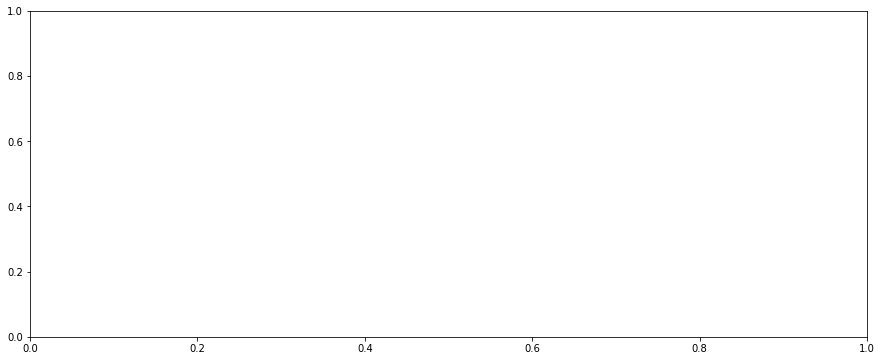

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

print('20200618:')
fig, ax = plt.subplots(figsize=(15, 6))
display(orderLog[(orderLog['secid'] > 2000000) & (orderLog['colo_broker'] == 'zt_96') & (orderLog["updateType"] != 0) & (orderLog["date"] == 20200618) & (orderLog["isMsg"] == 1)]['clockDif'].describe([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]).astype('int64'))
print('20200619:')
display(orderLog[(orderLog['secid'] > 2000000) & (orderLog['colo_broker'] == 'zt_96') & (orderLog["updateType"] != 0) & (orderLog["date"] == 20200619) & (orderLog["isMsg"] == 1)]['clockDif'].describe([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]).astype('int64'))
# data = orderLog[(orderLog['secid'] < 2000000) & (orderLog['colo_broker'] == 'zs_62') & (orderLog["updateType"] != 0) & (orderLog["date"] == 20200312) & (orderLog["isMsg"] == 0)& (orderLog["ars"] != 21)]['clockDif']
# # data = data[data < 1000000]
# sns.distplot(data, kde=False)
# # we only care about distribution within 3 or 5 seconds
# ax.set_xlabel("clock difference (us)")
# plt.title("SZE zt_95 clock difference distribution within 5 seconds")
# plt.show()